In [2]:
import torch
from torch import nn
import torchvision.models
import pickle

import torchvision
import torch
from torchvision.transforms import transforms
import numpy as np

In [2]:
class AverageMeter(object):
    """Computes and stores the average and current value
       Imported from https://github.com/pytorch/examples/blob/master/imagenet/main.py#L247-L262
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [3]:
import dataloader_cifar as dataloader

# Dataset loader

def imagenette_dataset():
    size  = 224
    ks = (int(0.1 * size) // 2) * 2 + 1
    __imagenet_stats = {'mean': [0.485, 0.456, 0.406],
                        'std': [0.229, 0.224, 0.225]}

    #TODO: chose transforms

    train_transform = transforms.Compose([
                                            transforms.RandomResizedCrop(224),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.ToTensor(),
                                            transforms.Normalize(**__imagenet_stats)])


    val_transform = transforms.Compose([
                                            transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize(**__imagenet_stats)])

    dataset_train = torchvision.datasets.ImageFolder(os.path.join(dataset_folderpath,'train'), train_transform)
    valid_ds = torchvision.datasets.ImageFolder(os.path.join(dataset_folderpath,'val'), val_transform)

    batch_size = 64
    train_dataloader = torch.utils.data.DataLoader(
            dataset_train,
            batch_size=batch_size,
            num_workers=2,
            drop_last=True,
            shuffle=True,
    )

    val_dataloader = torch.utils.data.DataLoader(
            valid_ds,
            batch_size=batch_size,
            num_workers=2,
            drop_last=True,
            shuffle=False,
    )
    return train_dataloader, val_dataloader

loader = None

def cifar10_dataset(noise_ratio=0.9):
    noise_mode='sym'
    batch_size=32
    data_path='cifar-10-batches-py/cifar-10-batches-py/'
    global loader
    loader = dataloader.cifar_dataloader('cifar10',r=noise_ratio,noise_mode=noise_mode,batch_size=batch_size,num_workers=5,\
        root_dir=data_path,noise_file='%s/%.1f_%s.json'%(data_path,noise_ratio,noise_mode))

    # batch shape: images, noise_label, index
    train_dataloader = loader.run('warmup')

    val_dataloader = loader.run('test')
    return train_dataloader, val_dataloader


train_dataloader, val_dataloader = cifar10_dataset()

loading noise file cifar-10-batches-py/cifar-10-batches-py//0.9_sym.json


In [4]:
def validate(model, val_dataloader):

    model.eval()
    
    with torch.no_grad():

        top1_sum = 0
        top5_sum = 0
        c = 0
        for b in tqdm(val_dataloader):
            x = b[0].cuda()
            y = b[1].cuda()

            y_hat = model(x)

            acc1, acc5 = accuracy(y_hat, y, (1,5))
            top1_sum += y.shape[0] * acc1
            top5_sum += y.shape[0] * acc5
            c += y.shape[0]
        
        top1_acc = top1_sum.item() / c
        top5_acc = top5_sum / c
        print(f"validation acc: top-1: {top1_acc}, top-5: {top5_acc}")
        return top1_acc, top5_acc



In [5]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].flatten().float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [6]:
from collections import OrderedDict
snapshot_name = "simclr_chkpnt/ckpt_cifar10_resnet50.pth"


def fix_state_dict(state_dict):
    # create new OrderedDict that does not contain `module.`
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[len('encoder.module.'):] # remove `module.`
    return new_state_dict

In [7]:
def switch_encoder(model, state):
    for p in model.encoder.parameters():
        p.requires_grad = state

In [8]:
from resnet import SupCEResNet
net = "resnet50"
chekpoint = torch.load(snapshot_name)
sd = {}
for ke in chekpoint['model']:
    nk = ke.replace('module.', '')
    sd[nk] = chekpoint['model'][ke]
model = SupCEResNet(net, num_classes=10)
model.load_state_dict(sd, strict=False)
model = model.to("cuda")

In [9]:
from tqdm.notebook  import tqdm
import copy
from resnet import resnet50
# Stage-2
dw_epochs = 50
criterion = nn.CrossEntropyLoss().cuda()
print_step = 100
out_dir="cifar10/clf_learning"
switch_encoder(model, False)
# validate(model, val_dataloader)
print(f"learnable paramters: {sum(torch.numel(p) for p in model.parameters() if p.requires_grad)}")

# optimizer
lc_opt = torch.optim.SGD(model.parameters(), lr=3e-3 , momentum=0.9)
lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(lc_opt, dw_epochs, 0)
lc_opt.zero_grad()


lin_loss_log = []
lin_epoch_loss = []
acc1_hist = []
acc5_hist = []

def mlp_train():
    model.eval()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val = 0
    for epoch in range(1, dw_epochs + 1):
        total_loss = 0
        # images, noise_label, index
        for batch_idx, (x, y, index) in enumerate(tqdm(train_dataloader)):
            x = x.cuda()
            y = y.cuda()
            y_hat = model(x)
            loss = criterion(y_hat, y)
            
            lc_opt.zero_grad()
            loss.backward()
            lc_opt.step()
            
            total_loss += loss.item()
            lin_loss_log.append(loss.item())
            if batch_idx % print_step == 0:
                tqdm.write('Loss {:.4f}'.format(loss.item()))

        current_epoch_loss = total_loss/len(train_dataloader)
        lin_epoch_loss.append(current_epoch_loss)
        print('Epoch {}: mean loss={:.4f}'.format(epoch, current_epoch_loss))
        lr_sched.step()
        print(f"update lr to: {lc_opt.param_groups[0]['lr']}")
        val,val5 = validate(model, val_dataloader)
        acc1_hist.append(val)
        acc5_hist.append(val5)
        if val > best_val:
            best_val = val
            best_model_wts = copy.deepcopy(model.state_dict())

        model.train()
        print(f"learnable paramters: {sum(torch.numel(p) for p in model.parameters() if p.requires_grad)}")
        if epoch % 10 == 0:
            with open(f"{out_dir}/classifier_loss_logs.pkl", "wb") as f:
                pickle.dump([lin_loss_log, lin_epoch_loss], f)
    return best_model_wts, best_val

# wts, best_val = mlp_train()
# torch.save(wts, f"{out_dir}/final_model_wts.bin")
model.load_state_dict(torch.load(f"{out_dir}/final_model_wts.bin"))
validate(model, val_dataloader)
# validate(model, loader.run('eval_train'))

learnable paramters: 20490



validation acc: top-1: 86.7, top-5: tensor([98.6100], device='cuda:0')


(86.7, tensor([98.6100], device='cuda:0'))

<Figure size 432x288 with 0 Axes>

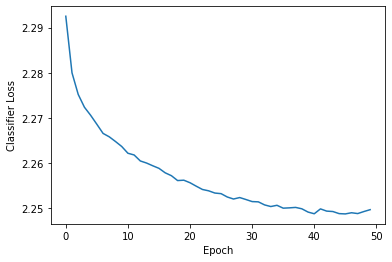

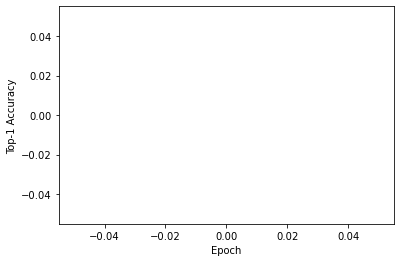

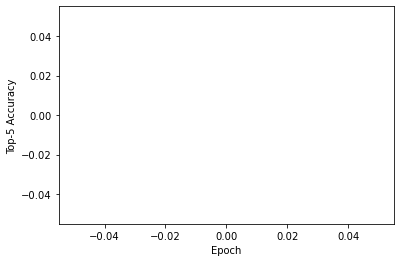

<Figure size 432x288 with 0 Axes>

In [10]:
'''Loading the Classifier Loss logs'''
with open(f"{out_dir}/classifier_loss_logs.pkl",'rb') as f:
    loss = pickle.load(f)
    f.close()
    
from matplotlib import pyplot as plt
plt.plot(loss[1])
# plt.xscale('log')
plt.xlabel('Epoch')
plt.ylabel('Classifier Loss')
plt.figure()


''' plotting the Top-1 & Top-5 accuracy'''
plt.plot(acc1_hist)
plt.xlabel('Epoch')
plt.ylabel('Top-1 Accuracy')
plt.figure()
hist5 = [a.item() for a in acc5_hist]
plt.plot(hist5)
plt.xlabel('Epoch')
plt.ylabel('Top-5 Accuracy')
plt.figure()



In [11]:
from sklearn.mixture import GaussianMixture
import dataloader_cifar as dataloader

def get_train(model, dataloader, estimate_p_right=True, p_right_threshold=0.5, p_clean_threshold=0.5, CBS=True):
    model.eval()
    losses = []
    confidence = []
    label_preds = []
    crit = nn.CrossEntropyLoss(reduction='none')
    with torch.no_grad():
        for batch_idx, (inputs, targets, index) in enumerate(dataloader):
            inputs, targets = inputs.cuda(), targets.cuda() 
            outputs = model(inputs)
            b_losses = crit(outputs, targets)
            probs, b_preds = torch.max(torch.softmax(outputs, dim=-1), dim=-1)
            confidence.append(probs)
            label_preds.append(b_preds)
            losses.append(b_losses)

    losses = torch.cat(losses, dim=0).cpu()
    confidence = torch.cat(confidence, dim=0).cpu()
    label_preds = torch.cat(label_preds, dim=0).cpu()
    losses = (losses-losses.min())/(losses.max()-losses.min())
    
    input_loss = losses.reshape(-1, 1)
    confidence = confidence.reshape(-1, 1)
    # fit a two-component GMM to the loss
    gmm1 = GaussianMixture(n_components=2,max_iter=10,tol=1e-2,reg_covar=5e-4)
    gmm1.fit(input_loss)
    prob = gmm1.predict_proba(input_loss)
    p_clean = prob[:,gmm1.means_.argmin()]
    clean = (p_clean > p_clean_threshold)
    if estimate_p_right:
        gmm2 = GaussianMixture(n_components=2,max_iter=10,tol=1e-2,reg_covar=5e-4)
        gmm2.fit(confidence)
        print(gmm2.means_)
        prob = gmm2.predict_proba(confidence)
        p_right = prob[:, gmm2.means_.argmax()]
        relabel_indicator = p_right > p_right_threshold
        return loader.run('train', clean, p_clean, CBS=CBS,relabel_indicator=relabel_indicator, label_preds=label_preds)

    return loader.run('train', clean, p_clean, CBS=CBS)


In [12]:
def linear_rampup(current, rampup_length=10):
    if rampup_length == 0:
        return 1.0
    else:
        current = np.clip(current / rampup_length, 0.0, 1.0)
        return float(current)

class SemiLoss(object):
    def __call__(self, outputs_x, targets_x, outputs_u, targets_u, epoch, lambda_u=75, unsupervised_term=True):
        probs_u = torch.softmax(outputs_u, dim=1)

        Lx = -torch.mean(torch.sum(F.log_softmax(outputs_x, dim=1) * targets_x, dim=1))
        if unsupervised_term:
            Lu = torch.mean((probs_u - targets_u) ** 2)
            return (Lx, Lu, lambda_u * linear_rampup(epoch))
        return (Lx,)


In [13]:
def interleave_offsets(batch, nu):
    groups = [batch // (nu + 1)] * (nu + 1)
    for x in range(batch - sum(groups)):
        groups[-x - 1] += 1
    offsets = [0]
    for g in groups:
        offsets.append(offsets[-1] + g)
    assert offsets[-1] == batch
    return offsets


def interleave(xy, batch):
    nu = len(xy) - 1
    offsets = interleave_offsets(batch, nu)
    xy = [[v[offsets[p]:offsets[p + 1]] for p in range(nu + 1)] for v in xy]
    for i in range(1, nu + 1):
        xy[0][i], xy[i][i] = xy[i][i], xy[0][i]
    return [torch.cat(v, dim=0) for v in xy]

In [14]:
def kronecker_product(t1, t2):
    """
    Computes the Kronecker product between two tensors.
    See https://en.wikipedia.org/wiki/Kronecker_product
    """
    t1_height, t1_width = t1.shape
    t2_height, t2_width = t2.shape
    out_height = t1_height * t2_height
    out_width = t1_width * t2_width

    tiled_t2 = t2.repeat(t1_height, t1_width)
    expanded_t1 = (
        t1.unsqueeze(2)
          .unsqueeze(3)
          .repeat(1, t2_height, t2_width, 1)
          .view(out_height, out_width)
    )

    return expanded_t1 * tiled_t2

In [15]:
import torch
from torch.nn import ReLU
from torch.nn.functional import normalize

Re = ReLU()
src = torch.ones(32,10)
lab_num = 32# len(L[0])
unlab_num = 64 #len(U)
one_vec1 = torch.ones(lab_num).unsqueeze(dim=0).cuda().detach()
one_vec = torch.ones(unlab_num).unsqueeze(dim=0).cuda().detach()

def graph_structured_regularization(model, L, U, lambda_uu, lambda_lu, tau): #U-unlabled class, L-labled, 
    A_lu = None
    A_uu = None
    with torch.no_grad():
        Z_l = model.encoder(L[0].cuda())
        Z_u = model.encoder(U.cuda())
        Z_l = normalize(Z_l,dim=1)
        Z_u = normalize(Z_u,dim=1)
        A_lu = Re(torch.matmul(Z_l, Z_u.t())-tau)
        A_uu = Re(torch.matmul(Z_u, Z_u.t())-tau)
    y_hat = L[1]
    p = model(U.cuda())
    p = torch.softmax(p, dim=-1)
    # P_mat = kronecker_product(one_vec, p).reshape(unlab_num, unlab_num, 10)
    P_mat = p.repeat(1, unlab_num).view(unlab_num, unlab_num, 10)
    P_mat1 = P_mat[:,:32,:] # kronecker_product(one_vec1, p).reshape(unlab_num, lab_num, 10)
    # Y_mat = kronecker_product(one_vec,y_hat).reshape(lab_num, unlab_num,10)
    Y_mat = y_hat.repeat(1, unlab_num).reshape(lab_num, unlab_num,10)
    P_mat1 = torch.transpose(P_mat1,0,1)
    norm_lu = torch.mean((P_mat1 - Y_mat) **2)
    norm_uu = torch.mean((P_mat - torch.transpose(P_mat,0,1) ** 2))
    return  (0.5 * lambda_uu*A_uu*norm_uu).sum() + (lambda_lu*A_lu*norm_lu).sum() 

In [16]:
import time
from tqdm.notebook  import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.nn import functional as F



def train(labeled_trainloader, unlabeled_trainloader, model, criterion, T=0.5, alpha=0.75, train_iteration=1024, graph_reg=True, unsupervised_term=True, epochs=100, exp_name=None):
    acc1_hist = []
    acc5_hist = []
    losses_x_hist = []
    losses_u_hist = []
    losses_r_hist = []
    best_val = 0
    switch_encoder(model, state=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    optimizer.zero_grad()
    print(f"learnable paramters: {sum(torch.numel(p) for p in model.parameters() if p.requires_grad)}")
    for epoch in range(epochs):
        batch_time = AverageMeter()
        data_time = AverageMeter()
        losses = AverageMeter()
        losses_x = AverageMeter()
        losses_u = AverageMeter()
        losses_r = AverageMeter()
        time_loss_r = AverageMeter()

        ws = AverageMeter()
        end = time.time()
        labeled_train_iter = iter(labeled_trainloader)
        unlabeled_train_iter = iter(unlabeled_trainloader)

        model.train()
        for batch_idx in tqdm(range(train_iteration)):
            try:
                inputs_x, targets_x = labeled_train_iter.next()
            except:
                labeled_train_iter = iter(labeled_trainloader)
                inputs_x, targets_x = labeled_train_iter.next()

            try:
                inputs_u, inputs_u2 = unlabeled_train_iter.next()
            except:
                unlabeled_train_iter = iter(unlabeled_trainloader)
                inputs_u, inputs_u2 = unlabeled_train_iter.next()

            # measure data loading time
            data_time.update(time.time() - end)

            batch_size = inputs_x.size(0)

            # Transform label to one-hot
            targets_x = torch.zeros(batch_size, 10).scatter_(1, targets_x.view(-1,1).long(), 1)

            inputs_x, targets_x = inputs_x.cuda(), targets_x.cuda(non_blocking=True)
            inputs_u = inputs_u.cuda()
            inputs_u2 = inputs_u2.cuda()

            with torch.no_grad():
                # compute guessed labels of unlabel samples
                outputs_u = model(inputs_u)
                outputs_u2 = model(inputs_u2)
                p = (torch.softmax(outputs_u, dim=1) + torch.softmax(outputs_u2, dim=1)) / 2
                pt = p ** (1 / T)
                targets_u = pt / pt.sum(dim=1, keepdim=True)
                targets_u = targets_u.detach()

            # mixup
            all_inputs = torch.cat([inputs_x, inputs_u, inputs_u2], dim=0)
            all_targets = torch.cat([targets_x, targets_u, targets_u], dim=0)

            l = np.random.beta(alpha, alpha)

            l = max(l, 1-l)

            idx = torch.randperm(all_inputs.size(0))

            input_a, input_b = all_inputs, all_inputs[idx]
            target_a, target_b = all_targets, all_targets[idx]

            mixed_input = l * input_a + (1 - l) * input_b
            mixed_target = l * target_a + (1 - l) * target_b

            # interleave labeled and unlabed samples between batches to get correct batchnorm calculation 
            mixed_input = list(torch.split(mixed_input, batch_size))
            mixed_input = interleave(mixed_input, batch_size)

            logits = [model(mixed_input[0])]
            for input in mixed_input[1:]:
                logits.append(model(input))

            # put interleaved samples back
            logits = interleave(logits, batch_size)
            logits_x = logits[0]
            logits_u = torch.cat(logits[1:], dim=0)

            crit_res = criterion(logits_x, mixed_target[:batch_size], logits_u, mixed_target[batch_size:], epoch+batch_idx/train_iteration, unsupervised_term=unsupervised_term)
            Lx = crit_res[0]
            loss = Lx
            if unsupervised_term:
                Lu = crit_res[1] 
                w = crit_res[2]
                loss = loss + w * Lu

            if graph_reg:
                R = graph_structured_regularization(model, (inputs_x, targets_x), torch.cat([inputs_u, inputs_u2], dim=0), lambda_uu=0.01, lambda_lu=0.005, tau=0.5)
                loss = loss + R


            # record loss
            losses.update(loss.item(), inputs_x.size(0))
            losses_x.update(Lx.item(), inputs_x.size(0))
            if unsupervised_term:
                losses_u.update(Lu.item(), inputs_x.size(0))
                ws.update(w, inputs_x.size(0))
            if graph_reg:
                losses_r.update(R.item(), inputs_x.size(0))
            

            # compute gradient and do SGD step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            # plot progress
            if batch_idx % 100 == 0:
                print('({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Loss: {loss:.4f} | Loss_x: {loss_x:.4f} | Loss_u: {loss_u:.4f} | Loss_R: {loss_r:.4f} | W: {w:.4f}'.format(
                            batch=batch_idx + 1,
                            size=train_iteration,
                            data=data_time.avg,
                            bt=batch_time.avg,
                            loss=losses.avg,
                            loss_x=losses_x.avg,
                            loss_u=losses_u.avg,
                            loss_r=losses_r.avg,
                            w=ws.avg,
                            ))
                losses_x_hist.append(losses_x.avg)
                if unsupervised_term:
                    losses_u_hist.append(losses_u.avg)
                if graph_reg:
                    losses_r_hist.append(losses_r.avg)

            if batch_idx % 500 == 0:
                val,val5 = validate(model, val_dataloader)
                acc1_hist.append(val)
                acc5_hist.append(val5)
                
                if val > best_val:
                    best_val = val
                    best_model_wts = copy.deepcopy(model.state_dict())
            

    torch.save({'losses_x_hist': losses_x_hist, 'losses_u_hist': losses_u_hist, 'losses_r_hist': losses_r_hist, 'best_model_wts': best_model_wts, 'best_val': best_val, 'acc1_hist': acc1_hist, 'acc5_hist': acc5_hist}, f"runs/{exp_name}.bin")



loading noise file cifar-10-batches-py/cifar-10-batches-py//0.9_sym.json
[[0.16922674]
 [0.2508775 ]]
loading noise file cifar-10-batches-py/cifar-10-batches-py//0.9_sym.json
Confusion matrix before re-labeling


<Figure size 432x288 with 0 Axes>

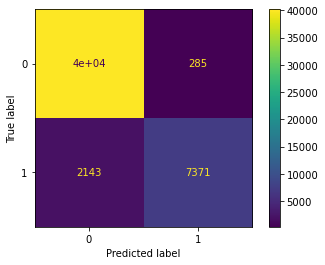

Confusion matrix after re-labeling


<Figure size 432x288 with 0 Axes>

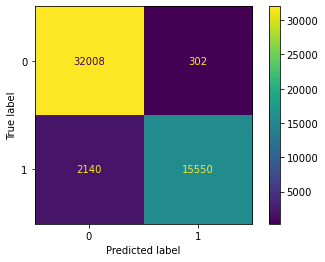

Numer of labeled samples:15852   AUC:0.663

labeled data has a size of 15852
using CBS
loading noise file cifar-10-batches-py/cifar-10-batches-py//0.9_sym.json
unlabeled data has a size of 34148
loading noise file cifar-10-batches-py/cifar-10-batches-py//0.9_sym.json
[[0.25152032]
 [0.16945424]]
loading noise file cifar-10-batches-py/cifar-10-batches-py//0.9_sym.json
Confusion matrix before re-labeling


<Figure size 432x288 with 0 Axes>

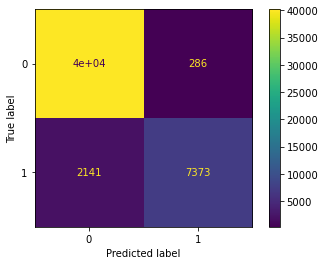

Confusion matrix after re-labeling


<Figure size 432x288 with 0 Axes>

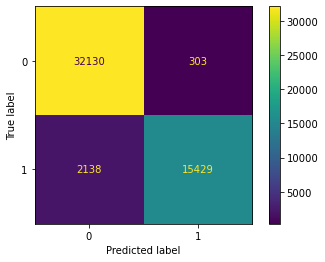

Numer of labeled samples:15732   AUC:0.665

labeled data has a size of 15732
loading noise file cifar-10-batches-py/cifar-10-batches-py//0.9_sym.json
unlabeled data has a size of 34268


In [17]:
cbs_labeled_trainloader, cbs_unlabeled_trainloader = get_train(model, loader.run('eval_train'), estimate_p_right=True, CBS=True)
labeled_trainloader, unlabeled_trainloader = get_train(model, loader.run('eval_train'), estimate_p_right=True, CBS=False)

In [18]:
# CBS: True, GMM1: true, GMM2: true, unsupervised_term: false....
train(cbs_labeled_trainloader, cbs_unlabeled_trainloader, model, criterion=SemiLoss(), T=0.5, alpha=0.75, train_iteration=1024, unsupervised_term=True, graph_reg=True, exp_name='reproduce')

learnable paramters: 23520842


(1/1024) Data: 0.760s | Batch: 1.165s | Loss: 1.7621 | Loss_x: 1.7339 | Loss_u: 0.0009 | Loss_R: 0.0282 | W: 0.0000



validation acc: top-1: 86.68, top-5: tensor([98.4800], device='cuda:0')
(101/1024) Data: 0.066s | Batch: 0.365s | Loss: 1.4060 | Loss_x: 1.2826 | Loss_u: 0.0120 | Loss_R: 0.1189 | W: 0.3662
(201/1024) Data: 0.036s | Batch: 0.334s | Loss: 1.3573 | Loss_x: 1.2296 | Loss_u: 0.0125 | Loss_R: 0.1183 | W: 0.7324
(301/1024) Data: 0.026s | Batch: 0.324s | Loss: 1.3429 | Loss_x: 1.2086 | Loss_u: 0.0127 | Loss_R: 0.1199 | W: 1.0986
(401/1024) Data: 0.021s | Batch: 0.319s | Loss: 1.3254 | Loss_x: 1.1862 | Loss_u: 0.0127 | Loss_R: 0.1203 | W: 1.4648
(501/1024) Data: 0.018s | Batch: 0.317s | Loss: 1.3114 | Loss_x: 1.1665 | Loss_u: 0.0127 | Loss_R: 0.1213 | W: 1.8311



validation acc: top-1: 81.78, top-5: tensor([98.6300], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.324s | Loss: 1.2917 | Loss_x: 1.1432 | Loss_u: 0.0127 | Loss_R: 0.1206 | W: 2.1973
(701/1024) Data: 0.022s | Batch: 0.321s | Loss: 1.2815 | Loss_x: 1.1278 | Loss_u: 0.0126 | Loss_R: 0.1213 | W: 2.5635
(801/1024) Data: 0.020s | Batch: 0.319s | Loss: 1.2677 | Loss_x: 1.1115 | Loss_u: 0.0125 | Loss_R: 0.1199 | W: 2.9297
(901/1024) Data: 0.018s | Batch: 0.318s | Loss: 1.2787 | Loss_x: 1.1171 | Loss_u: 0.0127 | Loss_R: 0.1194 | W: 3.2959
(1001/1024) Data: 0.017s | Batch: 0.317s | Loss: 1.2721 | Loss_x: 1.1065 | Loss_u: 0.0126 | Loss_R: 0.1192 | W: 3.6621



validation acc: top-1: 81.05, top-5: tensor([98.6000], device='cuda:0')



(1/1024) Data: 1.048s | Batch: 1.368s | Loss: 1.2767 | Loss_x: 1.1514 | Loss_u: 0.0096 | Loss_R: 0.0535 | W: 7.5000



validation acc: top-1: 85.44, top-5: tensor([98.5600], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.369s | Loss: 1.1687 | Loss_x: 0.9873 | Loss_u: 0.0110 | Loss_R: 0.0948 | W: 7.8662
(201/1024) Data: 0.037s | Batch: 0.337s | Loss: 1.1802 | Loss_x: 0.9868 | Loss_u: 0.0114 | Loss_R: 0.0991 | W: 8.2324
(301/1024) Data: 0.026s | Batch: 0.327s | Loss: 1.1822 | Loss_x: 0.9801 | Loss_u: 0.0116 | Loss_R: 0.1025 | W: 8.5986
(401/1024) Data: 0.021s | Batch: 0.321s | Loss: 1.1941 | Loss_x: 0.9856 | Loss_u: 0.0117 | Loss_R: 0.1032 | W: 8.9648
(501/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.1977 | Loss_x: 0.9836 | Loss_u: 0.0118 | Loss_R: 0.1034 | W: 9.3311



validation acc: top-1: 85.31, top-5: tensor([99.0100], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.325s | Loss: 1.2084 | Loss_x: 0.9874 | Loss_u: 0.0119 | Loss_R: 0.1046 | W: 9.6973
(701/1024) Data: 0.023s | Batch: 0.322s | Loss: 1.2020 | Loss_x: 0.9774 | Loss_u: 0.0119 | Loss_R: 0.1048 | W: 10.0635
(801/1024) Data: 0.020s | Batch: 0.320s | Loss: 1.2229 | Loss_x: 0.9908 | Loss_u: 0.0121 | Loss_R: 0.1048 | W: 10.4297
(901/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.2349 | Loss_x: 0.9978 | Loss_u: 0.0122 | Loss_R: 0.1045 | W: 10.7959
(1001/1024) Data: 0.018s | Batch: 0.318s | Loss: 1.2416 | Loss_x: 0.9994 | Loss_u: 0.0123 | Loss_R: 0.1042 | W: 11.1621



validation acc: top-1: 79.97, top-5: tensor([96.0700], device='cuda:0')



(1/1024) Data: 1.053s | Batch: 1.378s | Loss: 1.7209 | Loss_x: 1.4634 | Loss_u: 0.0126 | Loss_R: 0.0682 | W: 15.0000



validation acc: top-1: 86.75, top-5: tensor([98.9700], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.367s | Loss: 1.3178 | Loss_x: 1.0261 | Loss_u: 0.0122 | Loss_R: 0.1047 | W: 15.3662
(201/1024) Data: 0.037s | Batch: 0.336s | Loss: 1.3014 | Loss_x: 1.0063 | Loss_u: 0.0119 | Loss_R: 0.1084 | W: 15.7324
(301/1024) Data: 0.026s | Batch: 0.326s | Loss: 1.2952 | Loss_x: 0.9978 | Loss_u: 0.0119 | Loss_R: 0.1062 | W: 16.0986
(401/1024) Data: 0.021s | Batch: 0.320s | Loss: 1.3215 | Loss_x: 1.0161 | Loss_u: 0.0121 | Loss_R: 0.1057 | W: 16.4648
(501/1024) Data: 0.019s | Batch: 0.318s | Loss: 1.3358 | Loss_x: 1.0252 | Loss_u: 0.0122 | Loss_R: 0.1049 | W: 16.8311



validation acc: top-1: 85.4, top-5: tensor([98.8800], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.325s | Loss: 1.3284 | Loss_x: 1.0161 | Loss_u: 0.0121 | Loss_R: 0.1046 | W: 17.1973
(701/1024) Data: 0.022s | Batch: 0.322s | Loss: 1.3269 | Loss_x: 1.0113 | Loss_u: 0.0120 | Loss_R: 0.1043 | W: 17.5635
(801/1024) Data: 0.020s | Batch: 0.319s | Loss: 1.3270 | Loss_x: 1.0070 | Loss_u: 0.0120 | Loss_R: 0.1045 | W: 17.9297
(901/1024) Data: 0.019s | Batch: 0.318s | Loss: 1.3320 | Loss_x: 1.0078 | Loss_u: 0.0121 | Loss_R: 0.1034 | W: 18.2959
(1001/1024) Data: 0.018s | Batch: 0.317s | Loss: 1.3405 | Loss_x: 1.0117 | Loss_u: 0.0121 | Loss_R: 0.1033 | W: 18.6621



validation acc: top-1: 79.45, top-5: tensor([97.7800], device='cuda:0')



(1/1024) Data: 1.064s | Batch: 1.378s | Loss: 1.4596 | Loss_x: 1.1864 | Loss_u: 0.0088 | Loss_R: 0.0752 | W: 22.5000



validation acc: top-1: 85.46, top-5: tensor([98.8400], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.370s | Loss: 1.3818 | Loss_x: 1.0110 | Loss_u: 0.0119 | Loss_R: 0.0988 | W: 22.8662
(201/1024) Data: 0.037s | Batch: 0.338s | Loss: 1.3524 | Loss_x: 0.9786 | Loss_u: 0.0117 | Loss_R: 0.1029 | W: 23.2324
(301/1024) Data: 0.027s | Batch: 0.327s | Loss: 1.3526 | Loss_x: 0.9776 | Loss_u: 0.0116 | Loss_R: 0.1015 | W: 23.5986
(401/1024) Data: 0.021s | Batch: 0.322s | Loss: 1.3480 | Loss_x: 0.9721 | Loss_u: 0.0115 | Loss_R: 0.1003 | W: 23.9648
(501/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.3575 | Loss_x: 0.9746 | Loss_u: 0.0116 | Loss_R: 0.0997 | W: 24.3311



validation acc: top-1: 84.41, top-5: tensor([98.8400], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.326s | Loss: 1.3767 | Loss_x: 0.9838 | Loss_u: 0.0119 | Loss_R: 0.0989 | W: 24.6973
(701/1024) Data: 0.023s | Batch: 0.323s | Loss: 1.3696 | Loss_x: 0.9743 | Loss_u: 0.0118 | Loss_R: 0.0981 | W: 25.0635
(801/1024) Data: 0.020s | Batch: 0.320s | Loss: 1.3810 | Loss_x: 0.9802 | Loss_u: 0.0119 | Loss_R: 0.0977 | W: 25.4297
(901/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.3862 | Loss_x: 0.9819 | Loss_u: 0.0119 | Loss_R: 0.0972 | W: 25.7959
(1001/1024) Data: 0.018s | Batch: 0.318s | Loss: 1.3817 | Loss_x: 0.9753 | Loss_u: 0.0118 | Loss_R: 0.0965 | W: 26.1621



validation acc: top-1: 83.13, top-5: tensor([97.8200], device='cuda:0')



(1/1024) Data: 1.070s | Batch: 1.390s | Loss: 1.2254 | Loss_x: 0.8614 | Loss_u: 0.0096 | Loss_R: 0.0768 | W: 30.0000



validation acc: top-1: 83.7, top-5: tensor([97.9800], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.369s | Loss: 1.4536 | Loss_x: 0.9904 | Loss_u: 0.0121 | Loss_R: 0.0948 | W: 30.3662
(201/1024) Data: 0.036s | Batch: 0.337s | Loss: 1.4470 | Loss_x: 0.9922 | Loss_u: 0.0116 | Loss_R: 0.0979 | W: 30.7324
(301/1024) Data: 0.026s | Batch: 0.327s | Loss: 1.4147 | Loss_x: 0.9653 | Loss_u: 0.0113 | Loss_R: 0.0987 | W: 31.0986
(401/1024) Data: 0.021s | Batch: 0.322s | Loss: 1.4213 | Loss_x: 0.9645 | Loss_u: 0.0114 | Loss_R: 0.0973 | W: 31.4648
(501/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.4328 | Loss_x: 0.9710 | Loss_u: 0.0115 | Loss_R: 0.0964 | W: 31.8311



validation acc: top-1: 84.78, top-5: tensor([98.3700], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.326s | Loss: 1.4286 | Loss_x: 0.9652 | Loss_u: 0.0114 | Loss_R: 0.0956 | W: 32.1973
(701/1024) Data: 0.022s | Batch: 0.323s | Loss: 1.4266 | Loss_x: 0.9609 | Loss_u: 0.0114 | Loss_R: 0.0946 | W: 32.5635
(801/1024) Data: 0.020s | Batch: 0.321s | Loss: 1.4345 | Loss_x: 0.9656 | Loss_u: 0.0114 | Loss_R: 0.0946 | W: 32.9297
(901/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.4401 | Loss_x: 0.9687 | Loss_u: 0.0113 | Loss_R: 0.0963 | W: 33.2959
(1001/1024) Data: 0.018s | Batch: 0.318s | Loss: 1.4509 | Loss_x: 0.9740 | Loss_u: 0.0113 | Loss_R: 0.0983 | W: 33.6621



validation acc: top-1: 82.34, top-5: tensor([97.7600], device='cuda:0')



(1/1024) Data: 1.061s | Batch: 1.378s | Loss: 1.2421 | Loss_x: 0.6509 | Loss_u: 0.0136 | Loss_R: 0.0809 | W: 37.5000



validation acc: top-1: 83.71, top-5: tensor([98.1500], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.367s | Loss: 1.5214 | Loss_x: 0.9849 | Loss_u: 0.0111 | Loss_R: 0.1166 | W: 37.8662
(201/1024) Data: 0.037s | Batch: 0.336s | Loss: 1.5653 | Loss_x: 1.0085 | Loss_u: 0.0116 | Loss_R: 0.1117 | W: 38.2324
(301/1024) Data: 0.026s | Batch: 0.326s | Loss: 1.5961 | Loss_x: 1.0277 | Loss_u: 0.0119 | Loss_R: 0.1105 | W: 38.5986
(401/1024) Data: 0.021s | Batch: 0.321s | Loss: 1.5658 | Loss_x: 1.0057 | Loss_u: 0.0116 | Loss_R: 0.1083 | W: 38.9648
(501/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.5692 | Loss_x: 1.0050 | Loss_u: 0.0116 | Loss_R: 0.1068 | W: 39.3311



validation acc: top-1: 69.94, top-5: tensor([97.6200], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.325s | Loss: 1.5776 | Loss_x: 1.0100 | Loss_u: 0.0117 | Loss_R: 0.1040 | W: 39.6973
(701/1024) Data: 0.022s | Batch: 0.323s | Loss: 1.5760 | Loss_x: 1.0073 | Loss_u: 0.0116 | Loss_R: 0.1030 | W: 40.0635
(801/1024) Data: 0.020s | Batch: 0.321s | Loss: 1.5756 | Loss_x: 1.0040 | Loss_u: 0.0116 | Loss_R: 0.1008 | W: 40.4297
(901/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.5804 | Loss_x: 1.0039 | Loss_u: 0.0117 | Loss_R: 0.0990 | W: 40.7959
(1001/1024) Data: 0.018s | Batch: 0.318s | Loss: 1.5716 | Loss_x: 0.9960 | Loss_u: 0.0116 | Loss_R: 0.0984 | W: 41.1621



validation acc: top-1: 75.71, top-5: tensor([98.3400], device='cuda:0')



(1/1024) Data: 1.057s | Batch: 1.379s | Loss: 1.2721 | Loss_x: 0.7986 | Loss_u: 0.0085 | Loss_R: 0.0891 | W: 45.0000



validation acc: top-1: 83.42, top-5: tensor([98.8400], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.369s | Loss: 1.6674 | Loss_x: 1.0332 | Loss_u: 0.0115 | Loss_R: 0.1116 | W: 45.3662
(201/1024) Data: 0.037s | Batch: 0.338s | Loss: 1.6543 | Loss_x: 1.0304 | Loss_u: 0.0112 | Loss_R: 0.1105 | W: 45.7324
(301/1024) Data: 0.026s | Batch: 0.327s | Loss: 1.6410 | Loss_x: 1.0232 | Loss_u: 0.0109 | Loss_R: 0.1134 | W: 46.0986
(401/1024) Data: 0.021s | Batch: 0.322s | Loss: 1.6447 | Loss_x: 1.0219 | Loss_u: 0.0110 | Loss_R: 0.1126 | W: 46.4648
(501/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.6315 | Loss_x: 1.0130 | Loss_u: 0.0109 | Loss_R: 0.1099 | W: 46.8311



validation acc: top-1: 77.39, top-5: tensor([96.7900], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.325s | Loss: 1.6262 | Loss_x: 1.0072 | Loss_u: 0.0109 | Loss_R: 0.1071 | W: 47.1973
(701/1024) Data: 0.022s | Batch: 0.322s | Loss: 1.6261 | Loss_x: 1.0065 | Loss_u: 0.0108 | Loss_R: 0.1066 | W: 47.5635
(801/1024) Data: 0.020s | Batch: 0.320s | Loss: 1.6144 | Loss_x: 0.9987 | Loss_u: 0.0107 | Loss_R: 0.1055 | W: 47.9297
(901/1024) Data: 0.019s | Batch: 0.318s | Loss: 1.6232 | Loss_x: 1.0042 | Loss_u: 0.0107 | Loss_R: 0.1051 | W: 48.2959
(1001/1024) Data: 0.018s | Batch: 0.317s | Loss: 1.6226 | Loss_x: 0.9996 | Loss_u: 0.0107 | Loss_R: 0.1035 | W: 48.6621



validation acc: top-1: 79.93, top-5: tensor([97.8800], device='cuda:0')



(1/1024) Data: 1.055s | Batch: 1.372s | Loss: 1.4985 | Loss_x: 0.8663 | Loss_u: 0.0100 | Loss_R: 0.1055 | W: 52.5000



validation acc: top-1: 83.62, top-5: tensor([98.2700], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.368s | Loss: 1.6379 | Loss_x: 0.9644 | Loss_u: 0.0110 | Loss_R: 0.0939 | W: 52.8662
(201/1024) Data: 0.037s | Batch: 0.337s | Loss: 1.6403 | Loss_x: 0.9549 | Loss_u: 0.0111 | Loss_R: 0.0918 | W: 53.2324
(301/1024) Data: 0.026s | Batch: 0.327s | Loss: 1.6748 | Loss_x: 0.9789 | Loss_u: 0.0112 | Loss_R: 0.0953 | W: 53.5986
(401/1024) Data: 0.021s | Batch: 0.322s | Loss: 1.6882 | Loss_x: 0.9894 | Loss_u: 0.0112 | Loss_R: 0.0965 | W: 53.9648
(501/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.6991 | Loss_x: 0.9998 | Loss_u: 0.0111 | Loss_R: 0.0966 | W: 54.3311



validation acc: top-1: 74.6, top-5: tensor([97.3500], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.326s | Loss: 1.6981 | Loss_x: 1.0004 | Loss_u: 0.0110 | Loss_R: 0.0973 | W: 54.6973
(701/1024) Data: 0.023s | Batch: 0.323s | Loss: 1.7075 | Loss_x: 1.0080 | Loss_u: 0.0109 | Loss_R: 0.0979 | W: 55.0635
(801/1024) Data: 0.021s | Batch: 0.321s | Loss: 1.7206 | Loss_x: 1.0141 | Loss_u: 0.0110 | Loss_R: 0.0964 | W: 55.4297
(901/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.7130 | Loss_x: 1.0141 | Loss_u: 0.0108 | Loss_R: 0.0965 | W: 55.7959
(1001/1024) Data: 0.018s | Batch: 0.318s | Loss: 1.7310 | Loss_x: 1.0237 | Loss_u: 0.0109 | Loss_R: 0.0972 | W: 56.1621



validation acc: top-1: 68.08, top-5: tensor([97.9600], device='cuda:0')



(1/1024) Data: 1.049s | Batch: 1.366s | Loss: 3.0673 | Loss_x: 1.8467 | Loss_u: 0.0186 | Loss_R: 0.1026 | W: 60.0000



validation acc: top-1: 71.99, top-5: tensor([97.8500], device='cuda:0')
(101/1024) Data: 0.069s | Batch: 0.370s | Loss: 1.8988 | Loss_x: 1.1127 | Loss_u: 0.0110 | Loss_R: 0.1249 | W: 60.3662
(201/1024) Data: 0.037s | Batch: 0.337s | Loss: 1.8351 | Loss_x: 1.0794 | Loss_u: 0.0105 | Loss_R: 0.1164 | W: 60.7324
(301/1024) Data: 0.027s | Batch: 0.327s | Loss: 1.8755 | Loss_x: 1.0892 | Loss_u: 0.0110 | Loss_R: 0.1146 | W: 61.0986
(401/1024) Data: 0.021s | Batch: 0.321s | Loss: 1.8763 | Loss_x: 1.0847 | Loss_u: 0.0110 | Loss_R: 0.1145 | W: 61.4648
(501/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.8681 | Loss_x: 1.0790 | Loss_u: 0.0109 | Loss_R: 0.1130 | W: 61.8311



validation acc: top-1: 69.8, top-5: tensor([97.5900], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.325s | Loss: 1.8695 | Loss_x: 1.0765 | Loss_u: 0.0110 | Loss_R: 0.1110 | W: 62.1973
(701/1024) Data: 0.023s | Batch: 0.322s | Loss: 1.8641 | Loss_x: 1.0769 | Loss_u: 0.0108 | Loss_R: 0.1125 | W: 62.5635
(801/1024) Data: 0.021s | Batch: 0.320s | Loss: 1.8476 | Loss_x: 1.0682 | Loss_u: 0.0106 | Loss_R: 0.1109 | W: 62.9297
(901/1024) Data: 0.019s | Batch: 0.318s | Loss: 1.8338 | Loss_x: 1.0590 | Loss_u: 0.0105 | Loss_R: 0.1087 | W: 63.2959
(1001/1024) Data: 0.018s | Batch: 0.317s | Loss: 1.8348 | Loss_x: 1.0563 | Loss_u: 0.0106 | Loss_R: 0.1069 | W: 63.6621



validation acc: top-1: 70.08, top-5: tensor([98.0800], device='cuda:0')



(1/1024) Data: 1.060s | Batch: 1.384s | Loss: 1.3361 | Loss_x: 0.5181 | Loss_u: 0.0106 | Loss_R: 0.0996 | W: 67.5000



validation acc: top-1: 70.24, top-5: tensor([98.1100], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.369s | Loss: 1.9328 | Loss_x: 1.0774 | Loss_u: 0.0109 | Loss_R: 0.1188 | W: 67.8662
(201/1024) Data: 0.037s | Batch: 0.337s | Loss: 1.8988 | Loss_x: 1.0556 | Loss_u: 0.0106 | Loss_R: 0.1168 | W: 68.2324
(301/1024) Data: 0.026s | Batch: 0.326s | Loss: 1.8880 | Loss_x: 1.0689 | Loss_u: 0.0102 | Loss_R: 0.1184 | W: 68.5986
(401/1024) Data: 0.021s | Batch: 0.321s | Loss: 1.9036 | Loss_x: 1.0676 | Loss_u: 0.0105 | Loss_R: 0.1143 | W: 68.9648
(501/1024) Data: 0.019s | Batch: 0.318s | Loss: 1.9284 | Loss_x: 1.0873 | Loss_u: 0.0104 | Loss_R: 0.1198 | W: 69.3311



validation acc: top-1: 61.1, top-5: tensor([95.9300], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.325s | Loss: 1.9307 | Loss_x: 1.0877 | Loss_u: 0.0104 | Loss_R: 0.1197 | W: 69.6973
(701/1024) Data: 0.023s | Batch: 0.323s | Loss: 1.9265 | Loss_x: 1.0878 | Loss_u: 0.0103 | Loss_R: 0.1194 | W: 70.0635
(801/1024) Data: 0.021s | Batch: 0.321s | Loss: 1.9363 | Loss_x: 1.0950 | Loss_u: 0.0102 | Loss_R: 0.1199 | W: 70.4297
(901/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.9207 | Loss_x: 1.0872 | Loss_u: 0.0101 | Loss_R: 0.1183 | W: 70.7959
(1001/1024) Data: 0.018s | Batch: 0.318s | Loss: 1.9164 | Loss_x: 1.0855 | Loss_u: 0.0100 | Loss_R: 0.1177 | W: 71.1621



validation acc: top-1: 71.75, top-5: tensor([97.6400], device='cuda:0')



(1/1024) Data: 1.128s | Batch: 1.452s | Loss: 1.6426 | Loss_x: 1.0188 | Loss_u: 0.0069 | Loss_R: 0.1058 | W: 75.0000



validation acc: top-1: 66.62, top-5: tensor([98.4100], device='cuda:0')
(101/1024) Data: 0.072s | Batch: 0.375s | Loss: 2.0117 | Loss_x: 1.0939 | Loss_u: 0.0107 | Loss_R: 0.1182 | W: 75.0000
(201/1024) Data: 0.039s | Batch: 0.341s | Loss: 1.9824 | Loss_x: 1.0759 | Loss_u: 0.0106 | Loss_R: 0.1151 | W: 75.0000
(301/1024) Data: 0.028s | Batch: 0.330s | Loss: 1.9782 | Loss_x: 1.0986 | Loss_u: 0.0100 | Loss_R: 0.1263 | W: 75.0000
(401/1024) Data: 0.022s | Batch: 0.325s | Loss: 1.9493 | Loss_x: 1.0874 | Loss_u: 0.0098 | Loss_R: 0.1241 | W: 75.0000
(501/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.9679 | Loss_x: 1.0936 | Loss_u: 0.0101 | Loss_R: 0.1203 | W: 75.0000



validation acc: top-1: 67.33, top-5: tensor([96.1000], device='cuda:0')
(601/1024) Data: 0.027s | Batch: 0.330s | Loss: 1.9758 | Loss_x: 1.0953 | Loss_u: 0.0102 | Loss_R: 0.1183 | W: 75.0000
(701/1024) Data: 0.024s | Batch: 0.327s | Loss: 1.9620 | Loss_x: 1.0994 | Loss_u: 0.0099 | Loss_R: 0.1211 | W: 75.0000
(801/1024) Data: 0.022s | Batch: 0.325s | Loss: 1.9404 | Loss_x: 1.0957 | Loss_u: 0.0096 | Loss_R: 0.1217 | W: 75.0000
(901/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.9378 | Loss_x: 1.0950 | Loss_u: 0.0096 | Loss_R: 0.1215 | W: 75.0000
(1001/1024) Data: 0.019s | Batch: 0.321s | Loss: 1.9245 | Loss_x: 1.0894 | Loss_u: 0.0095 | Loss_R: 0.1201 | W: 75.0000



validation acc: top-1: 58.98, top-5: tensor([96.7200], device='cuda:0')



(1/1024) Data: 1.074s | Batch: 1.390s | Loss: 1.7257 | Loss_x: 1.0757 | Loss_u: 0.0067 | Loss_R: 0.1501 | W: 75.0000



validation acc: top-1: 70.11, top-5: tensor([98.1600], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.369s | Loss: 1.9172 | Loss_x: 1.0809 | Loss_u: 0.0094 | Loss_R: 0.1308 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.337s | Loss: 1.9170 | Loss_x: 1.0948 | Loss_u: 0.0092 | Loss_R: 0.1331 | W: 75.0000
(301/1024) Data: 0.026s | Batch: 0.327s | Loss: 1.9165 | Loss_x: 1.0930 | Loss_u: 0.0093 | Loss_R: 0.1256 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.322s | Loss: 1.9046 | Loss_x: 1.0822 | Loss_u: 0.0093 | Loss_R: 0.1214 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.9101 | Loss_x: 1.0761 | Loss_u: 0.0096 | Loss_R: 0.1169 | W: 75.0000



validation acc: top-1: 69.64, top-5: tensor([97.2600], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.326s | Loss: 1.9172 | Loss_x: 1.0749 | Loss_u: 0.0097 | Loss_R: 0.1138 | W: 75.0000
(701/1024) Data: 0.022s | Batch: 0.323s | Loss: 1.8993 | Loss_x: 1.0671 | Loss_u: 0.0096 | Loss_R: 0.1113 | W: 75.0000
(801/1024) Data: 0.020s | Batch: 0.321s | Loss: 1.8835 | Loss_x: 1.0557 | Loss_u: 0.0096 | Loss_R: 0.1093 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.8705 | Loss_x: 1.0522 | Loss_u: 0.0095 | Loss_R: 0.1082 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.318s | Loss: 1.8749 | Loss_x: 1.0575 | Loss_u: 0.0095 | Loss_R: 0.1084 | W: 75.0000



validation acc: top-1: 56.34, top-5: tensor([97.2300], device='cuda:0')



(1/1024) Data: 1.060s | Batch: 1.384s | Loss: 2.2113 | Loss_x: 1.1833 | Loss_u: 0.0120 | Loss_R: 0.1277 | W: 75.0000



validation acc: top-1: 67.82, top-5: tensor([98.0800], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.368s | Loss: 1.7994 | Loss_x: 1.0123 | Loss_u: 0.0090 | Loss_R: 0.1138 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.338s | Loss: 1.8307 | Loss_x: 1.0157 | Loss_u: 0.0094 | Loss_R: 0.1069 | W: 75.0000
(301/1024) Data: 0.026s | Batch: 0.327s | Loss: 1.8271 | Loss_x: 1.0295 | Loss_u: 0.0091 | Loss_R: 0.1121 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.321s | Loss: 1.8550 | Loss_x: 1.0377 | Loss_u: 0.0094 | Loss_R: 0.1110 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.8282 | Loss_x: 1.0319 | Loss_u: 0.0091 | Loss_R: 0.1112 | W: 75.0000



validation acc: top-1: 61.24, top-5: tensor([96.3300], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.325s | Loss: 1.8176 | Loss_x: 1.0237 | Loss_u: 0.0091 | Loss_R: 0.1098 | W: 75.0000
(701/1024) Data: 0.022s | Batch: 0.323s | Loss: 1.8393 | Loss_x: 1.0395 | Loss_u: 0.0092 | Loss_R: 0.1119 | W: 75.0000
(801/1024) Data: 0.020s | Batch: 0.320s | Loss: 1.8313 | Loss_x: 1.0334 | Loss_u: 0.0092 | Loss_R: 0.1109 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.8229 | Loss_x: 1.0305 | Loss_u: 0.0091 | Loss_R: 0.1103 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.318s | Loss: 1.8198 | Loss_x: 1.0295 | Loss_u: 0.0091 | Loss_R: 0.1095 | W: 75.0000



validation acc: top-1: 63.11, top-5: tensor([97.5300], device='cuda:0')



(1/1024) Data: 1.065s | Batch: 1.387s | Loss: 1.3945 | Loss_x: 0.5763 | Loss_u: 0.0090 | Loss_R: 0.1401 | W: 75.0000



validation acc: top-1: 63.97, top-5: tensor([98.2100], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.368s | Loss: 1.9935 | Loss_x: 1.1347 | Loss_u: 0.0098 | Loss_R: 0.1214 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.337s | Loss: 1.9199 | Loss_x: 1.1009 | Loss_u: 0.0093 | Loss_R: 0.1223 | W: 75.0000
(301/1024) Data: 0.026s | Batch: 0.327s | Loss: 1.8833 | Loss_x: 1.0897 | Loss_u: 0.0090 | Loss_R: 0.1211 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.322s | Loss: 1.9035 | Loss_x: 1.0957 | Loss_u: 0.0091 | Loss_R: 0.1237 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.9063 | Loss_x: 1.0931 | Loss_u: 0.0092 | Loss_R: 0.1241 | W: 75.0000



validation acc: top-1: 51.11, top-5: tensor([96.0600], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.326s | Loss: 1.8969 | Loss_x: 1.0813 | Loss_u: 0.0092 | Loss_R: 0.1224 | W: 75.0000
(701/1024) Data: 0.022s | Batch: 0.323s | Loss: 1.8971 | Loss_x: 1.0831 | Loss_u: 0.0092 | Loss_R: 0.1223 | W: 75.0000
(801/1024) Data: 0.020s | Batch: 0.321s | Loss: 1.8973 | Loss_x: 1.0797 | Loss_u: 0.0093 | Loss_R: 0.1216 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.8920 | Loss_x: 1.0758 | Loss_u: 0.0093 | Loss_R: 0.1200 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.319s | Loss: 1.8904 | Loss_x: 1.0743 | Loss_u: 0.0093 | Loss_R: 0.1190 | W: 75.0000



validation acc: top-1: 67.3, top-5: tensor([96.7000], device='cuda:0')



(1/1024) Data: 1.087s | Batch: 1.408s | Loss: 2.8131 | Loss_x: 1.5716 | Loss_u: 0.0145 | Loss_R: 0.1506 | W: 75.0000



validation acc: top-1: 71.51, top-5: tensor([97.9200], device='cuda:0')
(101/1024) Data: 0.070s | Batch: 0.373s | Loss: 2.0166 | Loss_x: 1.0975 | Loss_u: 0.0108 | Loss_R: 0.1113 | W: 75.0000
(201/1024) Data: 0.038s | Batch: 0.341s | Loss: 1.8924 | Loss_x: 1.0282 | Loss_u: 0.0101 | Loss_R: 0.1070 | W: 75.0000
(301/1024) Data: 0.027s | Batch: 0.329s | Loss: 1.8756 | Loss_x: 1.0204 | Loss_u: 0.0100 | Loss_R: 0.1074 | W: 75.0000
(401/1024) Data: 0.022s | Batch: 0.324s | Loss: 1.8784 | Loss_x: 1.0277 | Loss_u: 0.0099 | Loss_R: 0.1057 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.321s | Loss: 1.8715 | Loss_x: 1.0329 | Loss_u: 0.0098 | Loss_R: 0.1070 | W: 75.0000



validation acc: top-1: 65.06, top-5: tensor([97.3000], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.327s | Loss: 1.8903 | Loss_x: 1.0442 | Loss_u: 0.0099 | Loss_R: 0.1060 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.324s | Loss: 1.8742 | Loss_x: 1.0324 | Loss_u: 0.0098 | Loss_R: 0.1052 | W: 75.0000
(801/1024) Data: 0.021s | Batch: 0.321s | Loss: 1.8791 | Loss_x: 1.0312 | Loss_u: 0.0099 | Loss_R: 0.1037 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.8691 | Loss_x: 1.0273 | Loss_u: 0.0099 | Loss_R: 0.1028 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.319s | Loss: 1.8659 | Loss_x: 1.0272 | Loss_u: 0.0098 | Loss_R: 0.1021 | W: 75.0000



validation acc: top-1: 63.4, top-5: tensor([97.1000], device='cuda:0')



(1/1024) Data: 1.057s | Batch: 1.379s | Loss: 2.4092 | Loss_x: 1.1837 | Loss_u: 0.0144 | Loss_R: 0.1450 | W: 75.0000



validation acc: top-1: 67.76, top-5: tensor([98.4500], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.369s | Loss: 1.8422 | Loss_x: 0.9889 | Loss_u: 0.0099 | Loss_R: 0.1088 | W: 75.0000
(201/1024) Data: 0.036s | Batch: 0.337s | Loss: 1.8445 | Loss_x: 1.0172 | Loss_u: 0.0095 | Loss_R: 0.1118 | W: 75.0000
(301/1024) Data: 0.026s | Batch: 0.326s | Loss: 1.8565 | Loss_x: 1.0239 | Loss_u: 0.0097 | Loss_R: 0.1083 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.321s | Loss: 1.8525 | Loss_x: 1.0314 | Loss_u: 0.0094 | Loss_R: 0.1126 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.318s | Loss: 1.8498 | Loss_x: 1.0367 | Loss_u: 0.0093 | Loss_R: 0.1143 | W: 75.0000



validation acc: top-1: 57.83, top-5: tensor([96.8700], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.325s | Loss: 1.8177 | Loss_x: 1.0230 | Loss_u: 0.0091 | Loss_R: 0.1131 | W: 75.0000
(701/1024) Data: 0.022s | Batch: 0.322s | Loss: 1.8279 | Loss_x: 1.0297 | Loss_u: 0.0092 | Loss_R: 0.1116 | W: 75.0000
(801/1024) Data: 0.020s | Batch: 0.320s | Loss: 1.8105 | Loss_x: 1.0196 | Loss_u: 0.0091 | Loss_R: 0.1093 | W: 75.0000
(901/1024) Data: 0.018s | Batch: 0.318s | Loss: 1.8091 | Loss_x: 1.0178 | Loss_u: 0.0091 | Loss_R: 0.1075 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.318s | Loss: 1.8081 | Loss_x: 1.0205 | Loss_u: 0.0091 | Loss_R: 0.1066 | W: 75.0000



validation acc: top-1: 67.17, top-5: tensor([97.5000], device='cuda:0')



(1/1024) Data: 1.070s | Batch: 1.394s | Loss: 2.7510 | Loss_x: 1.5860 | Loss_u: 0.0136 | Loss_R: 0.1466 | W: 75.0000



validation acc: top-1: 61.34, top-5: tensor([98.1500], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.371s | Loss: 1.8638 | Loss_x: 1.0985 | Loss_u: 0.0087 | Loss_R: 0.1145 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.338s | Loss: 1.8890 | Loss_x: 1.0802 | Loss_u: 0.0093 | Loss_R: 0.1094 | W: 75.0000
(301/1024) Data: 0.026s | Batch: 0.326s | Loss: 1.8815 | Loss_x: 1.0664 | Loss_u: 0.0094 | Loss_R: 0.1089 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.321s | Loss: 1.8796 | Loss_x: 1.0502 | Loss_u: 0.0096 | Loss_R: 0.1079 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.8846 | Loss_x: 1.0500 | Loss_u: 0.0097 | Loss_R: 0.1077 | W: 75.0000



validation acc: top-1: 67.34, top-5: tensor([97.0500], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.325s | Loss: 1.8595 | Loss_x: 1.0317 | Loss_u: 0.0096 | Loss_R: 0.1061 | W: 75.0000
(701/1024) Data: 0.022s | Batch: 0.322s | Loss: 1.8599 | Loss_x: 1.0288 | Loss_u: 0.0097 | Loss_R: 0.1051 | W: 75.0000
(801/1024) Data: 0.020s | Batch: 0.320s | Loss: 1.8591 | Loss_x: 1.0256 | Loss_u: 0.0097 | Loss_R: 0.1045 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.8515 | Loss_x: 1.0200 | Loss_u: 0.0097 | Loss_R: 0.1032 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.318s | Loss: 1.8513 | Loss_x: 1.0201 | Loss_u: 0.0097 | Loss_R: 0.1026 | W: 75.0000



validation acc: top-1: 66.9, top-5: tensor([97.0800], device='cuda:0')



(1/1024) Data: 1.054s | Batch: 1.378s | Loss: 1.4866 | Loss_x: 0.7415 | Loss_u: 0.0078 | Loss_R: 0.1590 | W: 75.0000



validation acc: top-1: 66.63, top-5: tensor([97.5600], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.370s | Loss: 1.6952 | Loss_x: 0.9706 | Loss_u: 0.0082 | Loss_R: 0.1120 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.337s | Loss: 1.7386 | Loss_x: 0.9673 | Loss_u: 0.0089 | Loss_R: 0.1054 | W: 75.0000
(301/1024) Data: 0.026s | Batch: 0.327s | Loss: 1.7803 | Loss_x: 1.0015 | Loss_u: 0.0090 | Loss_R: 0.1065 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.321s | Loss: 1.8000 | Loss_x: 1.0164 | Loss_u: 0.0090 | Loss_R: 0.1067 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.8103 | Loss_x: 1.0170 | Loss_u: 0.0092 | Loss_R: 0.1049 | W: 75.0000



validation acc: top-1: 63.5, top-5: tensor([97.1700], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.325s | Loss: 1.8456 | Loss_x: 1.0449 | Loss_u: 0.0090 | Loss_R: 0.1234 | W: 75.0000
(701/1024) Data: 0.022s | Batch: 0.323s | Loss: 1.8525 | Loss_x: 1.0453 | Loss_u: 0.0091 | Loss_R: 0.1264 | W: 75.0000
(801/1024) Data: 0.020s | Batch: 0.320s | Loss: 1.8637 | Loss_x: 1.0470 | Loss_u: 0.0092 | Loss_R: 0.1277 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.318s | Loss: 1.8827 | Loss_x: 1.0573 | Loss_u: 0.0093 | Loss_R: 0.1306 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.317s | Loss: 1.8843 | Loss_x: 1.0542 | Loss_u: 0.0093 | Loss_R: 0.1308 | W: 75.0000



validation acc: top-1: 53.39, top-5: tensor([96.8400], device='cuda:0')



(1/1024) Data: 1.076s | Batch: 1.393s | Loss: 1.6451 | Loss_x: 0.8647 | Loss_u: 0.0083 | Loss_R: 0.1591 | W: 75.0000



validation acc: top-1: 69.93, top-5: tensor([96.6900], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.368s | Loss: 1.8137 | Loss_x: 1.0098 | Loss_u: 0.0089 | Loss_R: 0.1361 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.336s | Loss: 1.8946 | Loss_x: 1.0606 | Loss_u: 0.0093 | Loss_R: 0.1374 | W: 75.0000
(301/1024) Data: 0.026s | Batch: 0.326s | Loss: 1.9243 | Loss_x: 1.0595 | Loss_u: 0.0098 | Loss_R: 0.1327 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.321s | Loss: 1.9330 | Loss_x: 1.0695 | Loss_u: 0.0097 | Loss_R: 0.1347 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.9274 | Loss_x: 1.0661 | Loss_u: 0.0097 | Loss_R: 0.1331 | W: 75.0000



validation acc: top-1: 68.4, top-5: tensor([96.9300], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.325s | Loss: 1.9280 | Loss_x: 1.0619 | Loss_u: 0.0098 | Loss_R: 0.1328 | W: 75.0000
(701/1024) Data: 0.022s | Batch: 0.322s | Loss: 1.9241 | Loss_x: 1.0611 | Loss_u: 0.0097 | Loss_R: 0.1319 | W: 75.0000
(801/1024) Data: 0.020s | Batch: 0.320s | Loss: 1.9088 | Loss_x: 1.0559 | Loss_u: 0.0096 | Loss_R: 0.1320 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.318s | Loss: 1.8937 | Loss_x: 1.0491 | Loss_u: 0.0095 | Loss_R: 0.1310 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.317s | Loss: 1.8746 | Loss_x: 1.0413 | Loss_u: 0.0094 | Loss_R: 0.1294 | W: 75.0000



validation acc: top-1: 66.07, top-5: tensor([96.8900], device='cuda:0')



(1/1024) Data: 1.068s | Batch: 1.391s | Loss: 1.7856 | Loss_x: 1.0916 | Loss_u: 0.0073 | Loss_R: 0.1448 | W: 75.0000



validation acc: top-1: 65.95, top-5: tensor([97.4800], device='cuda:0')
(101/1024) Data: 0.069s | Batch: 0.369s | Loss: 1.8712 | Loss_x: 1.0569 | Loss_u: 0.0091 | Loss_R: 0.1285 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.338s | Loss: 1.9323 | Loss_x: 1.0702 | Loss_u: 0.0098 | Loss_R: 0.1240 | W: 75.0000
(301/1024) Data: 0.027s | Batch: 0.327s | Loss: 1.9073 | Loss_x: 1.0510 | Loss_u: 0.0098 | Loss_R: 0.1231 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.321s | Loss: 1.9022 | Loss_x: 1.0420 | Loss_u: 0.0099 | Loss_R: 0.1212 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.9026 | Loss_x: 1.0462 | Loss_u: 0.0098 | Loss_R: 0.1227 | W: 75.0000



validation acc: top-1: 61.54, top-5: tensor([97.2000], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.326s | Loss: 1.8998 | Loss_x: 1.0376 | Loss_u: 0.0099 | Loss_R: 0.1208 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.323s | Loss: 1.8882 | Loss_x: 1.0323 | Loss_u: 0.0098 | Loss_R: 0.1211 | W: 75.0000
(801/1024) Data: 0.020s | Batch: 0.321s | Loss: 1.9068 | Loss_x: 1.0386 | Loss_u: 0.0100 | Loss_R: 0.1189 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.8747 | Loss_x: 1.0223 | Loss_u: 0.0098 | Loss_R: 0.1164 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.318s | Loss: 1.8750 | Loss_x: 1.0214 | Loss_u: 0.0098 | Loss_R: 0.1154 | W: 75.0000



validation acc: top-1: 66.29, top-5: tensor([97.1800], device='cuda:0')



(1/1024) Data: 1.066s | Batch: 1.385s | Loss: 2.8787 | Loss_x: 1.5200 | Loss_u: 0.0160 | Loss_R: 0.1573 | W: 75.0000



validation acc: top-1: 71.62, top-5: tensor([97.5100], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.369s | Loss: 2.0204 | Loss_x: 1.1179 | Loss_u: 0.0101 | Loss_R: 0.1431 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.336s | Loss: 1.9745 | Loss_x: 1.0837 | Loss_u: 0.0101 | Loss_R: 0.1341 | W: 75.0000
(301/1024) Data: 0.026s | Batch: 0.326s | Loss: 1.9071 | Loss_x: 1.0520 | Loss_u: 0.0096 | Loss_R: 0.1321 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.321s | Loss: 1.9039 | Loss_x: 1.0417 | Loss_u: 0.0098 | Loss_R: 0.1268 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.9152 | Loss_x: 1.0387 | Loss_u: 0.0100 | Loss_R: 0.1243 | W: 75.0000



validation acc: top-1: 66.11, top-5: tensor([95.7900], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.326s | Loss: 1.9331 | Loss_x: 1.0419 | Loss_u: 0.0102 | Loss_R: 0.1241 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.323s | Loss: 1.9265 | Loss_x: 1.0346 | Loss_u: 0.0103 | Loss_R: 0.1210 | W: 75.0000
(801/1024) Data: 0.020s | Batch: 0.321s | Loss: 1.9232 | Loss_x: 1.0346 | Loss_u: 0.0102 | Loss_R: 0.1211 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.9110 | Loss_x: 1.0277 | Loss_u: 0.0102 | Loss_R: 0.1195 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.318s | Loss: 1.9059 | Loss_x: 1.0239 | Loss_u: 0.0102 | Loss_R: 0.1168 | W: 75.0000



validation acc: top-1: 67.75, top-5: tensor([95.9800], device='cuda:0')



(1/1024) Data: 1.059s | Batch: 1.380s | Loss: 1.7181 | Loss_x: 1.0191 | Loss_u: 0.0072 | Loss_R: 0.1565 | W: 75.0000



validation acc: top-1: 71.43, top-5: tensor([97.7500], device='cuda:0')
(101/1024) Data: 0.069s | Batch: 0.369s | Loss: 1.6789 | Loss_x: 0.9283 | Loss_u: 0.0085 | Loss_R: 0.1098 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.338s | Loss: 1.8127 | Loss_x: 0.9700 | Loss_u: 0.0099 | Loss_R: 0.1036 | W: 75.0000
(301/1024) Data: 0.027s | Batch: 0.327s | Loss: 1.8407 | Loss_x: 0.9887 | Loss_u: 0.0100 | Loss_R: 0.1043 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.321s | Loss: 1.8398 | Loss_x: 0.9921 | Loss_u: 0.0099 | Loss_R: 0.1041 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.8407 | Loss_x: 0.9868 | Loss_u: 0.0100 | Loss_R: 0.1020 | W: 75.0000



validation acc: top-1: 67.64, top-5: tensor([97.4200], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.326s | Loss: 1.8205 | Loss_x: 0.9794 | Loss_u: 0.0099 | Loss_R: 0.1019 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.323s | Loss: 1.8216 | Loss_x: 0.9799 | Loss_u: 0.0099 | Loss_R: 0.1009 | W: 75.0000
(801/1024) Data: 0.020s | Batch: 0.321s | Loss: 1.8185 | Loss_x: 0.9828 | Loss_u: 0.0098 | Loss_R: 0.1011 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.8145 | Loss_x: 0.9866 | Loss_u: 0.0097 | Loss_R: 0.1018 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.318s | Loss: 1.8151 | Loss_x: 0.9896 | Loss_u: 0.0096 | Loss_R: 0.1023 | W: 75.0000



validation acc: top-1: 53.81, top-5: tensor([96.6700], device='cuda:0')



(1/1024) Data: 1.085s | Batch: 1.409s | Loss: 1.4267 | Loss_x: 0.8080 | Loss_u: 0.0065 | Loss_R: 0.1344 | W: 75.0000



validation acc: top-1: 62.32, top-5: tensor([97.9500], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.368s | Loss: 1.7621 | Loss_x: 0.9692 | Loss_u: 0.0092 | Loss_R: 0.1035 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.337s | Loss: 1.8524 | Loss_x: 1.0387 | Loss_u: 0.0091 | Loss_R: 0.1284 | W: 75.0000
(301/1024) Data: 0.026s | Batch: 0.327s | Loss: 1.8988 | Loss_x: 1.0633 | Loss_u: 0.0093 | Loss_R: 0.1409 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.321s | Loss: 1.9135 | Loss_x: 1.0615 | Loss_u: 0.0095 | Loss_R: 0.1401 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.9117 | Loss_x: 1.0431 | Loss_u: 0.0098 | Loss_R: 0.1331 | W: 75.0000



validation acc: top-1: 72.21, top-5: tensor([94.1500], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.325s | Loss: 1.9268 | Loss_x: 1.0434 | Loss_u: 0.0100 | Loss_R: 0.1300 | W: 75.0000
(701/1024) Data: 0.022s | Batch: 0.323s | Loss: 1.9213 | Loss_x: 1.0399 | Loss_u: 0.0100 | Loss_R: 0.1305 | W: 75.0000
(801/1024) Data: 0.020s | Batch: 0.320s | Loss: 1.9232 | Loss_x: 1.0421 | Loss_u: 0.0100 | Loss_R: 0.1312 | W: 75.0000
(901/1024) Data: 0.018s | Batch: 0.318s | Loss: 1.9025 | Loss_x: 1.0265 | Loss_u: 0.0100 | Loss_R: 0.1285 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.318s | Loss: 1.8918 | Loss_x: 1.0216 | Loss_u: 0.0099 | Loss_R: 0.1269 | W: 75.0000



validation acc: top-1: 65.38, top-5: tensor([96.5800], device='cuda:0')



(1/1024) Data: 1.168s | Batch: 1.482s | Loss: 1.5397 | Loss_x: 0.9534 | Loss_u: 0.0058 | Loss_R: 0.1540 | W: 75.0000



validation acc: top-1: 72.84, top-5: tensor([97.0800], device='cuda:0')
(101/1024) Data: 0.072s | Batch: 0.374s | Loss: 1.8543 | Loss_x: 1.0073 | Loss_u: 0.0098 | Loss_R: 0.1129 | W: 75.0000
(201/1024) Data: 0.039s | Batch: 0.342s | Loss: 1.7956 | Loss_x: 0.9825 | Loss_u: 0.0093 | Loss_R: 0.1185 | W: 75.0000
(301/1024) Data: 0.028s | Batch: 0.332s | Loss: 1.7927 | Loss_x: 0.9819 | Loss_u: 0.0092 | Loss_R: 0.1197 | W: 75.0000
(401/1024) Data: 0.022s | Batch: 0.325s | Loss: 1.7792 | Loss_x: 0.9750 | Loss_u: 0.0091 | Loss_R: 0.1186 | W: 75.0000
(501/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.7745 | Loss_x: 0.9748 | Loss_u: 0.0091 | Loss_R: 0.1185 | W: 75.0000



validation acc: top-1: 66.24, top-5: tensor([97.6800], device='cuda:0')
(601/1024) Data: 0.027s | Batch: 0.329s | Loss: 1.7895 | Loss_x: 0.9763 | Loss_u: 0.0093 | Loss_R: 0.1164 | W: 75.0000
(701/1024) Data: 0.024s | Batch: 0.326s | Loss: 1.7942 | Loss_x: 0.9752 | Loss_u: 0.0094 | Loss_R: 0.1132 | W: 75.0000
(801/1024) Data: 0.021s | Batch: 0.324s | Loss: 1.7987 | Loss_x: 0.9752 | Loss_u: 0.0095 | Loss_R: 0.1116 | W: 75.0000
(901/1024) Data: 0.020s | Batch: 0.322s | Loss: 1.7911 | Loss_x: 0.9716 | Loss_u: 0.0095 | Loss_R: 0.1099 | W: 75.0000
(1001/1024) Data: 0.019s | Batch: 0.321s | Loss: 1.8032 | Loss_x: 0.9815 | Loss_u: 0.0095 | Loss_R: 0.1114 | W: 75.0000



validation acc: top-1: 60.93, top-5: tensor([96.9900], device='cuda:0')



(1/1024) Data: 1.090s | Batch: 1.407s | Loss: 1.6246 | Loss_x: 1.0011 | Loss_u: 0.0062 | Loss_R: 0.1565 | W: 75.0000



validation acc: top-1: 71.43, top-5: tensor([97.8300], device='cuda:0')
(101/1024) Data: 0.070s | Batch: 0.372s | Loss: 1.7278 | Loss_x: 0.9640 | Loss_u: 0.0089 | Loss_R: 0.0999 | W: 75.0000
(201/1024) Data: 0.038s | Batch: 0.339s | Loss: 1.7428 | Loss_x: 0.9680 | Loss_u: 0.0090 | Loss_R: 0.1014 | W: 75.0000
(301/1024) Data: 0.027s | Batch: 0.328s | Loss: 1.7476 | Loss_x: 0.9695 | Loss_u: 0.0090 | Loss_R: 0.0993 | W: 75.0000
(401/1024) Data: 0.022s | Batch: 0.322s | Loss: 1.7464 | Loss_x: 0.9687 | Loss_u: 0.0090 | Loss_R: 0.1014 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.7360 | Loss_x: 0.9690 | Loss_u: 0.0088 | Loss_R: 0.1046 | W: 75.0000



validation acc: top-1: 64.43, top-5: tensor([96.5100], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.326s | Loss: 1.7490 | Loss_x: 0.9725 | Loss_u: 0.0089 | Loss_R: 0.1052 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.323s | Loss: 1.7801 | Loss_x: 0.9821 | Loss_u: 0.0092 | Loss_R: 0.1049 | W: 75.0000
(801/1024) Data: 0.021s | Batch: 0.321s | Loss: 1.7903 | Loss_x: 0.9833 | Loss_u: 0.0094 | Loss_R: 0.1043 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.8219 | Loss_x: 1.0012 | Loss_u: 0.0095 | Loss_R: 0.1105 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.319s | Loss: 1.8284 | Loss_x: 1.0028 | Loss_u: 0.0095 | Loss_R: 0.1116 | W: 75.0000



validation acc: top-1: 58.69, top-5: tensor([97.4100], device='cuda:0')



(1/1024) Data: 1.072s | Batch: 1.389s | Loss: 1.6010 | Loss_x: 0.7206 | Loss_u: 0.0096 | Loss_R: 0.1616 | W: 75.0000



validation acc: top-1: 71.07, top-5: tensor([97.5100], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.368s | Loss: 1.8158 | Loss_x: 0.9976 | Loss_u: 0.0093 | Loss_R: 0.1198 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.337s | Loss: 1.9676 | Loss_x: 1.0897 | Loss_u: 0.0098 | Loss_R: 0.1417 | W: 75.0000
(301/1024) Data: 0.026s | Batch: 0.326s | Loss: 1.9454 | Loss_x: 1.0692 | Loss_u: 0.0098 | Loss_R: 0.1405 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.321s | Loss: 1.9409 | Loss_x: 1.0706 | Loss_u: 0.0098 | Loss_R: 0.1387 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.318s | Loss: 1.9183 | Loss_x: 1.0550 | Loss_u: 0.0097 | Loss_R: 0.1367 | W: 75.0000



validation acc: top-1: 59.51, top-5: tensor([97.5600], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.325s | Loss: 1.9189 | Loss_x: 1.0492 | Loss_u: 0.0098 | Loss_R: 0.1318 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.322s | Loss: 1.9086 | Loss_x: 1.0459 | Loss_u: 0.0098 | Loss_R: 0.1303 | W: 75.0000
(801/1024) Data: 0.020s | Batch: 0.320s | Loss: 1.9210 | Loss_x: 1.0538 | Loss_u: 0.0098 | Loss_R: 0.1295 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.318s | Loss: 1.9210 | Loss_x: 1.0557 | Loss_u: 0.0098 | Loss_R: 0.1289 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.318s | Loss: 1.9130 | Loss_x: 1.0505 | Loss_u: 0.0098 | Loss_R: 0.1281 | W: 75.0000



validation acc: top-1: 69.7, top-5: tensor([97.8200], device='cuda:0')



(1/1024) Data: 1.069s | Batch: 1.383s | Loss: 1.2049 | Loss_x: 0.4201 | Loss_u: 0.0080 | Loss_R: 0.1829 | W: 75.0000



validation acc: top-1: 72.18, top-5: tensor([96.4200], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.368s | Loss: 1.8061 | Loss_x: 0.9843 | Loss_u: 0.0093 | Loss_R: 0.1260 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.337s | Loss: 1.8389 | Loss_x: 1.0419 | Loss_u: 0.0088 | Loss_R: 0.1336 | W: 75.0000
(301/1024) Data: 0.026s | Batch: 0.326s | Loss: 1.8400 | Loss_x: 1.0389 | Loss_u: 0.0089 | Loss_R: 0.1342 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.320s | Loss: 1.8419 | Loss_x: 1.0245 | Loss_u: 0.0092 | Loss_R: 0.1287 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.318s | Loss: 1.8330 | Loss_x: 1.0126 | Loss_u: 0.0093 | Loss_R: 0.1253 | W: 75.0000



validation acc: top-1: 62.21, top-5: tensor([96.6300], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.325s | Loss: 1.8393 | Loss_x: 1.0122 | Loss_u: 0.0094 | Loss_R: 0.1250 | W: 75.0000
(701/1024) Data: 0.022s | Batch: 0.322s | Loss: 1.8425 | Loss_x: 1.0082 | Loss_u: 0.0095 | Loss_R: 0.1222 | W: 75.0000
(801/1024) Data: 0.020s | Batch: 0.320s | Loss: 1.8384 | Loss_x: 1.0015 | Loss_u: 0.0096 | Loss_R: 0.1182 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.318s | Loss: 1.8340 | Loss_x: 0.9981 | Loss_u: 0.0096 | Loss_R: 0.1176 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.317s | Loss: 1.8206 | Loss_x: 0.9947 | Loss_u: 0.0095 | Loss_R: 0.1165 | W: 75.0000



validation acc: top-1: 68.12, top-5: tensor([97.2700], device='cuda:0')



(1/1024) Data: 1.088s | Batch: 1.408s | Loss: 1.0009 | Loss_x: 0.3414 | Loss_u: 0.0065 | Loss_R: 0.1738 | W: 75.0000



validation acc: top-1: 77.38, top-5: tensor([97.9300], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.370s | Loss: 1.6891 | Loss_x: 0.9085 | Loss_u: 0.0092 | Loss_R: 0.0915 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.338s | Loss: 1.7754 | Loss_x: 0.9521 | Loss_u: 0.0097 | Loss_R: 0.0941 | W: 75.0000
(301/1024) Data: 0.027s | Batch: 0.328s | Loss: 1.7851 | Loss_x: 0.9560 | Loss_u: 0.0098 | Loss_R: 0.0944 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.322s | Loss: 1.8108 | Loss_x: 0.9652 | Loss_u: 0.0100 | Loss_R: 0.0950 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.8070 | Loss_x: 0.9677 | Loss_u: 0.0099 | Loss_R: 0.0964 | W: 75.0000



validation acc: top-1: 62.38, top-5: tensor([97.9000], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.326s | Loss: 1.7973 | Loss_x: 0.9625 | Loss_u: 0.0098 | Loss_R: 0.0964 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.323s | Loss: 1.7994 | Loss_x: 0.9649 | Loss_u: 0.0098 | Loss_R: 0.0966 | W: 75.0000
(801/1024) Data: 0.020s | Batch: 0.321s | Loss: 1.8057 | Loss_x: 0.9718 | Loss_u: 0.0098 | Loss_R: 0.0963 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.7772 | Loss_x: 0.9596 | Loss_u: 0.0096 | Loss_R: 0.0950 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.319s | Loss: 1.7845 | Loss_x: 0.9600 | Loss_u: 0.0097 | Loss_R: 0.0966 | W: 75.0000



validation acc: top-1: 71.31, top-5: tensor([96.9800], device='cuda:0')



(1/1024) Data: 1.091s | Batch: 1.407s | Loss: 2.3331 | Loss_x: 1.2792 | Loss_u: 0.0117 | Loss_R: 0.1763 | W: 75.0000



validation acc: top-1: 72.18, top-5: tensor([97.3200], device='cuda:0')
(101/1024) Data: 0.069s | Batch: 0.371s | Loss: 1.8085 | Loss_x: 0.9771 | Loss_u: 0.0096 | Loss_R: 0.1131 | W: 75.0000
(201/1024) Data: 0.038s | Batch: 0.339s | Loss: 1.8336 | Loss_x: 0.9957 | Loss_u: 0.0097 | Loss_R: 0.1130 | W: 75.0000
(301/1024) Data: 0.027s | Batch: 0.328s | Loss: 1.8678 | Loss_x: 1.0238 | Loss_u: 0.0097 | Loss_R: 0.1179 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.323s | Loss: 1.8433 | Loss_x: 1.0151 | Loss_u: 0.0094 | Loss_R: 0.1207 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.8535 | Loss_x: 1.0164 | Loss_u: 0.0096 | Loss_R: 0.1187 | W: 75.0000



validation acc: top-1: 68.75, top-5: tensor([96.6200], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.327s | Loss: 1.8279 | Loss_x: 0.9962 | Loss_u: 0.0096 | Loss_R: 0.1149 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.324s | Loss: 1.8130 | Loss_x: 0.9886 | Loss_u: 0.0095 | Loss_R: 0.1152 | W: 75.0000
(801/1024) Data: 0.021s | Batch: 0.322s | Loss: 1.8083 | Loss_x: 0.9892 | Loss_u: 0.0094 | Loss_R: 0.1135 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.8062 | Loss_x: 0.9894 | Loss_u: 0.0094 | Loss_R: 0.1134 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.318s | Loss: 1.7954 | Loss_x: 0.9825 | Loss_u: 0.0094 | Loss_R: 0.1108 | W: 75.0000



validation acc: top-1: 67.9, top-5: tensor([97.5500], device='cuda:0')



(1/1024) Data: 1.074s | Batch: 1.391s | Loss: 2.2442 | Loss_x: 1.1928 | Loss_u: 0.0118 | Loss_R: 0.1679 | W: 75.0000



validation acc: top-1: 68.03, top-5: tensor([97.7800], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.369s | Loss: 1.7432 | Loss_x: 0.9356 | Loss_u: 0.0095 | Loss_R: 0.0974 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.338s | Loss: 1.7452 | Loss_x: 0.9456 | Loss_u: 0.0093 | Loss_R: 0.1001 | W: 75.0000
(301/1024) Data: 0.027s | Batch: 0.327s | Loss: 1.8115 | Loss_x: 0.9781 | Loss_u: 0.0098 | Loss_R: 0.0968 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.322s | Loss: 1.7772 | Loss_x: 0.9641 | Loss_u: 0.0096 | Loss_R: 0.0956 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.7422 | Loss_x: 0.9457 | Loss_u: 0.0094 | Loss_R: 0.0941 | W: 75.0000



validation acc: top-1: 70.54, top-5: tensor([97.1600], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.327s | Loss: 1.7400 | Loss_x: 0.9502 | Loss_u: 0.0093 | Loss_R: 0.0947 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.325s | Loss: 1.7275 | Loss_x: 0.9431 | Loss_u: 0.0092 | Loss_R: 0.0945 | W: 75.0000
(801/1024) Data: 0.021s | Batch: 0.323s | Loss: 1.7327 | Loss_x: 0.9408 | Loss_u: 0.0093 | Loss_R: 0.0938 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.321s | Loss: 1.7438 | Loss_x: 0.9431 | Loss_u: 0.0094 | Loss_R: 0.0930 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.320s | Loss: 1.7424 | Loss_x: 0.9446 | Loss_u: 0.0094 | Loss_R: 0.0933 | W: 75.0000



validation acc: top-1: 65.14, top-5: tensor([96.8200], device='cuda:0')



(1/1024) Data: 1.126s | Batch: 1.448s | Loss: 0.8870 | Loss_x: 0.3513 | Loss_u: 0.0050 | Loss_R: 0.1583 | W: 75.0000



validation acc: top-1: 66.74, top-5: tensor([97.6800], device='cuda:0')
(101/1024) Data: 0.070s | Batch: 0.372s | Loss: 1.6808 | Loss_x: 0.8891 | Loss_u: 0.0093 | Loss_R: 0.0957 | W: 75.0000
(201/1024) Data: 0.038s | Batch: 0.339s | Loss: 1.7751 | Loss_x: 0.9416 | Loss_u: 0.0098 | Loss_R: 0.0952 | W: 75.0000
(301/1024) Data: 0.027s | Batch: 0.328s | Loss: 1.7686 | Loss_x: 0.9472 | Loss_u: 0.0097 | Loss_R: 0.0970 | W: 75.0000
(401/1024) Data: 0.022s | Batch: 0.322s | Loss: 1.7415 | Loss_x: 0.9419 | Loss_u: 0.0093 | Loss_R: 0.1003 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.7476 | Loss_x: 0.9424 | Loss_u: 0.0094 | Loss_R: 0.0992 | W: 75.0000



validation acc: top-1: 68.3, top-5: tensor([96.7500], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.326s | Loss: 1.7552 | Loss_x: 0.9484 | Loss_u: 0.0094 | Loss_R: 0.1019 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.323s | Loss: 1.7627 | Loss_x: 0.9510 | Loss_u: 0.0094 | Loss_R: 0.1064 | W: 75.0000
(801/1024) Data: 0.021s | Batch: 0.321s | Loss: 1.7607 | Loss_x: 0.9499 | Loss_u: 0.0094 | Loss_R: 0.1079 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.7548 | Loss_x: 0.9464 | Loss_u: 0.0093 | Loss_R: 0.1097 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.318s | Loss: 1.7741 | Loss_x: 0.9547 | Loss_u: 0.0094 | Loss_R: 0.1108 | W: 75.0000



validation acc: top-1: 68.22, top-5: tensor([97.1600], device='cuda:0')



(1/1024) Data: 1.113s | Batch: 1.434s | Loss: 1.5586 | Loss_x: 0.7671 | Loss_u: 0.0080 | Loss_R: 0.1910 | W: 75.0000



validation acc: top-1: 71.67, top-5: tensor([96.6900], device='cuda:0')
(101/1024) Data: 0.071s | Batch: 0.375s | Loss: 1.7116 | Loss_x: 0.9276 | Loss_u: 0.0089 | Loss_R: 0.1181 | W: 75.0000
(201/1024) Data: 0.038s | Batch: 0.341s | Loss: 1.7065 | Loss_x: 0.9195 | Loss_u: 0.0090 | Loss_R: 0.1134 | W: 75.0000
(301/1024) Data: 0.028s | Batch: 0.329s | Loss: 1.6879 | Loss_x: 0.9099 | Loss_u: 0.0088 | Loss_R: 0.1150 | W: 75.0000
(401/1024) Data: 0.022s | Batch: 0.324s | Loss: 1.6971 | Loss_x: 0.9125 | Loss_u: 0.0090 | Loss_R: 0.1125 | W: 75.0000
(501/1024) Data: 0.020s | Batch: 0.322s | Loss: 1.7241 | Loss_x: 0.9322 | Loss_u: 0.0090 | Loss_R: 0.1205 | W: 75.0000



validation acc: top-1: 66.61, top-5: tensor([96.0400], device='cuda:0')
(601/1024) Data: 0.027s | Batch: 0.329s | Loss: 1.7290 | Loss_x: 0.9318 | Loss_u: 0.0090 | Loss_R: 0.1197 | W: 75.0000
(701/1024) Data: 0.024s | Batch: 0.326s | Loss: 1.7447 | Loss_x: 0.9381 | Loss_u: 0.0091 | Loss_R: 0.1205 | W: 75.0000
(801/1024) Data: 0.021s | Batch: 0.324s | Loss: 1.7615 | Loss_x: 0.9432 | Loss_u: 0.0093 | Loss_R: 0.1194 | W: 75.0000
(901/1024) Data: 0.020s | Batch: 0.322s | Loss: 1.7790 | Loss_x: 0.9512 | Loss_u: 0.0095 | Loss_R: 0.1188 | W: 75.0000
(1001/1024) Data: 0.019s | Batch: 0.321s | Loss: 1.7990 | Loss_x: 0.9644 | Loss_u: 0.0095 | Loss_R: 0.1236 | W: 75.0000



validation acc: top-1: 61.91, top-5: tensor([96.7500], device='cuda:0')



(1/1024) Data: 1.111s | Batch: 1.432s | Loss: 2.7943 | Loss_x: 1.5905 | Loss_u: 0.0137 | Loss_R: 0.1792 | W: 75.0000



validation acc: top-1: 70.11, top-5: tensor([96.6900], device='cuda:0')
(101/1024) Data: 0.070s | Batch: 0.371s | Loss: 1.7073 | Loss_x: 0.9281 | Loss_u: 0.0091 | Loss_R: 0.0997 | W: 75.0000
(201/1024) Data: 0.038s | Batch: 0.338s | Loss: 1.8157 | Loss_x: 0.9922 | Loss_u: 0.0096 | Loss_R: 0.1039 | W: 75.0000
(301/1024) Data: 0.027s | Batch: 0.327s | Loss: 1.7434 | Loss_x: 0.9692 | Loss_u: 0.0089 | Loss_R: 0.1036 | W: 75.0000
(401/1024) Data: 0.022s | Batch: 0.322s | Loss: 1.7423 | Loss_x: 0.9674 | Loss_u: 0.0089 | Loss_R: 0.1041 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.7452 | Loss_x: 0.9732 | Loss_u: 0.0089 | Loss_R: 0.1032 | W: 75.0000



validation acc: top-1: 66.17, top-5: tensor([96.5900], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.326s | Loss: 1.7407 | Loss_x: 0.9695 | Loss_u: 0.0089 | Loss_R: 0.1027 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.323s | Loss: 1.7421 | Loss_x: 0.9716 | Loss_u: 0.0089 | Loss_R: 0.1041 | W: 75.0000
(801/1024) Data: 0.021s | Batch: 0.321s | Loss: 1.7310 | Loss_x: 0.9654 | Loss_u: 0.0088 | Loss_R: 0.1049 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.7299 | Loss_x: 0.9618 | Loss_u: 0.0089 | Loss_R: 0.1033 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.319s | Loss: 1.7506 | Loss_x: 0.9653 | Loss_u: 0.0091 | Loss_R: 0.1012 | W: 75.0000



validation acc: top-1: 75.03, top-5: tensor([97.6400], device='cuda:0')



(1/1024) Data: 1.121s | Batch: 1.443s | Loss: 1.3316 | Loss_x: 0.7684 | Loss_u: 0.0051 | Loss_R: 0.1816 | W: 75.0000



validation acc: top-1: 72.28, top-5: tensor([98.3600], device='cuda:0')
(101/1024) Data: 0.071s | Batch: 0.376s | Loss: 1.7517 | Loss_x: 0.9335 | Loss_u: 0.0095 | Loss_R: 0.1069 | W: 75.0000
(201/1024) Data: 0.039s | Batch: 0.342s | Loss: 1.6969 | Loss_x: 0.8917 | Loss_u: 0.0094 | Loss_R: 0.1018 | W: 75.0000
(301/1024) Data: 0.028s | Batch: 0.331s | Loss: 1.7578 | Loss_x: 0.9217 | Loss_u: 0.0098 | Loss_R: 0.0977 | W: 75.0000
(401/1024) Data: 0.022s | Batch: 0.325s | Loss: 1.7974 | Loss_x: 0.9356 | Loss_u: 0.0102 | Loss_R: 0.0955 | W: 75.0000
(501/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.8076 | Loss_x: 0.9438 | Loss_u: 0.0103 | Loss_R: 0.0944 | W: 75.0000



validation acc: top-1: 77.01, top-5: tensor([95.4800], device='cuda:0')
(601/1024) Data: 0.027s | Batch: 0.329s | Loss: 1.8070 | Loss_x: 0.9375 | Loss_u: 0.0103 | Loss_R: 0.0935 | W: 75.0000
(701/1024) Data: 0.024s | Batch: 0.326s | Loss: 1.7959 | Loss_x: 0.9365 | Loss_u: 0.0102 | Loss_R: 0.0980 | W: 75.0000
(801/1024) Data: 0.021s | Batch: 0.324s | Loss: 1.8021 | Loss_x: 0.9412 | Loss_u: 0.0101 | Loss_R: 0.1008 | W: 75.0000
(901/1024) Data: 0.020s | Batch: 0.322s | Loss: 1.7943 | Loss_x: 0.9403 | Loss_u: 0.0101 | Loss_R: 0.1002 | W: 75.0000
(1001/1024) Data: 0.019s | Batch: 0.321s | Loss: 1.7905 | Loss_x: 0.9401 | Loss_u: 0.0100 | Loss_R: 0.0990 | W: 75.0000



validation acc: top-1: 74.6, top-5: tensor([97.8300], device='cuda:0')



(1/1024) Data: 1.111s | Batch: 1.433s | Loss: 2.2799 | Loss_x: 1.2741 | Loss_u: 0.0110 | Loss_R: 0.1828 | W: 75.0000



validation acc: top-1: 76.99, top-5: tensor([97.7400], device='cuda:0')
(101/1024) Data: 0.070s | Batch: 0.372s | Loss: 1.6831 | Loss_x: 0.9008 | Loss_u: 0.0092 | Loss_R: 0.0917 | W: 75.0000
(201/1024) Data: 0.038s | Batch: 0.341s | Loss: 1.6888 | Loss_x: 0.9139 | Loss_u: 0.0091 | Loss_R: 0.0894 | W: 75.0000
(301/1024) Data: 0.027s | Batch: 0.329s | Loss: 1.6597 | Loss_x: 0.8993 | Loss_u: 0.0089 | Loss_R: 0.0894 | W: 75.0000
(401/1024) Data: 0.022s | Batch: 0.324s | Loss: 1.6699 | Loss_x: 0.8964 | Loss_u: 0.0091 | Loss_R: 0.0876 | W: 75.0000
(501/1024) Data: 0.020s | Batch: 0.322s | Loss: 1.7390 | Loss_x: 0.9322 | Loss_u: 0.0094 | Loss_R: 0.0983 | W: 75.0000



validation acc: top-1: 66.69, top-5: tensor([96.5300], device='cuda:0')
(601/1024) Data: 0.027s | Batch: 0.328s | Loss: 1.7465 | Loss_x: 0.9399 | Loss_u: 0.0094 | Loss_R: 0.1028 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.325s | Loss: 1.7512 | Loss_x: 0.9453 | Loss_u: 0.0094 | Loss_R: 0.1045 | W: 75.0000
(801/1024) Data: 0.021s | Batch: 0.323s | Loss: 1.7511 | Loss_x: 0.9512 | Loss_u: 0.0093 | Loss_R: 0.1062 | W: 75.0000
(901/1024) Data: 0.020s | Batch: 0.322s | Loss: 1.7421 | Loss_x: 0.9465 | Loss_u: 0.0092 | Loss_R: 0.1057 | W: 75.0000
(1001/1024) Data: 0.019s | Batch: 0.321s | Loss: 1.7382 | Loss_x: 0.9437 | Loss_u: 0.0092 | Loss_R: 0.1044 | W: 75.0000



validation acc: top-1: 68.39, top-5: tensor([97.4000], device='cuda:0')



(1/1024) Data: 1.129s | Batch: 1.490s | Loss: 3.0183 | Loss_x: 1.4466 | Loss_u: 0.0187 | Loss_R: 0.1703 | W: 75.0000



validation acc: top-1: 71.73, top-5: tensor([97.3500], device='cuda:0')
(101/1024) Data: 0.076s | Batch: 0.381s | Loss: 1.7630 | Loss_x: 0.9703 | Loss_u: 0.0093 | Loss_R: 0.0951 | W: 75.0000
(201/1024) Data: 0.041s | Batch: 0.345s | Loss: 1.7110 | Loss_x: 0.9428 | Loss_u: 0.0089 | Loss_R: 0.0983 | W: 75.0000
(301/1024) Data: 0.030s | Batch: 0.333s | Loss: 1.7522 | Loss_x: 0.9625 | Loss_u: 0.0092 | Loss_R: 0.1023 | W: 75.0000
(401/1024) Data: 0.024s | Batch: 0.327s | Loss: 1.7779 | Loss_x: 0.9699 | Loss_u: 0.0094 | Loss_R: 0.1032 | W: 75.0000
(501/1024) Data: 0.021s | Batch: 0.324s | Loss: 1.7747 | Loss_x: 0.9625 | Loss_u: 0.0095 | Loss_R: 0.1025 | W: 75.0000



validation acc: top-1: 74.73, top-5: tensor([96.7700], device='cuda:0')
(601/1024) Data: 0.027s | Batch: 0.330s | Loss: 1.7723 | Loss_x: 0.9539 | Loss_u: 0.0095 | Loss_R: 0.1026 | W: 75.0000
(701/1024) Data: 0.024s | Batch: 0.327s | Loss: 1.7663 | Loss_x: 0.9487 | Loss_u: 0.0095 | Loss_R: 0.1030 | W: 75.0000
(801/1024) Data: 0.022s | Batch: 0.324s | Loss: 1.7510 | Loss_x: 0.9463 | Loss_u: 0.0093 | Loss_R: 0.1043 | W: 75.0000
(901/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.7304 | Loss_x: 0.9378 | Loss_u: 0.0092 | Loss_R: 0.1041 | W: 75.0000
(1001/1024) Data: 0.019s | Batch: 0.322s | Loss: 1.7379 | Loss_x: 0.9411 | Loss_u: 0.0092 | Loss_R: 0.1035 | W: 75.0000



validation acc: top-1: 62.53, top-5: tensor([96.3500], device='cuda:0')



(1/1024) Data: 1.123s | Batch: 1.444s | Loss: 1.2055 | Loss_x: 0.3298 | Loss_u: 0.0096 | Loss_R: 0.1571 | W: 75.0000



validation acc: top-1: 72.26, top-5: tensor([97.9200], device='cuda:0')
(101/1024) Data: 0.071s | Batch: 0.375s | Loss: 1.6619 | Loss_x: 0.8814 | Loss_u: 0.0091 | Loss_R: 0.0951 | W: 75.0000
(201/1024) Data: 0.039s | Batch: 0.342s | Loss: 1.6859 | Loss_x: 0.9039 | Loss_u: 0.0091 | Loss_R: 0.0986 | W: 75.0000
(301/1024) Data: 0.028s | Batch: 0.331s | Loss: 1.7005 | Loss_x: 0.9063 | Loss_u: 0.0093 | Loss_R: 0.0999 | W: 75.0000
(401/1024) Data: 0.022s | Batch: 0.325s | Loss: 1.7203 | Loss_x: 0.9179 | Loss_u: 0.0094 | Loss_R: 0.0993 | W: 75.0000
(501/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.7115 | Loss_x: 0.9182 | Loss_u: 0.0092 | Loss_R: 0.1002 | W: 75.0000



validation acc: top-1: 69.65, top-5: tensor([96.9800], device='cuda:0')
(601/1024) Data: 0.027s | Batch: 0.330s | Loss: 1.7082 | Loss_x: 0.9181 | Loss_u: 0.0092 | Loss_R: 0.0982 | W: 75.0000
(701/1024) Data: 0.024s | Batch: 0.327s | Loss: 1.7155 | Loss_x: 0.9186 | Loss_u: 0.0093 | Loss_R: 0.0979 | W: 75.0000
(801/1024) Data: 0.021s | Batch: 0.324s | Loss: 1.7005 | Loss_x: 0.9123 | Loss_u: 0.0092 | Loss_R: 0.0973 | W: 75.0000
(901/1024) Data: 0.020s | Batch: 0.322s | Loss: 1.7113 | Loss_x: 0.9208 | Loss_u: 0.0092 | Loss_R: 0.0972 | W: 75.0000
(1001/1024) Data: 0.019s | Batch: 0.322s | Loss: 1.7424 | Loss_x: 0.9408 | Loss_u: 0.0093 | Loss_R: 0.1031 | W: 75.0000



validation acc: top-1: 53.46, top-5: tensor([95.6800], device='cuda:0')



(1/1024) Data: 1.112s | Batch: 1.431s | Loss: 1.3288 | Loss_x: 0.3218 | Loss_u: 0.0109 | Loss_R: 0.1932 | W: 75.0000



validation acc: top-1: 70.36, top-5: tensor([96.9800], device='cuda:0')
(101/1024) Data: 0.071s | Batch: 0.374s | Loss: 1.6916 | Loss_x: 0.9160 | Loss_u: 0.0091 | Loss_R: 0.0911 | W: 75.0000
(201/1024) Data: 0.038s | Batch: 0.341s | Loss: 1.7039 | Loss_x: 0.9229 | Loss_u: 0.0091 | Loss_R: 0.0950 | W: 75.0000
(301/1024) Data: 0.028s | Batch: 0.330s | Loss: 1.6918 | Loss_x: 0.9243 | Loss_u: 0.0090 | Loss_R: 0.0955 | W: 75.0000
(401/1024) Data: 0.022s | Batch: 0.325s | Loss: 1.6949 | Loss_x: 0.9220 | Loss_u: 0.0090 | Loss_R: 0.0943 | W: 75.0000
(501/1024) Data: 0.020s | Batch: 0.322s | Loss: 1.7387 | Loss_x: 0.9335 | Loss_u: 0.0095 | Loss_R: 0.0932 | W: 75.0000



validation acc: top-1: 73.07, top-5: tensor([96.8600], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.329s | Loss: 1.7578 | Loss_x: 0.9340 | Loss_u: 0.0097 | Loss_R: 0.0934 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.326s | Loss: 1.7791 | Loss_x: 0.9373 | Loss_u: 0.0100 | Loss_R: 0.0914 | W: 75.0000
(801/1024) Data: 0.021s | Batch: 0.323s | Loss: 1.7721 | Loss_x: 0.9338 | Loss_u: 0.0100 | Loss_R: 0.0912 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.321s | Loss: 1.7684 | Loss_x: 0.9332 | Loss_u: 0.0099 | Loss_R: 0.0907 | W: 75.0000
(1001/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.7727 | Loss_x: 0.9402 | Loss_u: 0.0099 | Loss_R: 0.0918 | W: 75.0000



validation acc: top-1: 63.43, top-5: tensor([96.9400], device='cuda:0')



(1/1024) Data: 1.097s | Batch: 1.417s | Loss: 1.3745 | Loss_x: 0.8472 | Loss_u: 0.0047 | Loss_R: 0.1746 | W: 75.0000



validation acc: top-1: 68.26, top-5: tensor([97.6100], device='cuda:0')
(101/1024) Data: 0.071s | Batch: 0.375s | Loss: 1.7246 | Loss_x: 0.9506 | Loss_u: 0.0091 | Loss_R: 0.0943 | W: 75.0000
(201/1024) Data: 0.038s | Batch: 0.341s | Loss: 1.7634 | Loss_x: 0.9584 | Loss_u: 0.0095 | Loss_R: 0.0926 | W: 75.0000
(301/1024) Data: 0.027s | Batch: 0.330s | Loss: 1.7245 | Loss_x: 0.9397 | Loss_u: 0.0092 | Loss_R: 0.0948 | W: 75.0000
(401/1024) Data: 0.022s | Batch: 0.325s | Loss: 1.7505 | Loss_x: 0.9427 | Loss_u: 0.0095 | Loss_R: 0.0928 | W: 75.0000
(501/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.7613 | Loss_x: 0.9423 | Loss_u: 0.0097 | Loss_R: 0.0932 | W: 75.0000



validation acc: top-1: 71.69, top-5: tensor([97.7200], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.329s | Loss: 1.7613 | Loss_x: 0.9398 | Loss_u: 0.0097 | Loss_R: 0.0939 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.326s | Loss: 1.7392 | Loss_x: 0.9302 | Loss_u: 0.0095 | Loss_R: 0.0947 | W: 75.0000
(801/1024) Data: 0.021s | Batch: 0.324s | Loss: 1.7189 | Loss_x: 0.9260 | Loss_u: 0.0093 | Loss_R: 0.0962 | W: 75.0000
(901/1024) Data: 0.020s | Batch: 0.322s | Loss: 1.7123 | Loss_x: 0.9218 | Loss_u: 0.0093 | Loss_R: 0.0955 | W: 75.0000
(1001/1024) Data: 0.019s | Batch: 0.321s | Loss: 1.7080 | Loss_x: 0.9209 | Loss_u: 0.0092 | Loss_R: 0.0951 | W: 75.0000



validation acc: top-1: 66.9, top-5: tensor([97.4000], device='cuda:0')



(1/1024) Data: 1.106s | Batch: 1.427s | Loss: 1.9557 | Loss_x: 1.0521 | Loss_u: 0.0099 | Loss_R: 0.1620 | W: 75.0000



validation acc: top-1: 71.74, top-5: tensor([97.4800], device='cuda:0')
(101/1024) Data: 0.071s | Batch: 0.375s | Loss: 1.8043 | Loss_x: 0.9678 | Loss_u: 0.0099 | Loss_R: 0.0928 | W: 75.0000
(201/1024) Data: 0.038s | Batch: 0.341s | Loss: 1.7726 | Loss_x: 0.9484 | Loss_u: 0.0098 | Loss_R: 0.0914 | W: 75.0000
(301/1024) Data: 0.028s | Batch: 0.330s | Loss: 1.7525 | Loss_x: 0.9349 | Loss_u: 0.0097 | Loss_R: 0.0912 | W: 75.0000
(401/1024) Data: 0.022s | Batch: 0.325s | Loss: 1.7618 | Loss_x: 0.9368 | Loss_u: 0.0098 | Loss_R: 0.0874 | W: 75.0000
(501/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.7353 | Loss_x: 0.9241 | Loss_u: 0.0097 | Loss_R: 0.0868 | W: 75.0000



validation acc: top-1: 69.61, top-5: tensor([96.6200], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.330s | Loss: 1.7577 | Loss_x: 0.9389 | Loss_u: 0.0097 | Loss_R: 0.0884 | W: 75.0000
(701/1024) Data: 0.024s | Batch: 0.326s | Loss: 1.7638 | Loss_x: 0.9449 | Loss_u: 0.0097 | Loss_R: 0.0900 | W: 75.0000
(801/1024) Data: 0.021s | Batch: 0.324s | Loss: 1.7553 | Loss_x: 0.9463 | Loss_u: 0.0096 | Loss_R: 0.0910 | W: 75.0000
(901/1024) Data: 0.020s | Batch: 0.322s | Loss: 1.7496 | Loss_x: 0.9429 | Loss_u: 0.0095 | Loss_R: 0.0918 | W: 75.0000
(1001/1024) Data: 0.019s | Batch: 0.321s | Loss: 1.7504 | Loss_x: 0.9429 | Loss_u: 0.0095 | Loss_R: 0.0920 | W: 75.0000



validation acc: top-1: 58.24, top-5: tensor([97.2000], device='cuda:0')



(1/1024) Data: 1.092s | Batch: 1.414s | Loss: 2.1352 | Loss_x: 1.3592 | Loss_u: 0.0077 | Loss_R: 0.1958 | W: 75.0000



validation acc: top-1: 68.97, top-5: tensor([96.8100], device='cuda:0')
(101/1024) Data: 0.071s | Batch: 0.374s | Loss: 1.7815 | Loss_x: 0.9764 | Loss_u: 0.0093 | Loss_R: 0.1040 | W: 75.0000
(201/1024) Data: 0.039s | Batch: 0.342s | Loss: 1.7409 | Loss_x: 0.9695 | Loss_u: 0.0089 | Loss_R: 0.1042 | W: 75.0000
(301/1024) Data: 0.028s | Batch: 0.331s | Loss: 1.7035 | Loss_x: 0.9426 | Loss_u: 0.0088 | Loss_R: 0.1017 | W: 75.0000
(401/1024) Data: 0.022s | Batch: 0.325s | Loss: 1.6896 | Loss_x: 0.9326 | Loss_u: 0.0088 | Loss_R: 0.0997 | W: 75.0000
(501/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.6770 | Loss_x: 0.9226 | Loss_u: 0.0087 | Loss_R: 0.0990 | W: 75.0000



validation acc: top-1: 71.37, top-5: tensor([96.7400], device='cuda:0')
(601/1024) Data: 0.027s | Batch: 0.329s | Loss: 1.6828 | Loss_x: 0.9215 | Loss_u: 0.0088 | Loss_R: 0.0979 | W: 75.0000
(701/1024) Data: 0.024s | Batch: 0.326s | Loss: 1.6828 | Loss_x: 0.9229 | Loss_u: 0.0088 | Loss_R: 0.0978 | W: 75.0000
(801/1024) Data: 0.022s | Batch: 0.324s | Loss: 1.6726 | Loss_x: 0.9139 | Loss_u: 0.0088 | Loss_R: 0.0971 | W: 75.0000
(901/1024) Data: 0.020s | Batch: 0.322s | Loss: 1.6781 | Loss_x: 0.9200 | Loss_u: 0.0088 | Loss_R: 0.0969 | W: 75.0000
(1001/1024) Data: 0.019s | Batch: 0.321s | Loss: 1.6953 | Loss_x: 0.9225 | Loss_u: 0.0090 | Loss_R: 0.0954 | W: 75.0000



validation acc: top-1: 74.79, top-5: tensor([95.7000], device='cuda:0')



(1/1024) Data: 1.111s | Batch: 1.436s | Loss: 1.2957 | Loss_x: 0.8226 | Loss_u: 0.0039 | Loss_R: 0.1818 | W: 75.0000



validation acc: top-1: 77.65, top-5: tensor([96.0600], device='cuda:0')
(101/1024) Data: 0.071s | Batch: 0.375s | Loss: 1.8592 | Loss_x: 0.9827 | Loss_u: 0.0104 | Loss_R: 0.0970 | W: 75.0000
(201/1024) Data: 0.039s | Batch: 0.342s | Loss: 1.8966 | Loss_x: 0.9911 | Loss_u: 0.0108 | Loss_R: 0.0933 | W: 75.0000
(301/1024) Data: 0.028s | Batch: 0.330s | Loss: 1.8164 | Loss_x: 0.9613 | Loss_u: 0.0101 | Loss_R: 0.0942 | W: 75.0000
(401/1024) Data: 0.022s | Batch: 0.325s | Loss: 1.7921 | Loss_x: 0.9427 | Loss_u: 0.0101 | Loss_R: 0.0915 | W: 75.0000
(501/1024) Data: 0.020s | Batch: 0.322s | Loss: 1.7872 | Loss_x: 0.9383 | Loss_u: 0.0101 | Loss_R: 0.0904 | W: 75.0000



validation acc: top-1: 77.19, top-5: tensor([97.1300], device='cuda:0')
(601/1024) Data: 0.027s | Batch: 0.329s | Loss: 1.7825 | Loss_x: 0.9365 | Loss_u: 0.0101 | Loss_R: 0.0901 | W: 75.0000
(701/1024) Data: 0.024s | Batch: 0.327s | Loss: 1.7642 | Loss_x: 0.9309 | Loss_u: 0.0099 | Loss_R: 0.0905 | W: 75.0000
(801/1024) Data: 0.021s | Batch: 0.324s | Loss: 1.7610 | Loss_x: 0.9277 | Loss_u: 0.0099 | Loss_R: 0.0904 | W: 75.0000
(901/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.7632 | Loss_x: 0.9300 | Loss_u: 0.0099 | Loss_R: 0.0899 | W: 75.0000
(1001/1024) Data: 0.019s | Batch: 0.322s | Loss: 1.7501 | Loss_x: 0.9256 | Loss_u: 0.0098 | Loss_R: 0.0896 | W: 75.0000



validation acc: top-1: 67.18, top-5: tensor([96.4200], device='cuda:0')



(1/1024) Data: 1.113s | Batch: 1.437s | Loss: 1.9673 | Loss_x: 1.2083 | Loss_u: 0.0076 | Loss_R: 0.1900 | W: 75.0000



validation acc: top-1: 68.76, top-5: tensor([98.1900], device='cuda:0')
(101/1024) Data: 0.072s | Batch: 0.374s | Loss: 1.7037 | Loss_x: 0.9284 | Loss_u: 0.0091 | Loss_R: 0.0913 | W: 75.0000
(201/1024) Data: 0.039s | Batch: 0.341s | Loss: 1.6863 | Loss_x: 0.9238 | Loss_u: 0.0090 | Loss_R: 0.0903 | W: 75.0000
(301/1024) Data: 0.028s | Batch: 0.330s | Loss: 1.6427 | Loss_x: 0.8996 | Loss_u: 0.0087 | Loss_R: 0.0900 | W: 75.0000
(401/1024) Data: 0.023s | Batch: 0.325s | Loss: 1.6736 | Loss_x: 0.9126 | Loss_u: 0.0090 | Loss_R: 0.0871 | W: 75.0000
(501/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.6694 | Loss_x: 0.9061 | Loss_u: 0.0090 | Loss_R: 0.0857 | W: 75.0000



validation acc: top-1: 67.17, top-5: tensor([97.0800], device='cuda:0')
(601/1024) Data: 0.027s | Batch: 0.329s | Loss: 1.6606 | Loss_x: 0.9049 | Loss_u: 0.0089 | Loss_R: 0.0872 | W: 75.0000
(701/1024) Data: 0.024s | Batch: 0.326s | Loss: 1.6607 | Loss_x: 0.9047 | Loss_u: 0.0089 | Loss_R: 0.0876 | W: 75.0000
(801/1024) Data: 0.021s | Batch: 0.324s | Loss: 1.6670 | Loss_x: 0.9017 | Loss_u: 0.0090 | Loss_R: 0.0866 | W: 75.0000
(901/1024) Data: 0.020s | Batch: 0.322s | Loss: 1.6719 | Loss_x: 0.9013 | Loss_u: 0.0091 | Loss_R: 0.0863 | W: 75.0000
(1001/1024) Data: 0.019s | Batch: 0.321s | Loss: 1.6772 | Loss_x: 0.9035 | Loss_u: 0.0092 | Loss_R: 0.0860 | W: 75.0000



validation acc: top-1: 64.09, top-5: tensor([97.1900], device='cuda:0')



(1/1024) Data: 1.151s | Batch: 1.472s | Loss: 1.9797 | Loss_x: 1.2564 | Loss_u: 0.0070 | Loss_R: 0.1970 | W: 75.0000



validation acc: top-1: 66.15, top-5: tensor([98.0100], device='cuda:0')
(101/1024) Data: 0.073s | Batch: 0.376s | Loss: 1.6289 | Loss_x: 0.8951 | Loss_u: 0.0086 | Loss_R: 0.0885 | W: 75.0000
(201/1024) Data: 0.040s | Batch: 0.342s | Loss: 1.6017 | Loss_x: 0.8792 | Loss_u: 0.0085 | Loss_R: 0.0860 | W: 75.0000
(301/1024) Data: 0.029s | Batch: 0.331s | Loss: 1.6076 | Loss_x: 0.8833 | Loss_u: 0.0085 | Loss_R: 0.0866 | W: 75.0000
(401/1024) Data: 0.023s | Batch: 0.325s | Loss: 1.5948 | Loss_x: 0.8836 | Loss_u: 0.0083 | Loss_R: 0.0900 | W: 75.0000
(501/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.6196 | Loss_x: 0.8936 | Loss_u: 0.0085 | Loss_R: 0.0906 | W: 75.0000



validation acc: top-1: 70.98, top-5: tensor([97.6100], device='cuda:0')
(601/1024) Data: 0.027s | Batch: 0.330s | Loss: 1.6416 | Loss_x: 0.8984 | Loss_u: 0.0087 | Loss_R: 0.0894 | W: 75.0000
(701/1024) Data: 0.024s | Batch: 0.327s | Loss: 1.6546 | Loss_x: 0.9067 | Loss_u: 0.0088 | Loss_R: 0.0898 | W: 75.0000
(801/1024) Data: 0.022s | Batch: 0.325s | Loss: 1.6438 | Loss_x: 0.9020 | Loss_u: 0.0087 | Loss_R: 0.0898 | W: 75.0000
(901/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.6600 | Loss_x: 0.9092 | Loss_u: 0.0088 | Loss_R: 0.0891 | W: 75.0000
(1001/1024) Data: 0.019s | Batch: 0.322s | Loss: 1.6470 | Loss_x: 0.9037 | Loss_u: 0.0087 | Loss_R: 0.0890 | W: 75.0000



validation acc: top-1: 60.38, top-5: tensor([97.7500], device='cuda:0')



(1/1024) Data: 1.121s | Batch: 1.445s | Loss: 3.2917 | Loss_x: 1.6641 | Loss_u: 0.0189 | Loss_R: 0.2091 | W: 75.0000



validation acc: top-1: 65.64, top-5: tensor([97.6300], device='cuda:0')
(101/1024) Data: 0.070s | Batch: 0.372s | Loss: 1.7145 | Loss_x: 0.9363 | Loss_u: 0.0092 | Loss_R: 0.0896 | W: 75.0000
(201/1024) Data: 0.038s | Batch: 0.340s | Loss: 1.7054 | Loss_x: 0.9320 | Loss_u: 0.0091 | Loss_R: 0.0927 | W: 75.0000
(301/1024) Data: 0.027s | Batch: 0.329s | Loss: 1.6966 | Loss_x: 0.9270 | Loss_u: 0.0090 | Loss_R: 0.0919 | W: 75.0000
(401/1024) Data: 0.022s | Batch: 0.324s | Loss: 1.6694 | Loss_x: 0.9070 | Loss_u: 0.0090 | Loss_R: 0.0895 | W: 75.0000
(501/1024) Data: 0.020s | Batch: 0.322s | Loss: 1.6574 | Loss_x: 0.8948 | Loss_u: 0.0090 | Loss_R: 0.0889 | W: 75.0000



validation acc: top-1: 71.05, top-5: tensor([97.0600], device='cuda:0')
(601/1024) Data: 0.027s | Batch: 0.330s | Loss: 1.6629 | Loss_x: 0.8951 | Loss_u: 0.0091 | Loss_R: 0.0888 | W: 75.0000
(701/1024) Data: 0.024s | Batch: 0.326s | Loss: 1.6803 | Loss_x: 0.9060 | Loss_u: 0.0091 | Loss_R: 0.0886 | W: 75.0000
(801/1024) Data: 0.022s | Batch: 0.323s | Loss: 1.6703 | Loss_x: 0.9034 | Loss_u: 0.0090 | Loss_R: 0.0895 | W: 75.0000
(901/1024) Data: 0.020s | Batch: 0.321s | Loss: 1.6632 | Loss_x: 0.9008 | Loss_u: 0.0090 | Loss_R: 0.0889 | W: 75.0000
(1001/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.6473 | Loss_x: 0.8959 | Loss_u: 0.0088 | Loss_R: 0.0889 | W: 75.0000



validation acc: top-1: 62.84, top-5: tensor([97.1800], device='cuda:0')



(1/1024) Data: 1.076s | Batch: 1.401s | Loss: 1.3764 | Loss_x: 0.7666 | Loss_u: 0.0052 | Loss_R: 0.2226 | W: 75.0000



validation acc: top-1: 66.07, top-5: tensor([97.7100], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.372s | Loss: 1.6615 | Loss_x: 0.9267 | Loss_u: 0.0085 | Loss_R: 0.0963 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.339s | Loss: 1.7184 | Loss_x: 0.9346 | Loss_u: 0.0092 | Loss_R: 0.0954 | W: 75.0000
(301/1024) Data: 0.026s | Batch: 0.328s | Loss: 1.6947 | Loss_x: 0.9183 | Loss_u: 0.0091 | Loss_R: 0.0929 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.322s | Loss: 1.6995 | Loss_x: 0.9197 | Loss_u: 0.0092 | Loss_R: 0.0909 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.6982 | Loss_x: 0.9226 | Loss_u: 0.0092 | Loss_R: 0.0885 | W: 75.0000



validation acc: top-1: 69.38, top-5: tensor([95.2500], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.327s | Loss: 1.6953 | Loss_x: 0.9236 | Loss_u: 0.0091 | Loss_R: 0.0868 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.324s | Loss: 1.6944 | Loss_x: 0.9233 | Loss_u: 0.0091 | Loss_R: 0.0860 | W: 75.0000
(801/1024) Data: 0.020s | Batch: 0.321s | Loss: 1.6698 | Loss_x: 0.9100 | Loss_u: 0.0090 | Loss_R: 0.0858 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.6770 | Loss_x: 0.9126 | Loss_u: 0.0090 | Loss_R: 0.0860 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.319s | Loss: 1.6713 | Loss_x: 0.9086 | Loss_u: 0.0090 | Loss_R: 0.0852 | W: 75.0000



validation acc: top-1: 72.34, top-5: tensor([96.2700], device='cuda:0')



(1/1024) Data: 1.084s | Batch: 1.407s | Loss: 2.8210 | Loss_x: 1.4445 | Loss_u: 0.0155 | Loss_R: 0.2141 | W: 75.0000



validation acc: top-1: 70.97, top-5: tensor([97.0300], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.369s | Loss: 1.7086 | Loss_x: 0.9115 | Loss_u: 0.0096 | Loss_R: 0.0788 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.338s | Loss: 1.7619 | Loss_x: 0.9454 | Loss_u: 0.0098 | Loss_R: 0.0789 | W: 75.0000
(301/1024) Data: 0.026s | Batch: 0.328s | Loss: 1.7617 | Loss_x: 0.9438 | Loss_u: 0.0099 | Loss_R: 0.0785 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.323s | Loss: 1.7700 | Loss_x: 0.9534 | Loss_u: 0.0098 | Loss_R: 0.0836 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.7600 | Loss_x: 0.9489 | Loss_u: 0.0097 | Loss_R: 0.0844 | W: 75.0000



validation acc: top-1: 66.82, top-5: tensor([96.2400], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.326s | Loss: 1.7625 | Loss_x: 0.9533 | Loss_u: 0.0097 | Loss_R: 0.0855 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.323s | Loss: 1.7203 | Loss_x: 0.9350 | Loss_u: 0.0093 | Loss_R: 0.0855 | W: 75.0000
(801/1024) Data: 0.020s | Batch: 0.321s | Loss: 1.7116 | Loss_x: 0.9298 | Loss_u: 0.0093 | Loss_R: 0.0850 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.7045 | Loss_x: 0.9306 | Loss_u: 0.0092 | Loss_R: 0.0856 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.319s | Loss: 1.6898 | Loss_x: 0.9238 | Loss_u: 0.0091 | Loss_R: 0.0855 | W: 75.0000



validation acc: top-1: 64.33, top-5: tensor([96.7400], device='cuda:0')



(1/1024) Data: 1.080s | Batch: 1.397s | Loss: 0.9990 | Loss_x: 0.2861 | Loss_u: 0.0064 | Loss_R: 0.2306 | W: 75.0000



validation acc: top-1: 68.97, top-5: tensor([97.4500], device='cuda:0')
(101/1024) Data: 0.069s | Batch: 0.370s | Loss: 1.6961 | Loss_x: 0.9345 | Loss_u: 0.0088 | Loss_R: 0.0989 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.338s | Loss: 1.7982 | Loss_x: 0.9844 | Loss_u: 0.0096 | Loss_R: 0.0953 | W: 75.0000
(301/1024) Data: 0.027s | Batch: 0.327s | Loss: 1.7856 | Loss_x: 0.9772 | Loss_u: 0.0095 | Loss_R: 0.0953 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.322s | Loss: 1.7800 | Loss_x: 0.9751 | Loss_u: 0.0095 | Loss_R: 0.0939 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.7498 | Loss_x: 0.9593 | Loss_u: 0.0093 | Loss_R: 0.0930 | W: 75.0000



validation acc: top-1: 65.13, top-5: tensor([97.2500], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.327s | Loss: 1.7257 | Loss_x: 0.9460 | Loss_u: 0.0092 | Loss_R: 0.0923 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.324s | Loss: 1.7244 | Loss_x: 0.9451 | Loss_u: 0.0092 | Loss_R: 0.0921 | W: 75.0000
(801/1024) Data: 0.020s | Batch: 0.321s | Loss: 1.7161 | Loss_x: 0.9382 | Loss_u: 0.0092 | Loss_R: 0.0905 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.6922 | Loss_x: 0.9242 | Loss_u: 0.0090 | Loss_R: 0.0903 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.319s | Loss: 1.6909 | Loss_x: 0.9216 | Loss_u: 0.0091 | Loss_R: 0.0897 | W: 75.0000



validation acc: top-1: 63.44, top-5: tensor([97.7900], device='cuda:0')



(1/1024) Data: 1.102s | Batch: 1.423s | Loss: 2.3659 | Loss_x: 1.1396 | Loss_u: 0.0135 | Loss_R: 0.2114 | W: 75.0000



validation acc: top-1: 66.85, top-5: tensor([98.2800], device='cuda:0')
(101/1024) Data: 0.069s | Batch: 0.370s | Loss: 1.7113 | Loss_x: 0.9491 | Loss_u: 0.0089 | Loss_R: 0.0949 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.338s | Loss: 1.7422 | Loss_x: 0.9506 | Loss_u: 0.0093 | Loss_R: 0.0912 | W: 75.0000
(301/1024) Data: 0.026s | Batch: 0.327s | Loss: 1.7302 | Loss_x: 0.9374 | Loss_u: 0.0094 | Loss_R: 0.0887 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.321s | Loss: 1.6889 | Loss_x: 0.9177 | Loss_u: 0.0091 | Loss_R: 0.0880 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.6902 | Loss_x: 0.9187 | Loss_u: 0.0091 | Loss_R: 0.0873 | W: 75.0000



validation acc: top-1: 69.74, top-5: tensor([96.1800], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.326s | Loss: 1.6670 | Loss_x: 0.9081 | Loss_u: 0.0090 | Loss_R: 0.0865 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.323s | Loss: 1.6791 | Loss_x: 0.9106 | Loss_u: 0.0091 | Loss_R: 0.0866 | W: 75.0000
(801/1024) Data: 0.020s | Batch: 0.321s | Loss: 1.6782 | Loss_x: 0.9109 | Loss_u: 0.0091 | Loss_R: 0.0864 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.6881 | Loss_x: 0.9160 | Loss_u: 0.0091 | Loss_R: 0.0865 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.319s | Loss: 1.6756 | Loss_x: 0.9092 | Loss_u: 0.0091 | Loss_R: 0.0869 | W: 75.0000



validation acc: top-1: 65.82, top-5: tensor([97.1000], device='cuda:0')



(1/1024) Data: 1.080s | Batch: 1.398s | Loss: 1.6255 | Loss_x: 0.8099 | Loss_u: 0.0081 | Loss_R: 0.2087 | W: 75.0000



validation acc: top-1: 69.22, top-5: tensor([98.1700], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.370s | Loss: 1.6653 | Loss_x: 0.9214 | Loss_u: 0.0087 | Loss_R: 0.0883 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.338s | Loss: 1.6206 | Loss_x: 0.8897 | Loss_u: 0.0085 | Loss_R: 0.0915 | W: 75.0000
(301/1024) Data: 0.027s | Batch: 0.327s | Loss: 1.6059 | Loss_x: 0.8744 | Loss_u: 0.0086 | Loss_R: 0.0883 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.322s | Loss: 1.5908 | Loss_x: 0.8711 | Loss_u: 0.0084 | Loss_R: 0.0869 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.5909 | Loss_x: 0.8689 | Loss_u: 0.0085 | Loss_R: 0.0868 | W: 75.0000



validation acc: top-1: 58.62, top-5: tensor([97.5900], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.326s | Loss: 1.5904 | Loss_x: 0.8674 | Loss_u: 0.0085 | Loss_R: 0.0867 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.323s | Loss: 1.5963 | Loss_x: 0.8693 | Loss_u: 0.0085 | Loss_R: 0.0867 | W: 75.0000
(801/1024) Data: 0.020s | Batch: 0.321s | Loss: 1.6089 | Loss_x: 0.8769 | Loss_u: 0.0086 | Loss_R: 0.0862 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.6135 | Loss_x: 0.8777 | Loss_u: 0.0087 | Loss_R: 0.0853 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.318s | Loss: 1.6150 | Loss_x: 0.8770 | Loss_u: 0.0087 | Loss_R: 0.0851 | W: 75.0000



validation acc: top-1: 70.18, top-5: tensor([95.5700], device='cuda:0')



(1/1024) Data: 1.079s | Batch: 1.396s | Loss: 3.4726 | Loss_x: 1.7151 | Loss_u: 0.0200 | Loss_R: 0.2545 | W: 75.0000



validation acc: top-1: 72.58, top-5: tensor([97.7200], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.369s | Loss: 1.6326 | Loss_x: 0.8810 | Loss_u: 0.0090 | Loss_R: 0.0802 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.338s | Loss: 1.5825 | Loss_x: 0.8627 | Loss_u: 0.0085 | Loss_R: 0.0786 | W: 75.0000
(301/1024) Data: 0.026s | Batch: 0.327s | Loss: 1.5939 | Loss_x: 0.8643 | Loss_u: 0.0087 | Loss_R: 0.0795 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.321s | Loss: 1.6306 | Loss_x: 0.8845 | Loss_u: 0.0089 | Loss_R: 0.0813 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.6457 | Loss_x: 0.8922 | Loss_u: 0.0090 | Loss_R: 0.0816 | W: 75.0000



validation acc: top-1: 68.05, top-5: tensor([98.0100], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.326s | Loss: 1.6628 | Loss_x: 0.9009 | Loss_u: 0.0091 | Loss_R: 0.0814 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.323s | Loss: 1.6866 | Loss_x: 0.9107 | Loss_u: 0.0093 | Loss_R: 0.0807 | W: 75.0000
(801/1024) Data: 0.020s | Batch: 0.321s | Loss: 1.6635 | Loss_x: 0.8972 | Loss_u: 0.0091 | Loss_R: 0.0806 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.6603 | Loss_x: 0.8958 | Loss_u: 0.0091 | Loss_R: 0.0801 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.319s | Loss: 1.6579 | Loss_x: 0.8945 | Loss_u: 0.0091 | Loss_R: 0.0798 | W: 75.0000



validation acc: top-1: 66.24, top-5: tensor([97.0800], device='cuda:0')



(1/1024) Data: 1.081s | Batch: 1.401s | Loss: 0.9215 | Loss_x: 0.4049 | Loss_u: 0.0042 | Loss_R: 0.2044 | W: 75.0000



validation acc: top-1: 68.15, top-5: tensor([98.2700], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.369s | Loss: 1.6316 | Loss_x: 0.8929 | Loss_u: 0.0088 | Loss_R: 0.0819 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.338s | Loss: 1.6512 | Loss_x: 0.8964 | Loss_u: 0.0090 | Loss_R: 0.0821 | W: 75.0000
(301/1024) Data: 0.027s | Batch: 0.327s | Loss: 1.6987 | Loss_x: 0.9207 | Loss_u: 0.0093 | Loss_R: 0.0826 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.322s | Loss: 1.6674 | Loss_x: 0.9005 | Loss_u: 0.0091 | Loss_R: 0.0824 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.6344 | Loss_x: 0.8832 | Loss_u: 0.0089 | Loss_R: 0.0821 | W: 75.0000



validation acc: top-1: 69.91, top-5: tensor([97.2400], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.327s | Loss: 1.6275 | Loss_x: 0.8824 | Loss_u: 0.0088 | Loss_R: 0.0831 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.325s | Loss: 1.6340 | Loss_x: 0.8865 | Loss_u: 0.0088 | Loss_R: 0.0837 | W: 75.0000
(801/1024) Data: 0.021s | Batch: 0.322s | Loss: 1.6466 | Loss_x: 0.8925 | Loss_u: 0.0089 | Loss_R: 0.0832 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.321s | Loss: 1.6507 | Loss_x: 0.8953 | Loss_u: 0.0090 | Loss_R: 0.0834 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.320s | Loss: 1.6554 | Loss_x: 0.8995 | Loss_u: 0.0090 | Loss_R: 0.0828 | W: 75.0000



validation acc: top-1: 60.31, top-5: tensor([96.4200], device='cuda:0')



(1/1024) Data: 1.107s | Batch: 1.431s | Loss: 3.2759 | Loss_x: 1.8199 | Loss_u: 0.0164 | Loss_R: 0.2259 | W: 75.0000



validation acc: top-1: 65.1, top-5: tensor([97.5300], device='cuda:0')
(101/1024) Data: 0.071s | Batch: 0.374s | Loss: 1.6195 | Loss_x: 0.8828 | Loss_u: 0.0087 | Loss_R: 0.0871 | W: 75.0000
(201/1024) Data: 0.038s | Batch: 0.340s | Loss: 1.7009 | Loss_x: 0.9297 | Loss_u: 0.0092 | Loss_R: 0.0846 | W: 75.0000
(301/1024) Data: 0.027s | Batch: 0.329s | Loss: 1.6979 | Loss_x: 0.9247 | Loss_u: 0.0092 | Loss_R: 0.0833 | W: 75.0000
(401/1024) Data: 0.022s | Batch: 0.324s | Loss: 1.6629 | Loss_x: 0.9066 | Loss_u: 0.0090 | Loss_R: 0.0841 | W: 75.0000
(501/1024) Data: 0.020s | Batch: 0.322s | Loss: 1.6891 | Loss_x: 0.9209 | Loss_u: 0.0091 | Loss_R: 0.0858 | W: 75.0000



validation acc: top-1: 67.46, top-5: tensor([94.2800], device='cuda:0')
(601/1024) Data: 0.027s | Batch: 0.329s | Loss: 1.6834 | Loss_x: 0.9206 | Loss_u: 0.0090 | Loss_R: 0.0854 | W: 75.0000
(701/1024) Data: 0.024s | Batch: 0.326s | Loss: 1.6814 | Loss_x: 0.9199 | Loss_u: 0.0090 | Loss_R: 0.0849 | W: 75.0000
(801/1024) Data: 0.021s | Batch: 0.324s | Loss: 1.6610 | Loss_x: 0.9106 | Loss_u: 0.0089 | Loss_R: 0.0856 | W: 75.0000
(901/1024) Data: 0.020s | Batch: 0.322s | Loss: 1.6482 | Loss_x: 0.9046 | Loss_u: 0.0088 | Loss_R: 0.0855 | W: 75.0000
(1001/1024) Data: 0.019s | Batch: 0.321s | Loss: 1.6522 | Loss_x: 0.9050 | Loss_u: 0.0088 | Loss_R: 0.0850 | W: 75.0000



validation acc: top-1: 67.69, top-5: tensor([96.9700], device='cuda:0')



(1/1024) Data: 1.119s | Batch: 1.441s | Loss: 2.8376 | Loss_x: 1.4179 | Loss_u: 0.0151 | Loss_R: 0.2844 | W: 75.0000



validation acc: top-1: 68.29, top-5: tensor([97.4400], device='cuda:0')
(101/1024) Data: 0.071s | Batch: 0.373s | Loss: 1.7163 | Loss_x: 0.9252 | Loss_u: 0.0094 | Loss_R: 0.0833 | W: 75.0000
(201/1024) Data: 0.038s | Batch: 0.340s | Loss: 1.6573 | Loss_x: 0.9006 | Loss_u: 0.0090 | Loss_R: 0.0833 | W: 75.0000
(301/1024) Data: 0.028s | Batch: 0.329s | Loss: 1.6791 | Loss_x: 0.9101 | Loss_u: 0.0092 | Loss_R: 0.0820 | W: 75.0000
(401/1024) Data: 0.022s | Batch: 0.324s | Loss: 1.7237 | Loss_x: 0.9451 | Loss_u: 0.0091 | Loss_R: 0.0984 | W: 75.0000
(501/1024) Data: 0.020s | Batch: 0.322s | Loss: 1.7291 | Loss_x: 0.9579 | Loss_u: 0.0089 | Loss_R: 0.1040 | W: 75.0000



validation acc: top-1: 63.62, top-5: tensor([96.5000], device='cuda:0')
(601/1024) Data: 0.027s | Batch: 0.329s | Loss: 1.7097 | Loss_x: 0.9499 | Loss_u: 0.0087 | Loss_R: 0.1052 | W: 75.0000
(701/1024) Data: 0.024s | Batch: 0.326s | Loss: 1.7139 | Loss_x: 0.9494 | Loss_u: 0.0088 | Loss_R: 0.1068 | W: 75.0000
(801/1024) Data: 0.021s | Batch: 0.324s | Loss: 1.7133 | Loss_x: 0.9471 | Loss_u: 0.0088 | Loss_R: 0.1064 | W: 75.0000
(901/1024) Data: 0.020s | Batch: 0.322s | Loss: 1.7098 | Loss_x: 0.9413 | Loss_u: 0.0088 | Loss_R: 0.1052 | W: 75.0000
(1001/1024) Data: 0.019s | Batch: 0.321s | Loss: 1.7040 | Loss_x: 0.9365 | Loss_u: 0.0089 | Loss_R: 0.1035 | W: 75.0000



validation acc: top-1: 60.84, top-5: tensor([93.7200], device='cuda:0')



(1/1024) Data: 1.103s | Batch: 1.422s | Loss: 1.2859 | Loss_x: 0.7927 | Loss_u: 0.0034 | Loss_R: 0.2398 | W: 75.0000



validation acc: top-1: 71.91, top-5: tensor([98.1500], device='cuda:0')
(101/1024) Data: 0.071s | Batch: 0.374s | Loss: 1.5710 | Loss_x: 0.8464 | Loss_u: 0.0086 | Loss_R: 0.0809 | W: 75.0000
(201/1024) Data: 0.039s | Batch: 0.341s | Loss: 1.6166 | Loss_x: 0.8679 | Loss_u: 0.0089 | Loss_R: 0.0811 | W: 75.0000
(301/1024) Data: 0.028s | Batch: 0.330s | Loss: 1.6045 | Loss_x: 0.8613 | Loss_u: 0.0088 | Loss_R: 0.0800 | W: 75.0000
(401/1024) Data: 0.022s | Batch: 0.325s | Loss: 1.6002 | Loss_x: 0.8587 | Loss_u: 0.0088 | Loss_R: 0.0800 | W: 75.0000
(501/1024) Data: 0.020s | Batch: 0.322s | Loss: 1.6050 | Loss_x: 0.8597 | Loss_u: 0.0089 | Loss_R: 0.0800 | W: 75.0000



validation acc: top-1: 68.48, top-5: tensor([96.2100], device='cuda:0')
(601/1024) Data: 0.027s | Batch: 0.329s | Loss: 1.6208 | Loss_x: 0.8698 | Loss_u: 0.0089 | Loss_R: 0.0807 | W: 75.0000
(701/1024) Data: 0.024s | Batch: 0.326s | Loss: 1.6205 | Loss_x: 0.8712 | Loss_u: 0.0089 | Loss_R: 0.0827 | W: 75.0000
(801/1024) Data: 0.022s | Batch: 0.324s | Loss: 1.6025 | Loss_x: 0.8633 | Loss_u: 0.0087 | Loss_R: 0.0834 | W: 75.0000
(901/1024) Data: 0.020s | Batch: 0.322s | Loss: 1.6182 | Loss_x: 0.8712 | Loss_u: 0.0088 | Loss_R: 0.0832 | W: 75.0000
(1001/1024) Data: 0.019s | Batch: 0.321s | Loss: 1.6254 | Loss_x: 0.8755 | Loss_u: 0.0089 | Loss_R: 0.0833 | W: 75.0000



validation acc: top-1: 64.96, top-5: tensor([97.0800], device='cuda:0')



(1/1024) Data: 1.102s | Batch: 1.424s | Loss: 3.3299 | Loss_x: 1.4438 | Loss_u: 0.0217 | Loss_R: 0.2588 | W: 75.0000



validation acc: top-1: 66.95, top-5: tensor([97.9100], device='cuda:0')
(101/1024) Data: 0.072s | Batch: 0.378s | Loss: 1.8816 | Loss_x: 0.9935 | Loss_u: 0.0107 | Loss_R: 0.0862 | W: 75.0000
(201/1024) Data: 0.039s | Batch: 0.343s | Loss: 1.8038 | Loss_x: 0.9587 | Loss_u: 0.0101 | Loss_R: 0.0844 | W: 75.0000
(301/1024) Data: 0.028s | Batch: 0.332s | Loss: 1.7439 | Loss_x: 0.9310 | Loss_u: 0.0097 | Loss_R: 0.0835 | W: 75.0000
(401/1024) Data: 0.023s | Batch: 0.326s | Loss: 1.7080 | Loss_x: 0.9156 | Loss_u: 0.0095 | Loss_R: 0.0832 | W: 75.0000
(501/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.7038 | Loss_x: 0.9117 | Loss_u: 0.0095 | Loss_R: 0.0817 | W: 75.0000



validation acc: top-1: 65.07, top-5: tensor([96.2800], device='cuda:0')
(601/1024) Data: 0.027s | Batch: 0.330s | Loss: 1.7007 | Loss_x: 0.9143 | Loss_u: 0.0094 | Loss_R: 0.0822 | W: 75.0000
(701/1024) Data: 0.024s | Batch: 0.327s | Loss: 1.6724 | Loss_x: 0.9027 | Loss_u: 0.0092 | Loss_R: 0.0824 | W: 75.0000
(801/1024) Data: 0.022s | Batch: 0.325s | Loss: 1.6719 | Loss_x: 0.9014 | Loss_u: 0.0092 | Loss_R: 0.0824 | W: 75.0000
(901/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.6822 | Loss_x: 0.9082 | Loss_u: 0.0092 | Loss_R: 0.0819 | W: 75.0000
(1001/1024) Data: 0.019s | Batch: 0.322s | Loss: 1.6613 | Loss_x: 0.8977 | Loss_u: 0.0091 | Loss_R: 0.0821 | W: 75.0000



validation acc: top-1: 66.31, top-5: tensor([96.6100], device='cuda:0')



(1/1024) Data: 1.115s | Batch: 1.435s | Loss: 1.1009 | Loss_x: 0.3987 | Loss_u: 0.0059 | Loss_R: 0.2608 | W: 75.0000



validation acc: top-1: 69.72, top-5: tensor([97.6700], device='cuda:0')
(101/1024) Data: 0.071s | Batch: 0.374s | Loss: 1.6717 | Loss_x: 0.8778 | Loss_u: 0.0095 | Loss_R: 0.0830 | W: 75.0000
(201/1024) Data: 0.039s | Batch: 0.341s | Loss: 1.6039 | Loss_x: 0.8660 | Loss_u: 0.0087 | Loss_R: 0.0850 | W: 75.0000
(301/1024) Data: 0.028s | Batch: 0.330s | Loss: 1.6017 | Loss_x: 0.8617 | Loss_u: 0.0088 | Loss_R: 0.0823 | W: 75.0000
(401/1024) Data: 0.022s | Batch: 0.324s | Loss: 1.5858 | Loss_x: 0.8543 | Loss_u: 0.0086 | Loss_R: 0.0831 | W: 75.0000
(501/1024) Data: 0.020s | Batch: 0.321s | Loss: 1.5903 | Loss_x: 0.8590 | Loss_u: 0.0086 | Loss_R: 0.0835 | W: 75.0000



validation acc: top-1: 70.17, top-5: tensor([97.0600], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.327s | Loss: 1.5995 | Loss_x: 0.8673 | Loss_u: 0.0086 | Loss_R: 0.0835 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.324s | Loss: 1.6170 | Loss_x: 0.8740 | Loss_u: 0.0088 | Loss_R: 0.0834 | W: 75.0000
(801/1024) Data: 0.021s | Batch: 0.322s | Loss: 1.5937 | Loss_x: 0.8654 | Loss_u: 0.0086 | Loss_R: 0.0839 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.6022 | Loss_x: 0.8677 | Loss_u: 0.0087 | Loss_R: 0.0831 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.319s | Loss: 1.6156 | Loss_x: 0.8721 | Loss_u: 0.0088 | Loss_R: 0.0827 | W: 75.0000



validation acc: top-1: 72.51, top-5: tensor([95.5000], device='cuda:0')



(1/1024) Data: 1.073s | Batch: 1.392s | Loss: 3.7453 | Loss_x: 1.8079 | Loss_u: 0.0223 | Loss_R: 0.2645 | W: 75.0000



validation acc: top-1: 68.25, top-5: tensor([97.0500], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.368s | Loss: 1.7502 | Loss_x: 0.9279 | Loss_u: 0.0099 | Loss_R: 0.0776 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.336s | Loss: 1.6902 | Loss_x: 0.9011 | Loss_u: 0.0095 | Loss_R: 0.0763 | W: 75.0000
(301/1024) Data: 0.026s | Batch: 0.325s | Loss: 1.7135 | Loss_x: 0.9154 | Loss_u: 0.0096 | Loss_R: 0.0772 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.321s | Loss: 1.7103 | Loss_x: 0.9038 | Loss_u: 0.0097 | Loss_R: 0.0780 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.7103 | Loss_x: 0.9126 | Loss_u: 0.0095 | Loss_R: 0.0837 | W: 75.0000



validation acc: top-1: 73.37, top-5: tensor([97.0700], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.326s | Loss: 1.6884 | Loss_x: 0.9053 | Loss_u: 0.0093 | Loss_R: 0.0867 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.323s | Loss: 1.6690 | Loss_x: 0.8959 | Loss_u: 0.0091 | Loss_R: 0.0878 | W: 75.0000
(801/1024) Data: 0.020s | Batch: 0.321s | Loss: 1.6700 | Loss_x: 0.8976 | Loss_u: 0.0091 | Loss_R: 0.0882 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.6559 | Loss_x: 0.8913 | Loss_u: 0.0090 | Loss_R: 0.0887 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.318s | Loss: 1.6592 | Loss_x: 0.8931 | Loss_u: 0.0090 | Loss_R: 0.0884 | W: 75.0000



validation acc: top-1: 72.81, top-5: tensor([97.4500], device='cuda:0')



(1/1024) Data: 1.097s | Batch: 1.416s | Loss: 1.9044 | Loss_x: 1.0018 | Loss_u: 0.0087 | Loss_R: 0.2519 | W: 75.0000



validation acc: top-1: 76.45, top-5: tensor([97.3200], device='cuda:0')
(101/1024) Data: 0.069s | Batch: 0.371s | Loss: 1.7711 | Loss_x: 0.9216 | Loss_u: 0.0101 | Loss_R: 0.0891 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.339s | Loss: 1.7658 | Loss_x: 0.9278 | Loss_u: 0.0100 | Loss_R: 0.0875 | W: 75.0000
(301/1024) Data: 0.026s | Batch: 0.328s | Loss: 1.7194 | Loss_x: 0.9110 | Loss_u: 0.0096 | Loss_R: 0.0862 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.322s | Loss: 1.6780 | Loss_x: 0.8987 | Loss_u: 0.0093 | Loss_R: 0.0849 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.6441 | Loss_x: 0.8854 | Loss_u: 0.0090 | Loss_R: 0.0847 | W: 75.0000



validation acc: top-1: 69.72, top-5: tensor([97.2600], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.326s | Loss: 1.6283 | Loss_x: 0.8782 | Loss_u: 0.0089 | Loss_R: 0.0837 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.324s | Loss: 1.6354 | Loss_x: 0.8803 | Loss_u: 0.0090 | Loss_R: 0.0826 | W: 75.0000
(801/1024) Data: 0.020s | Batch: 0.321s | Loss: 1.6128 | Loss_x: 0.8709 | Loss_u: 0.0088 | Loss_R: 0.0820 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.6001 | Loss_x: 0.8649 | Loss_u: 0.0087 | Loss_R: 0.0817 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.319s | Loss: 1.6021 | Loss_x: 0.8668 | Loss_u: 0.0087 | Loss_R: 0.0815 | W: 75.0000



validation acc: top-1: 62.2, top-5: tensor([94.3800], device='cuda:0')



(1/1024) Data: 1.096s | Batch: 1.421s | Loss: 1.2315 | Loss_x: 0.3465 | Loss_u: 0.0079 | Loss_R: 0.2894 | W: 75.0000



validation acc: top-1: 67.84, top-5: tensor([97.6800], device='cuda:0')
(101/1024) Data: 0.069s | Batch: 0.371s | Loss: 1.6858 | Loss_x: 0.9116 | Loss_u: 0.0092 | Loss_R: 0.0861 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.339s | Loss: 1.6422 | Loss_x: 0.9021 | Loss_u: 0.0087 | Loss_R: 0.0854 | W: 75.0000
(301/1024) Data: 0.027s | Batch: 0.328s | Loss: 1.6387 | Loss_x: 0.9033 | Loss_u: 0.0087 | Loss_R: 0.0865 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.323s | Loss: 1.6228 | Loss_x: 0.8952 | Loss_u: 0.0086 | Loss_R: 0.0847 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.321s | Loss: 1.6450 | Loss_x: 0.9047 | Loss_u: 0.0087 | Loss_R: 0.0844 | W: 75.0000



validation acc: top-1: 60.8, top-5: tensor([97.2900], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.327s | Loss: 1.6473 | Loss_x: 0.9073 | Loss_u: 0.0087 | Loss_R: 0.0840 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.324s | Loss: 1.6502 | Loss_x: 0.9013 | Loss_u: 0.0089 | Loss_R: 0.0841 | W: 75.0000
(801/1024) Data: 0.020s | Batch: 0.322s | Loss: 1.6559 | Loss_x: 0.9003 | Loss_u: 0.0089 | Loss_R: 0.0850 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.6426 | Loss_x: 0.8928 | Loss_u: 0.0089 | Loss_R: 0.0851 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.319s | Loss: 1.6458 | Loss_x: 0.8962 | Loss_u: 0.0089 | Loss_R: 0.0847 | W: 75.0000



validation acc: top-1: 60.71, top-5: tensor([96.8000], device='cuda:0')



(1/1024) Data: 1.074s | Batch: 1.393s | Loss: 1.5568 | Loss_x: 0.6771 | Loss_u: 0.0077 | Loss_R: 0.3007 | W: 75.0000



validation acc: top-1: 66.2, top-5: tensor([97.8900], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.370s | Loss: 1.4674 | Loss_x: 0.7961 | Loss_u: 0.0079 | Loss_R: 0.0799 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.338s | Loss: 1.5468 | Loss_x: 0.8363 | Loss_u: 0.0085 | Loss_R: 0.0756 | W: 75.0000
(301/1024) Data: 0.026s | Batch: 0.327s | Loss: 1.5589 | Loss_x: 0.8488 | Loss_u: 0.0085 | Loss_R: 0.0762 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.322s | Loss: 1.5961 | Loss_x: 0.8565 | Loss_u: 0.0088 | Loss_R: 0.0776 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.6209 | Loss_x: 0.8774 | Loss_u: 0.0088 | Loss_R: 0.0840 | W: 75.0000



validation acc: top-1: 72.1, top-5: tensor([97.3100], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.326s | Loss: 1.6374 | Loss_x: 0.8844 | Loss_u: 0.0089 | Loss_R: 0.0866 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.323s | Loss: 1.6329 | Loss_x: 0.8819 | Loss_u: 0.0088 | Loss_R: 0.0892 | W: 75.0000
(801/1024) Data: 0.020s | Batch: 0.321s | Loss: 1.6480 | Loss_x: 0.8885 | Loss_u: 0.0089 | Loss_R: 0.0900 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.6406 | Loss_x: 0.8836 | Loss_u: 0.0089 | Loss_R: 0.0903 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.318s | Loss: 1.6394 | Loss_x: 0.8838 | Loss_u: 0.0088 | Loss_R: 0.0921 | W: 75.0000



validation acc: top-1: 60.0, top-5: tensor([97.1500], device='cuda:0')



(1/1024) Data: 1.076s | Batch: 1.396s | Loss: 1.6517 | Loss_x: 0.8582 | Loss_u: 0.0068 | Loss_R: 0.2805 | W: 75.0000



validation acc: top-1: 68.87, top-5: tensor([97.8800], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.370s | Loss: 1.5990 | Loss_x: 0.8476 | Loss_u: 0.0089 | Loss_R: 0.0817 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.337s | Loss: 1.6539 | Loss_x: 0.8805 | Loss_u: 0.0092 | Loss_R: 0.0812 | W: 75.0000
(301/1024) Data: 0.026s | Batch: 0.327s | Loss: 1.6583 | Loss_x: 0.8916 | Loss_u: 0.0091 | Loss_R: 0.0816 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.322s | Loss: 1.6094 | Loss_x: 0.8674 | Loss_u: 0.0088 | Loss_R: 0.0809 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.6238 | Loss_x: 0.8672 | Loss_u: 0.0090 | Loss_R: 0.0798 | W: 75.0000



validation acc: top-1: 67.06, top-5: tensor([96.4800], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.326s | Loss: 1.6251 | Loss_x: 0.8725 | Loss_u: 0.0090 | Loss_R: 0.0789 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.323s | Loss: 1.6275 | Loss_x: 0.8741 | Loss_u: 0.0090 | Loss_R: 0.0782 | W: 75.0000
(801/1024) Data: 0.020s | Batch: 0.321s | Loss: 1.6366 | Loss_x: 0.8793 | Loss_u: 0.0091 | Loss_R: 0.0781 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.6404 | Loss_x: 0.8807 | Loss_u: 0.0091 | Loss_R: 0.0779 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.318s | Loss: 1.6326 | Loss_x: 0.8786 | Loss_u: 0.0090 | Loss_R: 0.0784 | W: 75.0000



validation acc: top-1: 63.17, top-5: tensor([95.9300], device='cuda:0')



(1/1024) Data: 1.075s | Batch: 1.394s | Loss: 1.9652 | Loss_x: 1.0125 | Loss_u: 0.0090 | Loss_R: 0.2789 | W: 75.0000



validation acc: top-1: 68.17, top-5: tensor([98.], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.368s | Loss: 1.6714 | Loss_x: 0.8888 | Loss_u: 0.0094 | Loss_R: 0.0801 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.337s | Loss: 1.6204 | Loss_x: 0.8676 | Loss_u: 0.0090 | Loss_R: 0.0790 | W: 75.0000
(301/1024) Data: 0.026s | Batch: 0.327s | Loss: 1.5735 | Loss_x: 0.8462 | Loss_u: 0.0086 | Loss_R: 0.0788 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.322s | Loss: 1.5616 | Loss_x: 0.8451 | Loss_u: 0.0085 | Loss_R: 0.0778 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.5612 | Loss_x: 0.8422 | Loss_u: 0.0086 | Loss_R: 0.0772 | W: 75.0000



validation acc: top-1: 69.81, top-5: tensor([96.2200], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.326s | Loss: 1.5561 | Loss_x: 0.8367 | Loss_u: 0.0086 | Loss_R: 0.0766 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.324s | Loss: 1.5562 | Loss_x: 0.8384 | Loss_u: 0.0086 | Loss_R: 0.0758 | W: 75.0000
(801/1024) Data: 0.020s | Batch: 0.321s | Loss: 1.5659 | Loss_x: 0.8413 | Loss_u: 0.0087 | Loss_R: 0.0756 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.5649 | Loss_x: 0.8425 | Loss_u: 0.0086 | Loss_R: 0.0755 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.319s | Loss: 1.5730 | Loss_x: 0.8460 | Loss_u: 0.0087 | Loss_R: 0.0757 | W: 75.0000



validation acc: top-1: 69.76, top-5: tensor([96.5300], device='cuda:0')



(1/1024) Data: 1.081s | Batch: 1.406s | Loss: 1.4695 | Loss_x: 0.7935 | Loss_u: 0.0052 | Loss_R: 0.2885 | W: 75.0000



validation acc: top-1: 71.87, top-5: tensor([97.6700], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.370s | Loss: 1.6394 | Loss_x: 0.8824 | Loss_u: 0.0090 | Loss_R: 0.0807 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.338s | Loss: 1.6903 | Loss_x: 0.8990 | Loss_u: 0.0094 | Loss_R: 0.0861 | W: 75.0000
(301/1024) Data: 0.026s | Batch: 0.327s | Loss: 1.6758 | Loss_x: 0.8920 | Loss_u: 0.0092 | Loss_R: 0.0911 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.322s | Loss: 1.6652 | Loss_x: 0.8892 | Loss_u: 0.0090 | Loss_R: 0.0984 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.6729 | Loss_x: 0.8942 | Loss_u: 0.0091 | Loss_R: 0.0980 | W: 75.0000



validation acc: top-1: 69.3, top-5: tensor([96.8300], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.327s | Loss: 1.6633 | Loss_x: 0.8908 | Loss_u: 0.0090 | Loss_R: 0.0982 | W: 75.0000
(701/1024) Data: 0.022s | Batch: 0.324s | Loss: 1.6463 | Loss_x: 0.8837 | Loss_u: 0.0089 | Loss_R: 0.0977 | W: 75.0000
(801/1024) Data: 0.020s | Batch: 0.322s | Loss: 1.6476 | Loss_x: 0.8860 | Loss_u: 0.0089 | Loss_R: 0.0969 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.6425 | Loss_x: 0.8851 | Loss_u: 0.0088 | Loss_R: 0.0969 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.319s | Loss: 1.6344 | Loss_x: 0.8797 | Loss_u: 0.0088 | Loss_R: 0.0957 | W: 75.0000



validation acc: top-1: 78.57, top-5: tensor([96.7000], device='cuda:0')



(1/1024) Data: 1.093s | Batch: 1.414s | Loss: 2.3634 | Loss_x: 1.2211 | Loss_u: 0.0112 | Loss_R: 0.2999 | W: 75.0000



validation acc: top-1: 67.97, top-5: tensor([96.0200], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.370s | Loss: 1.7591 | Loss_x: 0.9515 | Loss_u: 0.0096 | Loss_R: 0.0856 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.338s | Loss: 1.7595 | Loss_x: 0.9558 | Loss_u: 0.0096 | Loss_R: 0.0824 | W: 75.0000
(301/1024) Data: 0.027s | Batch: 0.328s | Loss: 1.7561 | Loss_x: 0.9432 | Loss_u: 0.0098 | Loss_R: 0.0794 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.322s | Loss: 1.7277 | Loss_x: 0.9244 | Loss_u: 0.0096 | Loss_R: 0.0806 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.7483 | Loss_x: 0.9327 | Loss_u: 0.0098 | Loss_R: 0.0801 | W: 75.0000



validation acc: top-1: 63.86, top-5: tensor([96.3900], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.327s | Loss: 1.7375 | Loss_x: 0.9337 | Loss_u: 0.0096 | Loss_R: 0.0820 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.324s | Loss: 1.7068 | Loss_x: 0.9190 | Loss_u: 0.0094 | Loss_R: 0.0829 | W: 75.0000
(801/1024) Data: 0.020s | Batch: 0.321s | Loss: 1.6883 | Loss_x: 0.9127 | Loss_u: 0.0092 | Loss_R: 0.0828 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.6866 | Loss_x: 0.9110 | Loss_u: 0.0092 | Loss_R: 0.0822 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.319s | Loss: 1.6694 | Loss_x: 0.9022 | Loss_u: 0.0091 | Loss_R: 0.0822 | W: 75.0000



validation acc: top-1: 65.55, top-5: tensor([96.1400], device='cuda:0')



(1/1024) Data: 1.092s | Batch: 1.415s | Loss: 2.4674 | Loss_x: 1.3295 | Loss_u: 0.0107 | Loss_R: 0.3321 | W: 75.0000



validation acc: top-1: 69.25, top-5: tensor([96.4800], device='cuda:0')
(101/1024) Data: 0.069s | Batch: 0.372s | Loss: 1.5210 | Loss_x: 0.8360 | Loss_u: 0.0080 | Loss_R: 0.0822 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.339s | Loss: 1.5390 | Loss_x: 0.8363 | Loss_u: 0.0084 | Loss_R: 0.0745 | W: 75.0000
(301/1024) Data: 0.027s | Batch: 0.329s | Loss: 1.5474 | Loss_x: 0.8462 | Loss_u: 0.0084 | Loss_R: 0.0724 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.323s | Loss: 1.5544 | Loss_x: 0.8551 | Loss_u: 0.0084 | Loss_R: 0.0729 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.321s | Loss: 1.5354 | Loss_x: 0.8479 | Loss_u: 0.0082 | Loss_R: 0.0735 | W: 75.0000



validation acc: top-1: 71.02, top-5: tensor([95.9400], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.327s | Loss: 1.5245 | Loss_x: 0.8396 | Loss_u: 0.0082 | Loss_R: 0.0730 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.324s | Loss: 1.5379 | Loss_x: 0.8441 | Loss_u: 0.0083 | Loss_R: 0.0730 | W: 75.0000
(801/1024) Data: 0.020s | Batch: 0.322s | Loss: 1.5454 | Loss_x: 0.8462 | Loss_u: 0.0083 | Loss_R: 0.0740 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.5604 | Loss_x: 0.8516 | Loss_u: 0.0084 | Loss_R: 0.0750 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.319s | Loss: 1.5627 | Loss_x: 0.8518 | Loss_u: 0.0085 | Loss_R: 0.0754 | W: 75.0000



validation acc: top-1: 64.98, top-5: tensor([96.1800], device='cuda:0')



(1/1024) Data: 1.102s | Batch: 1.420s | Loss: 1.5755 | Loss_x: 0.8241 | Loss_u: 0.0056 | Loss_R: 0.3292 | W: 75.0000



validation acc: top-1: 71.46, top-5: tensor([97.6300], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.370s | Loss: 1.6945 | Loss_x: 0.8951 | Loss_u: 0.0096 | Loss_R: 0.0757 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.338s | Loss: 1.6848 | Loss_x: 0.9140 | Loss_u: 0.0093 | Loss_R: 0.0762 | W: 75.0000
(301/1024) Data: 0.026s | Batch: 0.327s | Loss: 1.6657 | Loss_x: 0.9037 | Loss_u: 0.0091 | Loss_R: 0.0765 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.322s | Loss: 1.6521 | Loss_x: 0.8975 | Loss_u: 0.0090 | Loss_R: 0.0769 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.6130 | Loss_x: 0.8790 | Loss_u: 0.0088 | Loss_R: 0.0764 | W: 75.0000



validation acc: top-1: 67.13, top-5: tensor([96.3300], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.326s | Loss: 1.6454 | Loss_x: 0.8902 | Loss_u: 0.0091 | Loss_R: 0.0759 | W: 75.0000
(701/1024) Data: 0.022s | Batch: 0.324s | Loss: 1.6374 | Loss_x: 0.8867 | Loss_u: 0.0090 | Loss_R: 0.0794 | W: 75.0000
(801/1024) Data: 0.020s | Batch: 0.321s | Loss: 1.6256 | Loss_x: 0.8778 | Loss_u: 0.0089 | Loss_R: 0.0805 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.6184 | Loss_x: 0.8735 | Loss_u: 0.0089 | Loss_R: 0.0804 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.318s | Loss: 1.6122 | Loss_x: 0.8707 | Loss_u: 0.0088 | Loss_R: 0.0797 | W: 75.0000



validation acc: top-1: 71.42, top-5: tensor([95.8400], device='cuda:0')



(1/1024) Data: 1.070s | Batch: 1.395s | Loss: 1.2928 | Loss_x: 0.3198 | Loss_u: 0.0086 | Loss_R: 0.3291 | W: 75.0000



validation acc: top-1: 69.96, top-5: tensor([97.9900], device='cuda:0')
(101/1024) Data: 0.069s | Batch: 0.370s | Loss: 1.5832 | Loss_x: 0.8565 | Loss_u: 0.0087 | Loss_R: 0.0747 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.338s | Loss: 1.5639 | Loss_x: 0.8585 | Loss_u: 0.0084 | Loss_R: 0.0731 | W: 75.0000
(301/1024) Data: 0.027s | Batch: 0.327s | Loss: 1.5531 | Loss_x: 0.8487 | Loss_u: 0.0084 | Loss_R: 0.0735 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.322s | Loss: 1.5561 | Loss_x: 0.8500 | Loss_u: 0.0084 | Loss_R: 0.0741 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.5546 | Loss_x: 0.8514 | Loss_u: 0.0084 | Loss_R: 0.0735 | W: 75.0000



validation acc: top-1: 68.68, top-5: tensor([97.1500], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.326s | Loss: 1.5767 | Loss_x: 0.8587 | Loss_u: 0.0085 | Loss_R: 0.0771 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.324s | Loss: 1.5757 | Loss_x: 0.8540 | Loss_u: 0.0086 | Loss_R: 0.0803 | W: 75.0000
(801/1024) Data: 0.020s | Batch: 0.321s | Loss: 1.5751 | Loss_x: 0.8545 | Loss_u: 0.0085 | Loss_R: 0.0819 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.5680 | Loss_x: 0.8516 | Loss_u: 0.0084 | Loss_R: 0.0835 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.319s | Loss: 1.5669 | Loss_x: 0.8508 | Loss_u: 0.0084 | Loss_R: 0.0848 | W: 75.0000



validation acc: top-1: 71.65, top-5: tensor([96.0700], device='cuda:0')



(1/1024) Data: 1.072s | Batch: 1.390s | Loss: 1.5930 | Loss_x: 0.7436 | Loss_u: 0.0070 | Loss_R: 0.3208 | W: 75.0000



validation acc: top-1: 71.8, top-5: tensor([97.1300], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.370s | Loss: 1.6346 | Loss_x: 0.9078 | Loss_u: 0.0084 | Loss_R: 0.0935 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.338s | Loss: 1.6184 | Loss_x: 0.8931 | Loss_u: 0.0084 | Loss_R: 0.0922 | W: 75.0000
(301/1024) Data: 0.026s | Batch: 0.327s | Loss: 1.5876 | Loss_x: 0.8741 | Loss_u: 0.0084 | Loss_R: 0.0866 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.321s | Loss: 1.5665 | Loss_x: 0.8676 | Loss_u: 0.0082 | Loss_R: 0.0833 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.5845 | Loss_x: 0.8733 | Loss_u: 0.0084 | Loss_R: 0.0827 | W: 75.0000



validation acc: top-1: 66.88, top-5: tensor([96.8100], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.326s | Loss: 1.6207 | Loss_x: 0.8827 | Loss_u: 0.0087 | Loss_R: 0.0828 | W: 75.0000
(701/1024) Data: 0.022s | Batch: 0.323s | Loss: 1.6185 | Loss_x: 0.8802 | Loss_u: 0.0088 | Loss_R: 0.0814 | W: 75.0000
(801/1024) Data: 0.020s | Batch: 0.321s | Loss: 1.6015 | Loss_x: 0.8700 | Loss_u: 0.0087 | Loss_R: 0.0803 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.6060 | Loss_x: 0.8695 | Loss_u: 0.0087 | Loss_R: 0.0804 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.318s | Loss: 1.5983 | Loss_x: 0.8661 | Loss_u: 0.0087 | Loss_R: 0.0797 | W: 75.0000



validation acc: top-1: 73.29, top-5: tensor([95.5000], device='cuda:0')



(1/1024) Data: 1.081s | Batch: 1.398s | Loss: 1.4444 | Loss_x: 0.5146 | Loss_u: 0.0079 | Loss_R: 0.3410 | W: 75.0000



validation acc: top-1: 70.05, top-5: tensor([97.3800], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.370s | Loss: 1.6420 | Loss_x: 0.8670 | Loss_u: 0.0093 | Loss_R: 0.0790 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.338s | Loss: 1.6638 | Loss_x: 0.8779 | Loss_u: 0.0095 | Loss_R: 0.0762 | W: 75.0000
(301/1024) Data: 0.026s | Batch: 0.327s | Loss: 1.6373 | Loss_x: 0.8698 | Loss_u: 0.0092 | Loss_R: 0.0777 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.322s | Loss: 1.6368 | Loss_x: 0.8739 | Loss_u: 0.0091 | Loss_R: 0.0769 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.6227 | Loss_x: 0.8629 | Loss_u: 0.0091 | Loss_R: 0.0763 | W: 75.0000



validation acc: top-1: 69.63, top-5: tensor([94.4900], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.327s | Loss: 1.6279 | Loss_x: 0.8715 | Loss_u: 0.0091 | Loss_R: 0.0756 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.324s | Loss: 1.6218 | Loss_x: 0.8720 | Loss_u: 0.0090 | Loss_R: 0.0750 | W: 75.0000
(801/1024) Data: 0.020s | Batch: 0.322s | Loss: 1.6296 | Loss_x: 0.8745 | Loss_u: 0.0091 | Loss_R: 0.0743 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.6471 | Loss_x: 0.8816 | Loss_u: 0.0092 | Loss_R: 0.0736 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.319s | Loss: 1.6451 | Loss_x: 0.8806 | Loss_u: 0.0092 | Loss_R: 0.0735 | W: 75.0000



validation acc: top-1: 69.02, top-5: tensor([95.7200], device='cuda:0')



(1/1024) Data: 1.113s | Batch: 1.436s | Loss: 1.5025 | Loss_x: 0.4526 | Loss_u: 0.0094 | Loss_R: 0.3451 | W: 75.0000



validation acc: top-1: 69.31, top-5: tensor([98.0300], device='cuda:0')
(101/1024) Data: 0.070s | Batch: 0.371s | Loss: 1.6928 | Loss_x: 0.9121 | Loss_u: 0.0094 | Loss_R: 0.0761 | W: 75.0000
(201/1024) Data: 0.038s | Batch: 0.340s | Loss: 1.6832 | Loss_x: 0.8971 | Loss_u: 0.0095 | Loss_R: 0.0745 | W: 75.0000
(301/1024) Data: 0.027s | Batch: 0.328s | Loss: 1.6703 | Loss_x: 0.8935 | Loss_u: 0.0094 | Loss_R: 0.0752 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.322s | Loss: 1.6166 | Loss_x: 0.8729 | Loss_u: 0.0089 | Loss_R: 0.0755 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.6031 | Loss_x: 0.8683 | Loss_u: 0.0088 | Loss_R: 0.0746 | W: 75.0000



validation acc: top-1: 70.14, top-5: tensor([95.5800], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.326s | Loss: 1.5995 | Loss_x: 0.8614 | Loss_u: 0.0088 | Loss_R: 0.0752 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.323s | Loss: 1.6194 | Loss_x: 0.8700 | Loss_u: 0.0090 | Loss_R: 0.0780 | W: 75.0000
(801/1024) Data: 0.021s | Batch: 0.321s | Loss: 1.6231 | Loss_x: 0.8696 | Loss_u: 0.0090 | Loss_R: 0.0792 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.6140 | Loss_x: 0.8671 | Loss_u: 0.0089 | Loss_R: 0.0814 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.319s | Loss: 1.6250 | Loss_x: 0.8708 | Loss_u: 0.0090 | Loss_R: 0.0817 | W: 75.0000



validation acc: top-1: 73.29, top-5: tensor([97.3600], device='cuda:0')



(1/1024) Data: 1.089s | Batch: 1.413s | Loss: 2.1962 | Loss_x: 1.1050 | Loss_u: 0.0099 | Loss_R: 0.3501 | W: 75.0000



validation acc: top-1: 71.72, top-5: tensor([97.3100], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.371s | Loss: 1.6465 | Loss_x: 0.8745 | Loss_u: 0.0092 | Loss_R: 0.0840 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.339s | Loss: 1.6798 | Loss_x: 0.8915 | Loss_u: 0.0094 | Loss_R: 0.0870 | W: 75.0000
(301/1024) Data: 0.026s | Batch: 0.328s | Loss: 1.6960 | Loss_x: 0.9005 | Loss_u: 0.0094 | Loss_R: 0.0883 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.322s | Loss: 1.6419 | Loss_x: 0.8733 | Loss_u: 0.0091 | Loss_R: 0.0880 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.6373 | Loss_x: 0.8767 | Loss_u: 0.0090 | Loss_R: 0.0855 | W: 75.0000



validation acc: top-1: 70.17, top-5: tensor([95.7400], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.326s | Loss: 1.6269 | Loss_x: 0.8718 | Loss_u: 0.0089 | Loss_R: 0.0863 | W: 75.0000
(701/1024) Data: 0.022s | Batch: 0.324s | Loss: 1.6330 | Loss_x: 0.8766 | Loss_u: 0.0089 | Loss_R: 0.0876 | W: 75.0000
(801/1024) Data: 0.020s | Batch: 0.321s | Loss: 1.6266 | Loss_x: 0.8738 | Loss_u: 0.0089 | Loss_R: 0.0869 | W: 75.0000
(901/1024) Data: 0.018s | Batch: 0.319s | Loss: 1.6412 | Loss_x: 0.8813 | Loss_u: 0.0090 | Loss_R: 0.0886 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.319s | Loss: 1.6432 | Loss_x: 0.8811 | Loss_u: 0.0090 | Loss_R: 0.0878 | W: 75.0000



validation acc: top-1: 73.19, top-5: tensor([96.5000], device='cuda:0')



(1/1024) Data: 1.098s | Batch: 1.421s | Loss: 1.6614 | Loss_x: 0.8593 | Loss_u: 0.0060 | Loss_R: 0.3514 | W: 75.0000



validation acc: top-1: 71.76, top-5: tensor([97.4100], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.371s | Loss: 1.5505 | Loss_x: 0.8313 | Loss_u: 0.0085 | Loss_R: 0.0790 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.339s | Loss: 1.5687 | Loss_x: 0.8397 | Loss_u: 0.0087 | Loss_R: 0.0764 | W: 75.0000
(301/1024) Data: 0.027s | Batch: 0.329s | Loss: 1.5942 | Loss_x: 0.8568 | Loss_u: 0.0088 | Loss_R: 0.0764 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.323s | Loss: 1.5785 | Loss_x: 0.8504 | Loss_u: 0.0087 | Loss_R: 0.0769 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.321s | Loss: 1.5817 | Loss_x: 0.8505 | Loss_u: 0.0087 | Loss_R: 0.0773 | W: 75.0000



validation acc: top-1: 66.27, top-5: tensor([94.6800], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.327s | Loss: 1.6074 | Loss_x: 0.8630 | Loss_u: 0.0088 | Loss_R: 0.0816 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.324s | Loss: 1.5999 | Loss_x: 0.8610 | Loss_u: 0.0088 | Loss_R: 0.0824 | W: 75.0000
(801/1024) Data: 0.020s | Batch: 0.322s | Loss: 1.6006 | Loss_x: 0.8615 | Loss_u: 0.0087 | Loss_R: 0.0832 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.321s | Loss: 1.6070 | Loss_x: 0.8676 | Loss_u: 0.0087 | Loss_R: 0.0844 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.320s | Loss: 1.6028 | Loss_x: 0.8652 | Loss_u: 0.0087 | Loss_R: 0.0847 | W: 75.0000



validation acc: top-1: 73.39, top-5: tensor([95.6200], device='cuda:0')



(1/1024) Data: 1.085s | Batch: 1.414s | Loss: 4.3311 | Loss_x: 1.8318 | Loss_u: 0.0285 | Loss_R: 0.3647 | W: 75.0000



validation acc: top-1: 76.62, top-5: tensor([97.2000], device='cuda:0')
(101/1024) Data: 0.069s | Batch: 0.373s | Loss: 1.5395 | Loss_x: 0.8031 | Loss_u: 0.0086 | Loss_R: 0.0883 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.340s | Loss: 1.6064 | Loss_x: 0.8321 | Loss_u: 0.0092 | Loss_R: 0.0811 | W: 75.0000
(301/1024) Data: 0.027s | Batch: 0.329s | Loss: 1.6307 | Loss_x: 0.8477 | Loss_u: 0.0094 | Loss_R: 0.0784 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.324s | Loss: 1.6564 | Loss_x: 0.8614 | Loss_u: 0.0095 | Loss_R: 0.0790 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.322s | Loss: 1.6933 | Loss_x: 0.8786 | Loss_u: 0.0098 | Loss_R: 0.0792 | W: 75.0000



validation acc: top-1: 69.95, top-5: tensor([96.5800], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.329s | Loss: 1.6966 | Loss_x: 0.8796 | Loss_u: 0.0098 | Loss_R: 0.0804 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.326s | Loss: 1.6687 | Loss_x: 0.8687 | Loss_u: 0.0096 | Loss_R: 0.0823 | W: 75.0000
(801/1024) Data: 0.021s | Batch: 0.323s | Loss: 1.6485 | Loss_x: 0.8607 | Loss_u: 0.0094 | Loss_R: 0.0822 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.321s | Loss: 1.6621 | Loss_x: 0.8668 | Loss_u: 0.0095 | Loss_R: 0.0812 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.320s | Loss: 1.6511 | Loss_x: 0.8624 | Loss_u: 0.0094 | Loss_R: 0.0808 | W: 75.0000



validation acc: top-1: 69.24, top-5: tensor([96.3100], device='cuda:0')



(1/1024) Data: 1.124s | Batch: 1.445s | Loss: 1.9010 | Loss_x: 0.8566 | Loss_u: 0.0094 | Loss_R: 0.3366 | W: 75.0000



validation acc: top-1: 72.25, top-5: tensor([96.9600], device='cuda:0')
(101/1024) Data: 0.069s | Batch: 0.371s | Loss: 1.6150 | Loss_x: 0.8677 | Loss_u: 0.0089 | Loss_R: 0.0810 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.339s | Loss: 1.6467 | Loss_x: 0.8724 | Loss_u: 0.0093 | Loss_R: 0.0766 | W: 75.0000
(301/1024) Data: 0.027s | Batch: 0.328s | Loss: 1.6581 | Loss_x: 0.8717 | Loss_u: 0.0095 | Loss_R: 0.0759 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.323s | Loss: 1.6473 | Loss_x: 0.8655 | Loss_u: 0.0094 | Loss_R: 0.0770 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.321s | Loss: 1.6249 | Loss_x: 0.8599 | Loss_u: 0.0092 | Loss_R: 0.0778 | W: 75.0000



validation acc: top-1: 68.35, top-5: tensor([95.6100], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.327s | Loss: 1.6211 | Loss_x: 0.8615 | Loss_u: 0.0091 | Loss_R: 0.0799 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.324s | Loss: 1.6078 | Loss_x: 0.8565 | Loss_u: 0.0090 | Loss_R: 0.0798 | W: 75.0000
(801/1024) Data: 0.021s | Batch: 0.322s | Loss: 1.5999 | Loss_x: 0.8558 | Loss_u: 0.0089 | Loss_R: 0.0795 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.5924 | Loss_x: 0.8540 | Loss_u: 0.0088 | Loss_R: 0.0794 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.319s | Loss: 1.5861 | Loss_x: 0.8509 | Loss_u: 0.0088 | Loss_R: 0.0788 | W: 75.0000



validation acc: top-1: 72.27, top-5: tensor([94.8900], device='cuda:0')



(1/1024) Data: 1.081s | Batch: 1.406s | Loss: 1.9419 | Loss_x: 1.0831 | Loss_u: 0.0069 | Loss_R: 0.3387 | W: 75.0000



validation acc: top-1: 72.16, top-5: tensor([95.2600], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.370s | Loss: 1.6904 | Loss_x: 0.8921 | Loss_u: 0.0096 | Loss_R: 0.0781 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.337s | Loss: 1.6387 | Loss_x: 0.8718 | Loss_u: 0.0092 | Loss_R: 0.0804 | W: 75.0000
(301/1024) Data: 0.026s | Batch: 0.327s | Loss: 1.6083 | Loss_x: 0.8590 | Loss_u: 0.0089 | Loss_R: 0.0789 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.322s | Loss: 1.6308 | Loss_x: 0.8674 | Loss_u: 0.0091 | Loss_R: 0.0775 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.6234 | Loss_x: 0.8620 | Loss_u: 0.0091 | Loss_R: 0.0776 | W: 75.0000



validation acc: top-1: 71.91, top-5: tensor([96.5400], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.326s | Loss: 1.6345 | Loss_x: 0.8669 | Loss_u: 0.0092 | Loss_R: 0.0771 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.324s | Loss: 1.6423 | Loss_x: 0.8679 | Loss_u: 0.0093 | Loss_R: 0.0766 | W: 75.0000
(801/1024) Data: 0.020s | Batch: 0.321s | Loss: 1.6314 | Loss_x: 0.8659 | Loss_u: 0.0092 | Loss_R: 0.0761 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.6376 | Loss_x: 0.8699 | Loss_u: 0.0092 | Loss_R: 0.0760 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.319s | Loss: 1.6374 | Loss_x: 0.8682 | Loss_u: 0.0092 | Loss_R: 0.0757 | W: 75.0000



validation acc: top-1: 69.82, top-5: tensor([94.9800], device='cuda:0')



(1/1024) Data: 1.087s | Batch: 1.410s | Loss: 1.4775 | Loss_x: 0.8133 | Loss_u: 0.0041 | Loss_R: 0.3603 | W: 75.0000



validation acc: top-1: 72.13, top-5: tensor([96.1100], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.371s | Loss: 1.6994 | Loss_x: 0.9001 | Loss_u: 0.0095 | Loss_R: 0.0831 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.339s | Loss: 1.6769 | Loss_x: 0.8861 | Loss_u: 0.0095 | Loss_R: 0.0812 | W: 75.0000
(301/1024) Data: 0.026s | Batch: 0.328s | Loss: 1.6337 | Loss_x: 0.8720 | Loss_u: 0.0091 | Loss_R: 0.0788 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.323s | Loss: 1.6340 | Loss_x: 0.8682 | Loss_u: 0.0092 | Loss_R: 0.0762 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.6462 | Loss_x: 0.8761 | Loss_u: 0.0093 | Loss_R: 0.0756 | W: 75.0000



validation acc: top-1: 68.95, top-5: tensor([94.7500], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.327s | Loss: 1.6446 | Loss_x: 0.8744 | Loss_u: 0.0093 | Loss_R: 0.0753 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.324s | Loss: 1.6654 | Loss_x: 0.8862 | Loss_u: 0.0093 | Loss_R: 0.0812 | W: 75.0000
(801/1024) Data: 0.020s | Batch: 0.322s | Loss: 1.6812 | Loss_x: 0.8959 | Loss_u: 0.0093 | Loss_R: 0.0851 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.6818 | Loss_x: 0.8969 | Loss_u: 0.0093 | Loss_R: 0.0870 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.319s | Loss: 1.6623 | Loss_x: 0.8879 | Loss_u: 0.0092 | Loss_R: 0.0876 | W: 75.0000



validation acc: top-1: 68.48, top-5: tensor([96.3000], device='cuda:0')



(1/1024) Data: 1.086s | Batch: 1.405s | Loss: 2.2468 | Loss_x: 1.1773 | Loss_u: 0.0092 | Loss_R: 0.3797 | W: 75.0000



validation acc: top-1: 66.8, top-5: tensor([96.5600], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.370s | Loss: 1.5936 | Loss_x: 0.9006 | Loss_u: 0.0079 | Loss_R: 0.0978 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.337s | Loss: 1.6289 | Loss_x: 0.9088 | Loss_u: 0.0084 | Loss_R: 0.0892 | W: 75.0000
(301/1024) Data: 0.026s | Batch: 0.327s | Loss: 1.5858 | Loss_x: 0.8876 | Loss_u: 0.0081 | Loss_R: 0.0871 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.322s | Loss: 1.6016 | Loss_x: 0.8886 | Loss_u: 0.0083 | Loss_R: 0.0868 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.5567 | Loss_x: 0.8656 | Loss_u: 0.0081 | Loss_R: 0.0856 | W: 75.0000



validation acc: top-1: 64.78, top-5: tensor([96.6100], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.326s | Loss: 1.5537 | Loss_x: 0.8588 | Loss_u: 0.0081 | Loss_R: 0.0839 | W: 75.0000
(701/1024) Data: 0.022s | Batch: 0.323s | Loss: 1.5678 | Loss_x: 0.8601 | Loss_u: 0.0083 | Loss_R: 0.0825 | W: 75.0000
(801/1024) Data: 0.020s | Batch: 0.321s | Loss: 1.5713 | Loss_x: 0.8609 | Loss_u: 0.0084 | Loss_R: 0.0818 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.5665 | Loss_x: 0.8573 | Loss_u: 0.0084 | Loss_R: 0.0809 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.319s | Loss: 1.5652 | Loss_x: 0.8567 | Loss_u: 0.0084 | Loss_R: 0.0796 | W: 75.0000



validation acc: top-1: 64.3, top-5: tensor([95.7700], device='cuda:0')



(1/1024) Data: 1.122s | Batch: 1.451s | Loss: 2.9745 | Loss_x: 1.4793 | Loss_u: 0.0151 | Loss_R: 0.3630 | W: 75.0000



validation acc: top-1: 69.31, top-5: tensor([96.7300], device='cuda:0')
(101/1024) Data: 0.071s | Batch: 0.373s | Loss: 1.5739 | Loss_x: 0.8476 | Loss_u: 0.0087 | Loss_R: 0.0751 | W: 75.0000
(201/1024) Data: 0.039s | Batch: 0.342s | Loss: 1.5429 | Loss_x: 0.8352 | Loss_u: 0.0084 | Loss_R: 0.0744 | W: 75.0000
(301/1024) Data: 0.028s | Batch: 0.331s | Loss: 1.5227 | Loss_x: 0.8318 | Loss_u: 0.0082 | Loss_R: 0.0765 | W: 75.0000
(401/1024) Data: 0.022s | Batch: 0.325s | Loss: 1.6448 | Loss_x: 0.8985 | Loss_u: 0.0087 | Loss_R: 0.0930 | W: 75.0000
(501/1024) Data: 0.020s | Batch: 0.322s | Loss: 1.6822 | Loss_x: 0.9245 | Loss_u: 0.0087 | Loss_R: 0.1040 | W: 75.0000



validation acc: top-1: 56.92, top-5: tensor([94.9800], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.328s | Loss: 1.7214 | Loss_x: 0.9444 | Loss_u: 0.0089 | Loss_R: 0.1106 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.325s | Loss: 1.7290 | Loss_x: 0.9442 | Loss_u: 0.0090 | Loss_R: 0.1115 | W: 75.0000
(801/1024) Data: 0.021s | Batch: 0.322s | Loss: 1.7211 | Loss_x: 0.9379 | Loss_u: 0.0089 | Loss_R: 0.1124 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.321s | Loss: 1.7217 | Loss_x: 0.9367 | Loss_u: 0.0090 | Loss_R: 0.1128 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.320s | Loss: 1.7213 | Loss_x: 0.9352 | Loss_u: 0.0090 | Loss_R: 0.1132 | W: 75.0000



validation acc: top-1: 63.35, top-5: tensor([95.4300], device='cuda:0')



(1/1024) Data: 1.085s | Batch: 1.407s | Loss: 1.3228 | Loss_x: 0.2592 | Loss_u: 0.0084 | Loss_R: 0.4305 | W: 75.0000



validation acc: top-1: 67.36, top-5: tensor([96.3900], device='cuda:0')
(101/1024) Data: 0.069s | Batch: 0.369s | Loss: 1.5214 | Loss_x: 0.8202 | Loss_u: 0.0080 | Loss_R: 0.0990 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.338s | Loss: 1.5849 | Loss_x: 0.8424 | Loss_u: 0.0086 | Loss_R: 0.0990 | W: 75.0000
(301/1024) Data: 0.027s | Batch: 0.327s | Loss: 1.5438 | Loss_x: 0.8295 | Loss_u: 0.0082 | Loss_R: 0.0999 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.322s | Loss: 1.5251 | Loss_x: 0.8170 | Loss_u: 0.0082 | Loss_R: 0.0965 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.5526 | Loss_x: 0.8283 | Loss_u: 0.0084 | Loss_R: 0.0957 | W: 75.0000



validation acc: top-1: 70.07, top-5: tensor([94.5300], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.326s | Loss: 1.5784 | Loss_x: 0.8392 | Loss_u: 0.0086 | Loss_R: 0.0961 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.323s | Loss: 1.5884 | Loss_x: 0.8468 | Loss_u: 0.0086 | Loss_R: 0.0976 | W: 75.0000
(801/1024) Data: 0.021s | Batch: 0.321s | Loss: 1.5941 | Loss_x: 0.8501 | Loss_u: 0.0086 | Loss_R: 0.0971 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.5955 | Loss_x: 0.8526 | Loss_u: 0.0086 | Loss_R: 0.0967 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.319s | Loss: 1.6075 | Loss_x: 0.8583 | Loss_u: 0.0087 | Loss_R: 0.0975 | W: 75.0000



validation acc: top-1: 66.09, top-5: tensor([96.4700], device='cuda:0')



(1/1024) Data: 1.082s | Batch: 1.402s | Loss: 2.8598 | Loss_x: 1.3416 | Loss_u: 0.0148 | Loss_R: 0.4099 | W: 75.0000



validation acc: top-1: 67.29, top-5: tensor([96.4000], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.369s | Loss: 1.7422 | Loss_x: 0.9237 | Loss_u: 0.0097 | Loss_R: 0.0931 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.337s | Loss: 1.7064 | Loss_x: 0.8947 | Loss_u: 0.0096 | Loss_R: 0.0951 | W: 75.0000
(301/1024) Data: 0.027s | Batch: 0.327s | Loss: 1.6545 | Loss_x: 0.8661 | Loss_u: 0.0092 | Loss_R: 0.0968 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.322s | Loss: 1.6423 | Loss_x: 0.8682 | Loss_u: 0.0090 | Loss_R: 0.0987 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.6074 | Loss_x: 0.8545 | Loss_u: 0.0087 | Loss_R: 0.0971 | W: 75.0000



validation acc: top-1: 68.22, top-5: tensor([95.7000], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.327s | Loss: 1.6100 | Loss_x: 0.8589 | Loss_u: 0.0087 | Loss_R: 0.0957 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.324s | Loss: 1.5920 | Loss_x: 0.8498 | Loss_u: 0.0086 | Loss_R: 0.0936 | W: 75.0000
(801/1024) Data: 0.021s | Batch: 0.322s | Loss: 1.6001 | Loss_x: 0.8518 | Loss_u: 0.0088 | Loss_R: 0.0915 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.6022 | Loss_x: 0.8537 | Loss_u: 0.0088 | Loss_R: 0.0904 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.319s | Loss: 1.6089 | Loss_x: 0.8581 | Loss_u: 0.0088 | Loss_R: 0.0889 | W: 75.0000



validation acc: top-1: 65.89, top-5: tensor([96.3100], device='cuda:0')



(1/1024) Data: 1.099s | Batch: 1.420s | Loss: 1.9275 | Loss_x: 1.1015 | Loss_u: 0.0058 | Loss_R: 0.3938 | W: 75.0000



validation acc: top-1: 71.3, top-5: tensor([96.7000], device='cuda:0')
(101/1024) Data: 0.069s | Batch: 0.371s | Loss: 1.6945 | Loss_x: 0.8967 | Loss_u: 0.0096 | Loss_R: 0.0800 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.339s | Loss: 1.6694 | Loss_x: 0.8928 | Loss_u: 0.0093 | Loss_R: 0.0770 | W: 75.0000
(301/1024) Data: 0.027s | Batch: 0.328s | Loss: 1.6561 | Loss_x: 0.8874 | Loss_u: 0.0092 | Loss_R: 0.0770 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.323s | Loss: 1.6268 | Loss_x: 0.8726 | Loss_u: 0.0090 | Loss_R: 0.0761 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.321s | Loss: 1.6259 | Loss_x: 0.8731 | Loss_u: 0.0090 | Loss_R: 0.0749 | W: 75.0000



validation acc: top-1: 66.22, top-5: tensor([93.7400], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.327s | Loss: 1.6263 | Loss_x: 0.8745 | Loss_u: 0.0090 | Loss_R: 0.0752 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.324s | Loss: 1.6138 | Loss_x: 0.8663 | Loss_u: 0.0090 | Loss_R: 0.0742 | W: 75.0000
(801/1024) Data: 0.021s | Batch: 0.322s | Loss: 1.5979 | Loss_x: 0.8582 | Loss_u: 0.0089 | Loss_R: 0.0741 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.5907 | Loss_x: 0.8533 | Loss_u: 0.0088 | Loss_R: 0.0745 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.319s | Loss: 1.5849 | Loss_x: 0.8508 | Loss_u: 0.0088 | Loss_R: 0.0746 | W: 75.0000



validation acc: top-1: 69.04, top-5: tensor([95.9300], device='cuda:0')



(1/1024) Data: 1.093s | Batch: 1.418s | Loss: 1.3549 | Loss_x: 0.4212 | Loss_u: 0.0066 | Loss_R: 0.4389 | W: 75.0000



validation acc: top-1: 73.29, top-5: tensor([95.6300], device='cuda:0')
(101/1024) Data: 0.069s | Batch: 0.370s | Loss: 1.6009 | Loss_x: 0.8625 | Loss_u: 0.0087 | Loss_R: 0.0872 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.338s | Loss: 1.5773 | Loss_x: 0.8435 | Loss_u: 0.0086 | Loss_R: 0.0874 | W: 75.0000
(301/1024) Data: 0.026s | Batch: 0.327s | Loss: 1.5497 | Loss_x: 0.8315 | Loss_u: 0.0084 | Loss_R: 0.0868 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.321s | Loss: 1.5590 | Loss_x: 0.8335 | Loss_u: 0.0085 | Loss_R: 0.0848 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.5704 | Loss_x: 0.8393 | Loss_u: 0.0086 | Loss_R: 0.0829 | W: 75.0000



validation acc: top-1: 65.69, top-5: tensor([96.8900], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.326s | Loss: 1.5865 | Loss_x: 0.8480 | Loss_u: 0.0087 | Loss_R: 0.0832 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.323s | Loss: 1.5794 | Loss_x: 0.8431 | Loss_u: 0.0087 | Loss_R: 0.0832 | W: 75.0000
(801/1024) Data: 0.021s | Batch: 0.321s | Loss: 1.5920 | Loss_x: 0.8477 | Loss_u: 0.0088 | Loss_R: 0.0835 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.6000 | Loss_x: 0.8502 | Loss_u: 0.0089 | Loss_R: 0.0823 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.319s | Loss: 1.6117 | Loss_x: 0.8543 | Loss_u: 0.0090 | Loss_R: 0.0819 | W: 75.0000



validation acc: top-1: 70.8, top-5: tensor([94.7500], device='cuda:0')



(1/1024) Data: 1.086s | Batch: 1.404s | Loss: 2.3136 | Loss_x: 1.3458 | Loss_u: 0.0073 | Loss_R: 0.4166 | W: 75.0000



validation acc: top-1: 74.25, top-5: tensor([96.4600], device='cuda:0')
(101/1024) Data: 0.069s | Batch: 0.370s | Loss: 1.5686 | Loss_x: 0.8277 | Loss_u: 0.0088 | Loss_R: 0.0795 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.339s | Loss: 1.6169 | Loss_x: 0.8599 | Loss_u: 0.0091 | Loss_R: 0.0768 | W: 75.0000
(301/1024) Data: 0.027s | Batch: 0.328s | Loss: 1.5882 | Loss_x: 0.8494 | Loss_u: 0.0088 | Loss_R: 0.0796 | W: 75.0000
(401/1024) Data: 0.022s | Batch: 0.323s | Loss: 1.6087 | Loss_x: 0.8568 | Loss_u: 0.0089 | Loss_R: 0.0810 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.321s | Loss: 1.6262 | Loss_x: 0.8682 | Loss_u: 0.0090 | Loss_R: 0.0841 | W: 75.0000



validation acc: top-1: 68.3, top-5: tensor([95.8400], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.327s | Loss: 1.6064 | Loss_x: 0.8607 | Loss_u: 0.0088 | Loss_R: 0.0843 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.325s | Loss: 1.6136 | Loss_x: 0.8671 | Loss_u: 0.0088 | Loss_R: 0.0831 | W: 75.0000
(801/1024) Data: 0.021s | Batch: 0.322s | Loss: 1.6112 | Loss_x: 0.8669 | Loss_u: 0.0088 | Loss_R: 0.0821 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.321s | Loss: 1.6067 | Loss_x: 0.8635 | Loss_u: 0.0088 | Loss_R: 0.0821 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.320s | Loss: 1.6021 | Loss_x: 0.8613 | Loss_u: 0.0088 | Loss_R: 0.0812 | W: 75.0000



validation acc: top-1: 67.48, top-5: tensor([96.4500], device='cuda:0')



(1/1024) Data: 1.096s | Batch: 1.418s | Loss: 1.9888 | Loss_x: 0.8701 | Loss_u: 0.0092 | Loss_R: 0.4265 | W: 75.0000



validation acc: top-1: 74.96, top-5: tensor([96.5500], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.368s | Loss: 1.4094 | Loss_x: 0.7744 | Loss_u: 0.0074 | Loss_R: 0.0795 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.338s | Loss: 1.4886 | Loss_x: 0.8228 | Loss_u: 0.0079 | Loss_R: 0.0744 | W: 75.0000
(301/1024) Data: 0.026s | Batch: 0.326s | Loss: 1.5264 | Loss_x: 0.8389 | Loss_u: 0.0082 | Loss_R: 0.0738 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.321s | Loss: 1.5264 | Loss_x: 0.8354 | Loss_u: 0.0082 | Loss_R: 0.0745 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.5299 | Loss_x: 0.8357 | Loss_u: 0.0083 | Loss_R: 0.0738 | W: 75.0000



validation acc: top-1: 68.8, top-5: tensor([94.8900], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.325s | Loss: 1.5329 | Loss_x: 0.8364 | Loss_u: 0.0083 | Loss_R: 0.0745 | W: 75.0000
(701/1024) Data: 0.022s | Batch: 0.323s | Loss: 1.5317 | Loss_x: 0.8344 | Loss_u: 0.0083 | Loss_R: 0.0738 | W: 75.0000
(801/1024) Data: 0.020s | Batch: 0.321s | Loss: 1.5438 | Loss_x: 0.8400 | Loss_u: 0.0084 | Loss_R: 0.0744 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.5507 | Loss_x: 0.8430 | Loss_u: 0.0084 | Loss_R: 0.0741 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.319s | Loss: 1.5547 | Loss_x: 0.8444 | Loss_u: 0.0085 | Loss_R: 0.0739 | W: 75.0000



validation acc: top-1: 72.28, top-5: tensor([96.1600], device='cuda:0')



(1/1024) Data: 1.106s | Batch: 1.425s | Loss: 3.0665 | Loss_x: 1.4155 | Loss_u: 0.0158 | Loss_R: 0.4658 | W: 75.0000



validation acc: top-1: 70.15, top-5: tensor([96.1100], device='cuda:0')
(101/1024) Data: 0.069s | Batch: 0.369s | Loss: 1.4553 | Loss_x: 0.7924 | Loss_u: 0.0078 | Loss_R: 0.0804 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.338s | Loss: 1.3915 | Loss_x: 0.7644 | Loss_u: 0.0073 | Loss_R: 0.0787 | W: 75.0000
(301/1024) Data: 0.027s | Batch: 0.327s | Loss: 1.3926 | Loss_x: 0.7649 | Loss_u: 0.0073 | Loss_R: 0.0775 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.321s | Loss: 1.4693 | Loss_x: 0.8005 | Loss_u: 0.0079 | Loss_R: 0.0789 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.4882 | Loss_x: 0.8067 | Loss_u: 0.0080 | Loss_R: 0.0785 | W: 75.0000



validation acc: top-1: 68.09, top-5: tensor([95.2500], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.326s | Loss: 1.4949 | Loss_x: 0.8090 | Loss_u: 0.0081 | Loss_R: 0.0775 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.323s | Loss: 1.4914 | Loss_x: 0.8077 | Loss_u: 0.0081 | Loss_R: 0.0773 | W: 75.0000
(801/1024) Data: 0.020s | Batch: 0.321s | Loss: 1.5034 | Loss_x: 0.8138 | Loss_u: 0.0082 | Loss_R: 0.0768 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.5145 | Loss_x: 0.8191 | Loss_u: 0.0083 | Loss_R: 0.0765 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.318s | Loss: 1.5206 | Loss_x: 0.8226 | Loss_u: 0.0083 | Loss_R: 0.0763 | W: 75.0000



validation acc: top-1: 66.73, top-5: tensor([94.8500], device='cuda:0')



(1/1024) Data: 1.096s | Batch: 1.414s | Loss: 3.4795 | Loss_x: 1.5243 | Loss_u: 0.0204 | Loss_R: 0.4258 | W: 75.0000



validation acc: top-1: 67.68, top-5: tensor([96.6400], device='cuda:0')
(101/1024) Data: 0.069s | Batch: 0.370s | Loss: 1.6700 | Loss_x: 0.8883 | Loss_u: 0.0094 | Loss_R: 0.0778 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.339s | Loss: 1.6908 | Loss_x: 0.9018 | Loss_u: 0.0095 | Loss_R: 0.0753 | W: 75.0000
(301/1024) Data: 0.026s | Batch: 0.327s | Loss: 1.6023 | Loss_x: 0.8626 | Loss_u: 0.0089 | Loss_R: 0.0732 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.322s | Loss: 1.5916 | Loss_x: 0.8655 | Loss_u: 0.0087 | Loss_R: 0.0721 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.5796 | Loss_x: 0.8580 | Loss_u: 0.0087 | Loss_R: 0.0724 | W: 75.0000



validation acc: top-1: 70.35, top-5: tensor([96.0800], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.326s | Loss: 1.5742 | Loss_x: 0.8550 | Loss_u: 0.0086 | Loss_R: 0.0726 | W: 75.0000
(701/1024) Data: 0.022s | Batch: 0.323s | Loss: 1.5485 | Loss_x: 0.8443 | Loss_u: 0.0084 | Loss_R: 0.0723 | W: 75.0000
(801/1024) Data: 0.020s | Batch: 0.321s | Loss: 1.5233 | Loss_x: 0.8355 | Loss_u: 0.0082 | Loss_R: 0.0722 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.5152 | Loss_x: 0.8321 | Loss_u: 0.0081 | Loss_R: 0.0723 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.319s | Loss: 1.5165 | Loss_x: 0.8323 | Loss_u: 0.0082 | Loss_R: 0.0724 | W: 75.0000



validation acc: top-1: 66.15, top-5: tensor([94.1800], device='cuda:0')



(1/1024) Data: 1.108s | Batch: 1.426s | Loss: 3.4942 | Loss_x: 1.5659 | Loss_u: 0.0204 | Loss_R: 0.3948 | W: 75.0000



validation acc: top-1: 70.97, top-5: tensor([95.8900], device='cuda:0')
(101/1024) Data: 0.069s | Batch: 0.368s | Loss: 1.5306 | Loss_x: 0.8396 | Loss_u: 0.0082 | Loss_R: 0.0729 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.338s | Loss: 1.5224 | Loss_x: 0.8276 | Loss_u: 0.0083 | Loss_R: 0.0714 | W: 75.0000
(301/1024) Data: 0.027s | Batch: 0.328s | Loss: 1.4724 | Loss_x: 0.8017 | Loss_u: 0.0080 | Loss_R: 0.0726 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.322s | Loss: 1.4617 | Loss_x: 0.7970 | Loss_u: 0.0079 | Loss_R: 0.0725 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.4738 | Loss_x: 0.8041 | Loss_u: 0.0080 | Loss_R: 0.0722 | W: 75.0000



validation acc: top-1: 64.75, top-5: tensor([94.5800], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.326s | Loss: 1.4734 | Loss_x: 0.8040 | Loss_u: 0.0080 | Loss_R: 0.0721 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.323s | Loss: 1.4662 | Loss_x: 0.8013 | Loss_u: 0.0079 | Loss_R: 0.0719 | W: 75.0000
(801/1024) Data: 0.021s | Batch: 0.321s | Loss: 1.4934 | Loss_x: 0.8157 | Loss_u: 0.0081 | Loss_R: 0.0725 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.319s | Loss: 1.4904 | Loss_x: 0.8156 | Loss_u: 0.0080 | Loss_R: 0.0719 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.319s | Loss: 1.4875 | Loss_x: 0.8168 | Loss_u: 0.0080 | Loss_R: 0.0714 | W: 75.0000



validation acc: top-1: 64.73, top-5: tensor([94.9900], device='cuda:0')



(1/1024) Data: 1.088s | Batch: 1.411s | Loss: 1.7732 | Loss_x: 0.8822 | Loss_u: 0.0060 | Loss_R: 0.4380 | W: 75.0000



validation acc: top-1: 69.66, top-5: tensor([95.2900], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.370s | Loss: 1.5806 | Loss_x: 0.8270 | Loss_u: 0.0089 | Loss_R: 0.0844 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.338s | Loss: 1.5239 | Loss_x: 0.8106 | Loss_u: 0.0084 | Loss_R: 0.0796 | W: 75.0000
(301/1024) Data: 0.026s | Batch: 0.328s | Loss: 1.4851 | Loss_x: 0.8013 | Loss_u: 0.0081 | Loss_R: 0.0765 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.322s | Loss: 1.4932 | Loss_x: 0.8080 | Loss_u: 0.0082 | Loss_R: 0.0734 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.4858 | Loss_x: 0.8040 | Loss_u: 0.0081 | Loss_R: 0.0732 | W: 75.0000



validation acc: top-1: 65.59, top-5: tensor([92.2700], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.326s | Loss: 1.5115 | Loss_x: 0.8198 | Loss_u: 0.0083 | Loss_R: 0.0725 | W: 75.0000
(701/1024) Data: 0.022s | Batch: 0.323s | Loss: 1.5310 | Loss_x: 0.8247 | Loss_u: 0.0085 | Loss_R: 0.0722 | W: 75.0000
(801/1024) Data: 0.020s | Batch: 0.321s | Loss: 1.5366 | Loss_x: 0.8271 | Loss_u: 0.0085 | Loss_R: 0.0718 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.5296 | Loss_x: 0.8227 | Loss_u: 0.0085 | Loss_R: 0.0714 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.319s | Loss: 1.5335 | Loss_x: 0.8228 | Loss_u: 0.0085 | Loss_R: 0.0708 | W: 75.0000



validation acc: top-1: 67.71, top-5: tensor([94.4900], device='cuda:0')



(1/1024) Data: 1.102s | Batch: 1.426s | Loss: 1.1840 | Loss_x: 0.4122 | Loss_u: 0.0044 | Loss_R: 0.4418 | W: 75.0000



validation acc: top-1: 71.87, top-5: tensor([97.5300], device='cuda:0')
(101/1024) Data: 0.070s | Batch: 0.372s | Loss: 1.6057 | Loss_x: 0.8610 | Loss_u: 0.0090 | Loss_R: 0.0715 | W: 75.0000
(201/1024) Data: 0.038s | Batch: 0.339s | Loss: 1.5733 | Loss_x: 0.8455 | Loss_u: 0.0087 | Loss_R: 0.0719 | W: 75.0000
(301/1024) Data: 0.027s | Batch: 0.328s | Loss: 1.5936 | Loss_x: 0.8550 | Loss_u: 0.0089 | Loss_R: 0.0704 | W: 75.0000
(401/1024) Data: 0.022s | Batch: 0.323s | Loss: 1.5974 | Loss_x: 0.8540 | Loss_u: 0.0090 | Loss_R: 0.0701 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.321s | Loss: 1.5903 | Loss_x: 0.8508 | Loss_u: 0.0089 | Loss_R: 0.0693 | W: 75.0000



validation acc: top-1: 67.89, top-5: tensor([93.6800], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.328s | Loss: 1.5890 | Loss_x: 0.8475 | Loss_u: 0.0090 | Loss_R: 0.0700 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.324s | Loss: 1.5826 | Loss_x: 0.8417 | Loss_u: 0.0089 | Loss_R: 0.0705 | W: 75.0000
(801/1024) Data: 0.021s | Batch: 0.322s | Loss: 1.5680 | Loss_x: 0.8333 | Loss_u: 0.0089 | Loss_R: 0.0705 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.5665 | Loss_x: 0.8334 | Loss_u: 0.0088 | Loss_R: 0.0739 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.319s | Loss: 1.5494 | Loss_x: 0.8249 | Loss_u: 0.0086 | Loss_R: 0.0760 | W: 75.0000



validation acc: top-1: 73.66, top-5: tensor([93.5500], device='cuda:0')



(1/1024) Data: 1.089s | Batch: 1.410s | Loss: 1.7271 | Loss_x: 0.8662 | Loss_u: 0.0059 | Loss_R: 0.4201 | W: 75.0000



validation acc: top-1: 70.49, top-5: tensor([96.2200], device='cuda:0')
(101/1024) Data: 0.069s | Batch: 0.371s | Loss: 1.6258 | Loss_x: 0.8715 | Loss_u: 0.0090 | Loss_R: 0.0799 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.337s | Loss: 1.5717 | Loss_x: 0.8584 | Loss_u: 0.0085 | Loss_R: 0.0763 | W: 75.0000
(301/1024) Data: 0.027s | Batch: 0.327s | Loss: 1.5764 | Loss_x: 0.8572 | Loss_u: 0.0086 | Loss_R: 0.0763 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.322s | Loss: 1.5643 | Loss_x: 0.8510 | Loss_u: 0.0085 | Loss_R: 0.0758 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.320s | Loss: 1.5478 | Loss_x: 0.8420 | Loss_u: 0.0084 | Loss_R: 0.0762 | W: 75.0000



validation acc: top-1: 69.82, top-5: tensor([94.8600], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.327s | Loss: 1.5399 | Loss_x: 0.8435 | Loss_u: 0.0083 | Loss_R: 0.0754 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.325s | Loss: 1.5335 | Loss_x: 0.8423 | Loss_u: 0.0082 | Loss_R: 0.0752 | W: 75.0000
(801/1024) Data: 0.021s | Batch: 0.323s | Loss: 1.5325 | Loss_x: 0.8408 | Loss_u: 0.0082 | Loss_R: 0.0751 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.322s | Loss: 1.5511 | Loss_x: 0.8500 | Loss_u: 0.0084 | Loss_R: 0.0748 | W: 75.0000
(1001/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.5620 | Loss_x: 0.8523 | Loss_u: 0.0085 | Loss_R: 0.0743 | W: 75.0000



validation acc: top-1: 70.62, top-5: tensor([95.5900], device='cuda:0')



(1/1024) Data: 1.164s | Batch: 1.487s | Loss: 3.4644 | Loss_x: 1.5903 | Loss_u: 0.0189 | Loss_R: 0.4551 | W: 75.0000



validation acc: top-1: 70.96, top-5: tensor([96.3800], device='cuda:0')
(101/1024) Data: 0.073s | Batch: 0.379s | Loss: 1.5951 | Loss_x: 0.8600 | Loss_u: 0.0088 | Loss_R: 0.0733 | W: 75.0000
(201/1024) Data: 0.040s | Batch: 0.345s | Loss: 1.6572 | Loss_x: 0.8826 | Loss_u: 0.0094 | Loss_R: 0.0705 | W: 75.0000
(301/1024) Data: 0.029s | Batch: 0.334s | Loss: 1.5824 | Loss_x: 0.8583 | Loss_u: 0.0087 | Loss_R: 0.0727 | W: 75.0000
(401/1024) Data: 0.023s | Batch: 0.328s | Loss: 1.5597 | Loss_x: 0.8505 | Loss_u: 0.0085 | Loss_R: 0.0730 | W: 75.0000
(501/1024) Data: 0.021s | Batch: 0.326s | Loss: 1.5741 | Loss_x: 0.8599 | Loss_u: 0.0086 | Loss_R: 0.0715 | W: 75.0000



validation acc: top-1: 66.45, top-5: tensor([94.1900], device='cuda:0')
(601/1024) Data: 0.027s | Batch: 0.333s | Loss: 1.5561 | Loss_x: 0.8519 | Loss_u: 0.0084 | Loss_R: 0.0708 | W: 75.0000
(701/1024) Data: 0.024s | Batch: 0.330s | Loss: 1.5522 | Loss_x: 0.8507 | Loss_u: 0.0084 | Loss_R: 0.0704 | W: 75.0000
(801/1024) Data: 0.022s | Batch: 0.328s | Loss: 1.5461 | Loss_x: 0.8493 | Loss_u: 0.0083 | Loss_R: 0.0713 | W: 75.0000
(901/1024) Data: 0.020s | Batch: 0.326s | Loss: 1.5443 | Loss_x: 0.8490 | Loss_u: 0.0083 | Loss_R: 0.0721 | W: 75.0000
(1001/1024) Data: 0.020s | Batch: 0.325s | Loss: 1.5430 | Loss_x: 0.8494 | Loss_u: 0.0083 | Loss_R: 0.0719 | W: 75.0000



validation acc: top-1: 65.76, top-5: tensor([94.4300], device='cuda:0')



(1/1024) Data: 1.162s | Batch: 1.488s | Loss: 4.0990 | Loss_x: 1.8487 | Loss_u: 0.0233 | Loss_R: 0.5017 | W: 75.0000



validation acc: top-1: 70.24, top-5: tensor([95.7000], device='cuda:0')
(101/1024) Data: 0.073s | Batch: 0.379s | Loss: 1.5647 | Loss_x: 0.8410 | Loss_u: 0.0086 | Loss_R: 0.0807 | W: 75.0000
(201/1024) Data: 0.040s | Batch: 0.345s | Loss: 1.5278 | Loss_x: 0.8368 | Loss_u: 0.0082 | Loss_R: 0.0760 | W: 75.0000
(301/1024) Data: 0.028s | Batch: 0.334s | Loss: 1.5636 | Loss_x: 0.8499 | Loss_u: 0.0085 | Loss_R: 0.0745 | W: 75.0000
(401/1024) Data: 0.023s | Batch: 0.328s | Loss: 1.5633 | Loss_x: 0.8550 | Loss_u: 0.0084 | Loss_R: 0.0752 | W: 75.0000
(501/1024) Data: 0.020s | Batch: 0.326s | Loss: 1.5596 | Loss_x: 0.8575 | Loss_u: 0.0084 | Loss_R: 0.0752 | W: 75.0000



validation acc: top-1: 67.85, top-5: tensor([94.3900], device='cuda:0')
(601/1024) Data: 0.027s | Batch: 0.333s | Loss: 1.5394 | Loss_x: 0.8483 | Loss_u: 0.0082 | Loss_R: 0.0745 | W: 75.0000
(701/1024) Data: 0.024s | Batch: 0.330s | Loss: 1.5486 | Loss_x: 0.8515 | Loss_u: 0.0083 | Loss_R: 0.0744 | W: 75.0000
(801/1024) Data: 0.022s | Batch: 0.327s | Loss: 1.5463 | Loss_x: 0.8524 | Loss_u: 0.0083 | Loss_R: 0.0731 | W: 75.0000
(901/1024) Data: 0.020s | Batch: 0.326s | Loss: 1.5376 | Loss_x: 0.8510 | Loss_u: 0.0082 | Loss_R: 0.0723 | W: 75.0000
(1001/1024) Data: 0.019s | Batch: 0.325s | Loss: 1.5366 | Loss_x: 0.8509 | Loss_u: 0.0082 | Loss_R: 0.0715 | W: 75.0000



validation acc: top-1: 65.82, top-5: tensor([95.9900], device='cuda:0')



(1/1024) Data: 1.174s | Batch: 1.499s | Loss: 2.1686 | Loss_x: 1.1450 | Loss_u: 0.0069 | Loss_R: 0.5080 | W: 75.0000



validation acc: top-1: 69.85, top-5: tensor([96.5600], device='cuda:0')
(101/1024) Data: 0.073s | Batch: 0.379s | Loss: 1.5063 | Loss_x: 0.8107 | Loss_u: 0.0081 | Loss_R: 0.0860 | W: 75.0000
(201/1024) Data: 0.040s | Batch: 0.346s | Loss: 1.4573 | Loss_x: 0.7876 | Loss_u: 0.0079 | Loss_R: 0.0774 | W: 75.0000
(301/1024) Data: 0.029s | Batch: 0.335s | Loss: 1.4443 | Loss_x: 0.7844 | Loss_u: 0.0078 | Loss_R: 0.0746 | W: 75.0000
(401/1024) Data: 0.023s | Batch: 0.329s | Loss: 1.4816 | Loss_x: 0.8031 | Loss_u: 0.0081 | Loss_R: 0.0736 | W: 75.0000
(501/1024) Data: 0.021s | Batch: 0.326s | Loss: 1.4890 | Loss_x: 0.8104 | Loss_u: 0.0081 | Loss_R: 0.0728 | W: 75.0000



validation acc: top-1: 68.7, top-5: tensor([96.4400], device='cuda:0')
(601/1024) Data: 0.028s | Batch: 0.333s | Loss: 1.4838 | Loss_x: 0.8083 | Loss_u: 0.0080 | Loss_R: 0.0728 | W: 75.0000
(701/1024) Data: 0.024s | Batch: 0.330s | Loss: 1.4845 | Loss_x: 0.8107 | Loss_u: 0.0080 | Loss_R: 0.0720 | W: 75.0000
(801/1024) Data: 0.022s | Batch: 0.328s | Loss: 1.4885 | Loss_x: 0.8156 | Loss_u: 0.0080 | Loss_R: 0.0707 | W: 75.0000
(901/1024) Data: 0.020s | Batch: 0.326s | Loss: 1.4876 | Loss_x: 0.8175 | Loss_u: 0.0080 | Loss_R: 0.0704 | W: 75.0000
(1001/1024) Data: 0.020s | Batch: 0.325s | Loss: 1.4914 | Loss_x: 0.8207 | Loss_u: 0.0080 | Loss_R: 0.0704 | W: 75.0000



validation acc: top-1: 65.65, top-5: tensor([94.0700], device='cuda:0')



(1/1024) Data: 1.172s | Batch: 1.491s | Loss: 1.7497 | Loss_x: 0.8135 | Loss_u: 0.0060 | Loss_R: 0.4886 | W: 75.0000



validation acc: top-1: 66.84, top-5: tensor([96.7500], device='cuda:0')
(101/1024) Data: 0.073s | Batch: 0.379s | Loss: 1.5715 | Loss_x: 0.8403 | Loss_u: 0.0086 | Loss_R: 0.0839 | W: 75.0000
(201/1024) Data: 0.040s | Batch: 0.346s | Loss: 1.5541 | Loss_x: 0.8387 | Loss_u: 0.0085 | Loss_R: 0.0779 | W: 75.0000
(301/1024) Data: 0.029s | Batch: 0.335s | Loss: 1.5505 | Loss_x: 0.8390 | Loss_u: 0.0085 | Loss_R: 0.0756 | W: 75.0000
(401/1024) Data: 0.023s | Batch: 0.329s | Loss: 1.5305 | Loss_x: 0.8313 | Loss_u: 0.0083 | Loss_R: 0.0738 | W: 75.0000
(501/1024) Data: 0.021s | Batch: 0.327s | Loss: 1.5201 | Loss_x: 0.8258 | Loss_u: 0.0083 | Loss_R: 0.0735 | W: 75.0000



validation acc: top-1: 64.91, top-5: tensor([94.6700], device='cuda:0')
(601/1024) Data: 0.028s | Batch: 0.334s | Loss: 1.4892 | Loss_x: 0.8130 | Loss_u: 0.0080 | Loss_R: 0.0738 | W: 75.0000
(701/1024) Data: 0.025s | Batch: 0.331s | Loss: 1.4766 | Loss_x: 0.8073 | Loss_u: 0.0079 | Loss_R: 0.0736 | W: 75.0000
(801/1024) Data: 0.022s | Batch: 0.328s | Loss: 1.4806 | Loss_x: 0.8113 | Loss_u: 0.0079 | Loss_R: 0.0730 | W: 75.0000
(901/1024) Data: 0.021s | Batch: 0.326s | Loss: 1.4736 | Loss_x: 0.8082 | Loss_u: 0.0079 | Loss_R: 0.0727 | W: 75.0000
(1001/1024) Data: 0.019s | Batch: 0.325s | Loss: 1.4757 | Loss_x: 0.8095 | Loss_u: 0.0079 | Loss_R: 0.0717 | W: 75.0000



validation acc: top-1: 66.55, top-5: tensor([94.7300], device='cuda:0')



(1/1024) Data: 1.197s | Batch: 1.519s | Loss: 2.4916 | Loss_x: 1.4217 | Loss_u: 0.0081 | Loss_R: 0.4613 | W: 75.0000



validation acc: top-1: 66.79, top-5: tensor([96.9200], device='cuda:0')
(101/1024) Data: 0.074s | Batch: 0.380s | Loss: 1.5540 | Loss_x: 0.8629 | Loss_u: 0.0082 | Loss_R: 0.0796 | W: 75.0000
(201/1024) Data: 0.040s | Batch: 0.346s | Loss: 1.5656 | Loss_x: 0.8604 | Loss_u: 0.0084 | Loss_R: 0.0720 | W: 75.0000
(301/1024) Data: 0.029s | Batch: 0.334s | Loss: 1.5608 | Loss_x: 0.8625 | Loss_u: 0.0084 | Loss_R: 0.0705 | W: 75.0000
(401/1024) Data: 0.023s | Batch: 0.329s | Loss: 1.5310 | Loss_x: 0.8461 | Loss_u: 0.0082 | Loss_R: 0.0684 | W: 75.0000
(501/1024) Data: 0.021s | Batch: 0.326s | Loss: 1.5184 | Loss_x: 0.8351 | Loss_u: 0.0082 | Loss_R: 0.0686 | W: 75.0000



validation acc: top-1: 66.67, top-5: tensor([95.4100], device='cuda:0')
(601/1024) Data: 0.028s | Batch: 0.334s | Loss: 1.5166 | Loss_x: 0.8319 | Loss_u: 0.0082 | Loss_R: 0.0683 | W: 75.0000
(701/1024) Data: 0.025s | Batch: 0.331s | Loss: 1.5124 | Loss_x: 0.8302 | Loss_u: 0.0082 | Loss_R: 0.0678 | W: 75.0000
(801/1024) Data: 0.023s | Batch: 0.328s | Loss: 1.5302 | Loss_x: 0.8395 | Loss_u: 0.0083 | Loss_R: 0.0671 | W: 75.0000
(901/1024) Data: 0.021s | Batch: 0.327s | Loss: 1.5297 | Loss_x: 0.8399 | Loss_u: 0.0083 | Loss_R: 0.0668 | W: 75.0000
(1001/1024) Data: 0.020s | Batch: 0.325s | Loss: 1.5215 | Loss_x: 0.8347 | Loss_u: 0.0083 | Loss_R: 0.0668 | W: 75.0000



validation acc: top-1: 69.26, top-5: tensor([95.4300], device='cuda:0')



(1/1024) Data: 1.187s | Batch: 1.508s | Loss: 2.0668 | Loss_x: 0.9476 | Loss_u: 0.0080 | Loss_R: 0.5165 | W: 75.0000



validation acc: top-1: 68.37, top-5: tensor([96.5600], device='cuda:0')
(101/1024) Data: 0.073s | Batch: 0.380s | Loss: 1.5121 | Loss_x: 0.8283 | Loss_u: 0.0080 | Loss_R: 0.0853 | W: 75.0000
(201/1024) Data: 0.040s | Batch: 0.346s | Loss: 1.5257 | Loss_x: 0.8261 | Loss_u: 0.0082 | Loss_R: 0.0809 | W: 75.0000
(301/1024) Data: 0.029s | Batch: 0.334s | Loss: 1.5172 | Loss_x: 0.8236 | Loss_u: 0.0082 | Loss_R: 0.0771 | W: 75.0000
(401/1024) Data: 0.023s | Batch: 0.329s | Loss: 1.5217 | Loss_x: 0.8310 | Loss_u: 0.0082 | Loss_R: 0.0752 | W: 75.0000
(501/1024) Data: 0.021s | Batch: 0.326s | Loss: 1.4980 | Loss_x: 0.8218 | Loss_u: 0.0080 | Loss_R: 0.0737 | W: 75.0000



validation acc: top-1: 68.09, top-5: tensor([94.8200], device='cuda:0')
(601/1024) Data: 0.028s | Batch: 0.333s | Loss: 1.4975 | Loss_x: 0.8221 | Loss_u: 0.0080 | Loss_R: 0.0727 | W: 75.0000
(701/1024) Data: 0.025s | Batch: 0.330s | Loss: 1.4719 | Loss_x: 0.8140 | Loss_u: 0.0078 | Loss_R: 0.0720 | W: 75.0000
(801/1024) Data: 0.022s | Batch: 0.328s | Loss: 1.4539 | Loss_x: 0.8071 | Loss_u: 0.0077 | Loss_R: 0.0708 | W: 75.0000
(901/1024) Data: 0.021s | Batch: 0.326s | Loss: 1.4656 | Loss_x: 0.8096 | Loss_u: 0.0078 | Loss_R: 0.0697 | W: 75.0000
(1001/1024) Data: 0.020s | Batch: 0.325s | Loss: 1.4722 | Loss_x: 0.8113 | Loss_u: 0.0079 | Loss_R: 0.0692 | W: 75.0000



validation acc: top-1: 68.09, top-5: tensor([95.0400], device='cuda:0')



(1/1024) Data: 1.137s | Batch: 1.461s | Loss: 1.9328 | Loss_x: 0.9592 | Loss_u: 0.0062 | Loss_R: 0.5114 | W: 75.0000



validation acc: top-1: 71.72, top-5: tensor([96.1200], device='cuda:0')
(101/1024) Data: 0.072s | Batch: 0.374s | Loss: 1.3997 | Loss_x: 0.7791 | Loss_u: 0.0072 | Loss_R: 0.0776 | W: 75.0000
(201/1024) Data: 0.039s | Batch: 0.341s | Loss: 1.4273 | Loss_x: 0.7957 | Loss_u: 0.0075 | Loss_R: 0.0709 | W: 75.0000
(301/1024) Data: 0.028s | Batch: 0.329s | Loss: 1.4584 | Loss_x: 0.8080 | Loss_u: 0.0078 | Loss_R: 0.0690 | W: 75.0000
(401/1024) Data: 0.022s | Batch: 0.323s | Loss: 1.4586 | Loss_x: 0.8102 | Loss_u: 0.0077 | Loss_R: 0.0675 | W: 75.0000
(501/1024) Data: 0.020s | Batch: 0.321s | Loss: 1.4803 | Loss_x: 0.8167 | Loss_u: 0.0080 | Loss_R: 0.0668 | W: 75.0000



validation acc: top-1: 66.33, top-5: tensor([93.5600], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.328s | Loss: 1.4925 | Loss_x: 0.8232 | Loss_u: 0.0080 | Loss_R: 0.0666 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.325s | Loss: 1.4830 | Loss_x: 0.8144 | Loss_u: 0.0080 | Loss_R: 0.0664 | W: 75.0000
(801/1024) Data: 0.021s | Batch: 0.324s | Loss: 1.4977 | Loss_x: 0.8193 | Loss_u: 0.0082 | Loss_R: 0.0661 | W: 75.0000
(901/1024) Data: 0.019s | Batch: 0.322s | Loss: 1.5126 | Loss_x: 0.8263 | Loss_u: 0.0083 | Loss_R: 0.0658 | W: 75.0000
(1001/1024) Data: 0.019s | Batch: 0.322s | Loss: 1.5110 | Loss_x: 0.8261 | Loss_u: 0.0083 | Loss_R: 0.0655 | W: 75.0000



validation acc: top-1: 68.52, top-5: tensor([95.2300], device='cuda:0')



(1/1024) Data: 1.171s | Batch: 1.496s | Loss: 3.0173 | Loss_x: 1.3906 | Loss_u: 0.0147 | Loss_R: 0.5257 | W: 75.0000



validation acc: top-1: 68.98, top-5: tensor([95.7800], device='cuda:0')
(101/1024) Data: 0.073s | Batch: 0.377s | Loss: 1.4435 | Loss_x: 0.8087 | Loss_u: 0.0074 | Loss_R: 0.0788 | W: 75.0000
(201/1024) Data: 0.040s | Batch: 0.345s | Loss: 1.4634 | Loss_x: 0.8118 | Loss_u: 0.0077 | Loss_R: 0.0735 | W: 75.0000
(301/1024) Data: 0.029s | Batch: 0.334s | Loss: 1.4810 | Loss_x: 0.8253 | Loss_u: 0.0078 | Loss_R: 0.0697 | W: 75.0000
(401/1024) Data: 0.023s | Batch: 0.328s | Loss: 1.4765 | Loss_x: 0.8214 | Loss_u: 0.0078 | Loss_R: 0.0690 | W: 75.0000
(501/1024) Data: 0.021s | Batch: 0.326s | Loss: 1.4674 | Loss_x: 0.8151 | Loss_u: 0.0078 | Loss_R: 0.0681 | W: 75.0000



validation acc: top-1: 67.79, top-5: tensor([94.3700], device='cuda:0')
(601/1024) Data: 0.027s | Batch: 0.333s | Loss: 1.4746 | Loss_x: 0.8166 | Loss_u: 0.0079 | Loss_R: 0.0676 | W: 75.0000
(701/1024) Data: 0.024s | Batch: 0.330s | Loss: 1.4687 | Loss_x: 0.8152 | Loss_u: 0.0078 | Loss_R: 0.0671 | W: 75.0000
(801/1024) Data: 0.022s | Batch: 0.327s | Loss: 1.4704 | Loss_x: 0.8137 | Loss_u: 0.0079 | Loss_R: 0.0667 | W: 75.0000
(901/1024) Data: 0.020s | Batch: 0.325s | Loss: 1.4730 | Loss_x: 0.8159 | Loss_u: 0.0079 | Loss_R: 0.0662 | W: 75.0000
(1001/1024) Data: 0.019s | Batch: 0.324s | Loss: 1.4703 | Loss_x: 0.8147 | Loss_u: 0.0079 | Loss_R: 0.0656 | W: 75.0000



validation acc: top-1: 67.82, top-5: tensor([92.9200], device='cuda:0')



(1/1024) Data: 1.102s | Batch: 1.421s | Loss: 2.8285 | Loss_x: 1.2568 | Loss_u: 0.0142 | Loss_R: 0.5096 | W: 75.0000



validation acc: top-1: 72.42, top-5: tensor([96.3700], device='cuda:0')
(101/1024) Data: 0.069s | Batch: 0.372s | Loss: 1.5628 | Loss_x: 0.8353 | Loss_u: 0.0086 | Loss_R: 0.0857 | W: 75.0000
(201/1024) Data: 0.037s | Batch: 0.339s | Loss: 1.5259 | Loss_x: 0.8199 | Loss_u: 0.0084 | Loss_R: 0.0753 | W: 75.0000
(301/1024) Data: 0.027s | Batch: 0.328s | Loss: 1.5151 | Loss_x: 0.8198 | Loss_u: 0.0083 | Loss_R: 0.0737 | W: 75.0000
(401/1024) Data: 0.021s | Batch: 0.324s | Loss: 1.5237 | Loss_x: 0.8267 | Loss_u: 0.0083 | Loss_R: 0.0731 | W: 75.0000
(501/1024) Data: 0.019s | Batch: 0.322s | Loss: 1.5205 | Loss_x: 0.8211 | Loss_u: 0.0084 | Loss_R: 0.0720 | W: 75.0000



validation acc: top-1: 67.65, top-5: tensor([93.2700], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.330s | Loss: 1.5199 | Loss_x: 0.8232 | Loss_u: 0.0083 | Loss_R: 0.0723 | W: 75.0000
(701/1024) Data: 0.023s | Batch: 0.327s | Loss: 1.5423 | Loss_x: 0.8349 | Loss_u: 0.0085 | Loss_R: 0.0715 | W: 75.0000
(801/1024) Data: 0.021s | Batch: 0.325s | Loss: 1.5399 | Loss_x: 0.8339 | Loss_u: 0.0085 | Loss_R: 0.0711 | W: 75.0000
(901/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.5393 | Loss_x: 0.8340 | Loss_u: 0.0085 | Loss_R: 0.0705 | W: 75.0000
(1001/1024) Data: 0.019s | Batch: 0.323s | Loss: 1.5264 | Loss_x: 0.8296 | Loss_u: 0.0084 | Loss_R: 0.0700 | W: 75.0000



validation acc: top-1: 70.22, top-5: tensor([94.6600], device='cuda:0')



In [19]:
# CBS: True, GMM1: true, GMM2: true, unsupervised_term: false....
# train(cbs_labeled_trainloader, cbs_unlabeled_trainloader, model, criterion=SemiLoss(), T=0.5, alpha=0.75, train_iteration=1024, unsupervised_term=False, graph_reg=True, exp_name='no_unsupervised_term')

In [20]:
#train(cbs_labeled_trainloader, cbs_unlabeled_trainloader, model, optimizer, criterion=SemiLoss(), T=0.5, alpha=0.75, train_iteration=1024, unsupervised_term=True, graph_reg=False, exp_name='no_graph_reg')

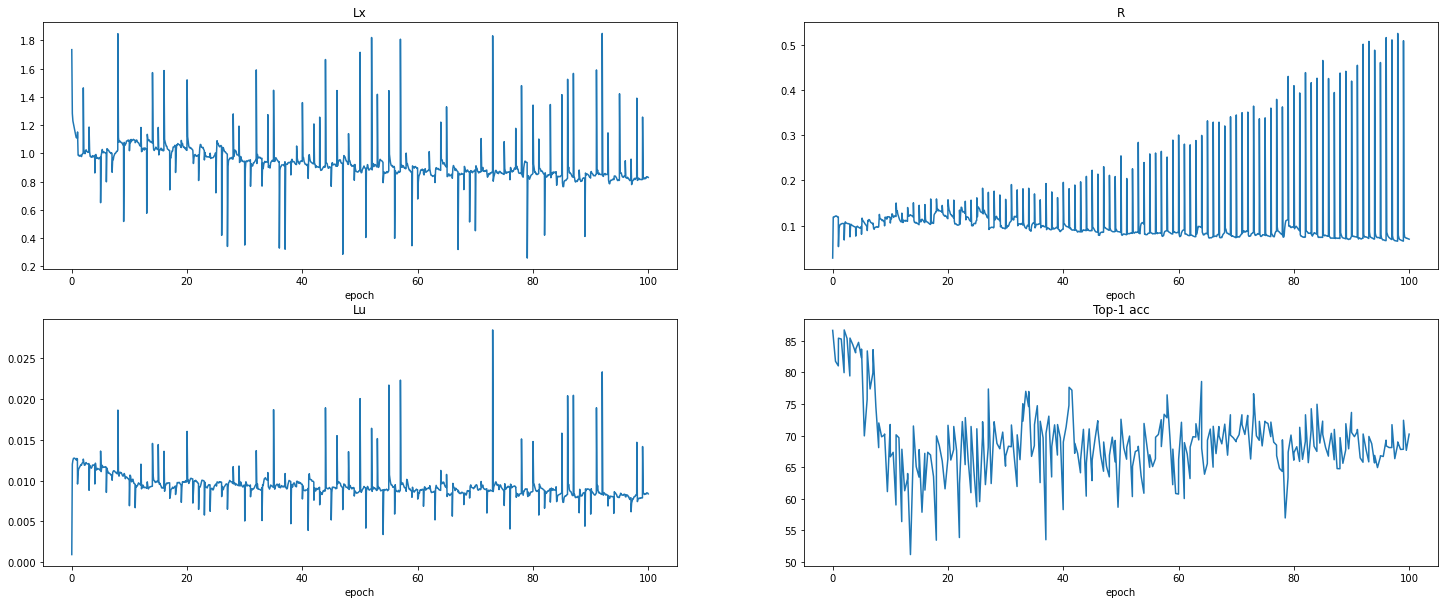

In [3]:

from matplotlib import pyplot as plt
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

def plot_result(result):
    fig, axs = plt.subplots(2,2, figsize=(25, 10))
    def get_avg_x_axs(hist):
        return list(map(lambda x: ((1024 * (x//11)) + (x% 11) * 100)/ 1024, range(len(hist))))

    acc1_x_axs = list(map(lambda x: ((1024 * (x//3)) + [0, 500, 1000][x%3]) / 1024, range(len(result['acc1_hist']))))
    axs[0,0].plot(get_avg_x_axs(result['losses_x_hist']), result['losses_x_hist'])
    axs[0,0].set_title('Lx')
    axs[0,0].set_xlabel('epoch')
    axs[0,1].plot(get_avg_x_axs(result['losses_r_hist']), result['losses_r_hist'])
    axs[0,1].set_title('R')
    axs[0,1].set_xlabel('epoch')
    axs[1,0].plot(get_avg_x_axs(result['losses_u_hist']), result['losses_u_hist'])
    axs[1,0].set_title('Lu')
    axs[1,0].set_xlabel('epoch')
    axs[1,1].plot(acc1_x_axs, result['acc1_hist'])
    axs[1,1].set_title('Top-1 acc')
    axs[1,1].set_xlabel('epoch')

plot_result(torch.load('runs/reproduce.bin'))